In [1]:
# Temel kütüphaneler
import os
import re
import shutil
import joblib
import warnings
import math
from math import pi
from pathlib import Path
from datetime import date
from collections import Counter
from typing import Iterable, List, Optional, Tuple, Set, Dict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots 

import requests
import unicodedata
import difflib
from concurrent.futures import ThreadPoolExecutor

from haversine import haversine, Unit
from scipy.stats import ks_2samp, wasserstein_distance
from skimage.feature import shape_index
from rapidfuzz import process, fuzz
import gmpy2

import missingno as msno
from kaggle.api.kaggle_api_extended import KaggleApi

import utils
import importlib
importlib.reload(utils)

# sklearn & imbalanced-learn
from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer, RobustScaler, StandardScaler, MinMaxScaler,
    OneHotEncoder, LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, validation_curve
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    RocCurveDisplay,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    confusion_matrix,
    classification_report,
    PrecisionRecallDisplay,
    ConfusionMatrixDisplay,
    accuracy_score
)
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Genel ayarlar
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [ ]:
#api = KaggleApi()
#api.authenticate()

#api.dataset_download_files('olistbr/brazilian-ecommerce', path='./dataset', unzip=True)

In [2]:
# Bu dosyanın (script) bulunduğu klasörü baz alıyoruz
base_path = os.path.join(os.getcwd(), "dataset")

file_name_customers = "olist_customers_dataset.csv"
file_name_geolocation = "olist_geolocation_dataset.csv"
file_name_orderitems = "olist_order_items_dataset.csv"
file_name_orderpayments = "olist_order_payments_dataset.csv"
file_name_orderreviews = "olist_order_reviews_dataset.csv"
file_name_orders = "olist_orders_dataset.csv"
file_name_products = "olist_products_dataset.csv"
file_name_sellers = "olist_sellers_dataset.csv"
file_name_category_name_translation = "product_category_name_translation.csv"


# Tam yol
customers_path = os.path.join(base_path, file_name_customers)
geolocation_path = os.path.join(base_path, file_name_geolocation)
orderitems_path = os.path.join(base_path, file_name_orderitems)
orderpayments_path = os.path.join(base_path, file_name_orderpayments)
orderreviews_path = os.path.join(base_path, file_name_orderreviews)
orders_path = os.path.join(base_path, file_name_orders)
products_path = os.path.join(base_path, file_name_products)
sellers_path = os.path.join(base_path, file_name_sellers)
product_category_name_translation_path = os.path.join(base_path, file_name_category_name_translation)



In [3]:
df_customers = utils.load(customers_path)
df_geo_avg = utils.load(geolocation_path)

In [4]:
# zip prefix bazında özet tablo
summary = (
    df_geo_avg.groupby("geolocation_zip_code_prefix")
    .agg(
        city_count=("geolocation_city", "nunique"),     # kaç farklı şehir var
        state_count=("geolocation_state", "nunique"),   # kaç farklı eyalet var
        coord_count=("geolocation_lat", "count"),       # toplam satır sayısı (koordinat sayısı)
        lat_std=("geolocation_lat", "std"),             # enlem sapması
        lng_std=("geolocation_lng", "std")              # boylam sapması
    )
    .reset_index()
)

summary.head()


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
0,1001,2,1,26,0.001,0.000
1,1002,2,1,13,0.001,0.001
2,1003,2,1,17,0.000,0.001
3,1004,2,1,22,0.001,0.000
4,1005,2,1,25,0.000,0.001


In [5]:
# %95 eşiklerini hesapla
lat_thresh = summary['lat_std'].quantile(0.95)
lng_thresh = summary['lng_std'].quantile(0.95)

# geniş alan zip’leri seç
wide_zips = summary[
    (summary['lat_std'] > lat_thresh) |
    (summary['lng_std'] > lng_thresh)
]

print("Lat std için %95 eşik:", lat_thresh)
print("Lng std için %95 eşik:", lng_thresh)
print("Eşik üzerinde kaç kayıt var:", len(wide_zips))
wide_zips.head(10)



Lat std için %95 eşik: 0.04056525284991052
Lng std için %95 eşik: 0.045473794164270054
Eşik üzerinde kaç kayıt var: 1272


,geolocation_zip_code_prefix,city_count,state_count,coord_count,lat_std,lng_std
130,1239,2,1,152,0.012,0.066
202,1417,2,1,86,0.026,0.079
215,1430,2,1,11,0.145,0.013
216,1431,2,1,13,0.117,0.011
257,1513,1,1,24,0.023,0.072
406,2169,2,1,45,0.106,0.071
458,2237,1,1,8,0.136,0.045
508,2290,2,1,3,0.109,0.047
531,2323,2,1,56,0.044,0.053
532,2324,2,1,48,0.087,0.033


In [6]:
# summary tablosundan gerekli sütunları alıyoruz
zip_summary = summary[['geolocation_zip_code_prefix', 'city_count', 'state_count']].copy()

# Durum sütunu
def zip_type(row):
    if row['state_count'] > 1:
        return 'Farklı eyaletlerde'
    elif row['state_count'] == 1 and row['city_count'] > 1:
        return 'Aynı eyalette farklı şehirler'
    else:
        return 'Tek şehir, tek eyalet'

zip_summary['type'] = zip_summary.apply(zip_type, axis=1)


zip_summary_sorted = zip_summary.sort_values(
    by=['state_count', 'city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

zip_summary_sorted.head(10)

,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Farklı eyaletlerde
1,2116,2,2,Farklı eyaletlerde
2,4011,2,2,Farklı eyaletlerde
3,78557,2,2,Farklı eyaletlerde
4,80630,2,2,Farklı eyaletlerde
5,21550,1,2,Farklı eyaletlerde
6,23056,1,2,Farklı eyaletlerde
7,79750,1,2,Farklı eyaletlerde
8,6900,5,1,Aynı eyalette farklı şehirler
9,13318,5,1,Aynı eyalette farklı şehirler


### Aynı eyalette birden fazla şehir

In [7]:
same_state_multi_city = zip_summary_sorted[(zip_summary_sorted['state_count'] == 1) & (zip_summary_sorted['city_count'] > 1)]
same_state_multi_city_count = same_state_multi_city.shape[0]

# Farklı eyaletlerde olan zip kodları
multi_state = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]
multi_state_count = multi_state.shape[0]

same_state_multi_city_count, multi_state_count


(8551, 8)

### Farklı eyaletleri kapsayan zip kodları ve eyalet isimleri

In [8]:
multi_state_zips = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]

# İlk 10 satırı göster
multi_state_zips.head(10)

# İstersen tüm listeyi görmek için:
multi_state_zips


,geolocation_zip_code_prefix,city_count,state_count,type
0,72915,3,2,Farklı eyaletlerde
1,2116,2,2,Farklı eyaletlerde
2,4011,2,2,Farklı eyaletlerde
3,78557,2,2,Farklı eyaletlerde
4,80630,2,2,Farklı eyaletlerde
5,21550,1,2,Farklı eyaletlerde
6,23056,1,2,Farklı eyaletlerde
7,79750,1,2,Farklı eyaletlerde


In [9]:
state_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique()
zip_diff_states = state_counts[state_counts > 1].reset_index()
zip_diff_states = zip_diff_states.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_diff_states = zip_diff_states.rename(columns={'geolocation_state': 'states'})
zip_diff_states


,geolocation_zip_code_prefix,geolocation_state_x,geolocation_state_y
0,2116,2,"[SP, RN]"
1,4011,2,"[SP, AC]"
2,21550,2,"[RJ, AC]"
3,23056,2,"[RJ, AC]"
4,72915,2,"[GO, DF]"
5,78557,2,"[MT, RO]"
6,79750,2,"[MS, RS]"
7,80630,2,"[PR, SC]"


In [10]:
city_counts = df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].nunique()
zip_same_state_diff_city = city_counts[(city_counts > 1) & (df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_state'].nunique() == 1)]
zip_same_state_diff_city = zip_same_state_diff_city.reset_index()
zip_same_state_diff_city = zip_same_state_diff_city.merge(
    df_geo_avg.groupby('geolocation_zip_code_prefix')['geolocation_city'].unique().reset_index(),
    on='geolocation_zip_code_prefix'
)
zip_same_state_diff_city = zip_same_state_diff_city.rename(columns={'geolocation_city': 'cities'})
zip_same_state_diff_city.head()

,geolocation_zip_code_prefix,geolocation_city_x,geolocation_city_y
0,1001,2,"[sao paulo, são paulo]"
1,1002,2,"[sao paulo, são paulo]"
2,1003,2,"[sao paulo, são paulo]"
3,1004,2,"[sao paulo, são paulo]"
4,1005,2,"[sao paulo, são paulo]"


In [11]:
# Her zip için state ve city bilgisi
zip_info = (
    df_geo_avg
    .groupby('geolocation_zip_code_prefix')
    .agg(
        state_count=('geolocation_state', 'nunique'),
        states=('geolocation_state', lambda x: list(x.unique())),
        max_city_count=('geolocation_city', lambda x: x.nunique())  # her zip içindeki toplam farklı şehir sayısı
    )
    .reset_index()
)

# Sıralama: önce state_count, sonra max_city_count
zip_info_sorted = zip_info.sort_values(
    by=['state_count', 'max_city_count'], 
    ascending=[False, False]
).reset_index(drop=True)

zip_info_sorted.head(10)

,geolocation_zip_code_prefix,state_count,states,max_city_count
0,72915,2,"[GO, DF]",3
1,2116,2,"[SP, RN]",2
2,4011,2,"[SP, AC]",2
3,78557,2,"[MT, RO]",2
4,80630,2,"[PR, SC]",2
5,21550,2,"[RJ, AC]",1
6,23056,2,"[RJ, AC]",1
7,79750,2,"[MS, RS]",1
8,6900,1,[SP],5
9,13318,1,[SP],5


In [12]:
df_orderitems = utils.load(orderitems_path)
df_orderpayments = utils.load(orderpayments_path)
df_orderreviews = utils.load(orderreviews_path)
df_orders = utils.load(orders_path)
df_products = utils.load(products_path)
df_sellers = utils.load(sellers_path)

### Farkli yazim sekilleri nedeniyle tekrar eden ayni sehir ve eyaletlerin tespiti

In [13]:
# 1.  Gelişmiş şehir normalizasyonu
def normalize_city_advanced(name: str) -> str:
    if pd.isna(name):
        return ""
    name = name.strip().lower()
    # Aksanları kaldır
    name = ''.join(c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn')
    # Nokta, tire, apostrof, boşluk gibi karakterleri kaldır
    name = re.sub(r'[\s\.\-\'"]', '', name)
    return name

In [14]:
# 2. Benzer şehirleri gruplayıp tekilleştirme
def deduplicate_cities(city_list, threshold: float = 0.9) -> dict:
    mapping = {}
    for i, city in enumerate(city_list):
        if city not in mapping:
            mapping[city] = city  # ilk gördüğünü referans al
        for other in city_list[i+1:]:
            similarity = difflib.SequenceMatcher(None, city, other).ratio()
            if similarity >= threshold:
                mapping[other] = mapping[city]
    return mapping

In [15]:
# 3. Ana fonksiyon (şehir + eyalet)

def clean_city_names(df, city_col, state_col, similarity_threshold=0.9):
    """
    Tüm şehir isimlerini normalize eder ve benzer şehirleri tekilleştirir.
    """
    # Normalize edilmiş şehir sütunu
    df['city_norm'] = df[city_col].apply(normalize_city_advanced)

    # Eyalet bazında şehir listesi
    state_cities = (
        df.groupby(state_col)['city_norm']
        .unique()
        .reset_index()
        .rename(columns={'city_norm': 'cities'})
    )

    # Eyalet bazlı eşleşmeler
    all_mappings = {}
    for idx, row in state_cities.iterrows():
        state = row[state_col]
        city_list = list(row['cities'])
        mapping = deduplicate_cities(city_list, threshold=similarity_threshold)
        for raw_city, clean_city in mapping.items():
            all_mappings[(state, raw_city)] = clean_city

    # Orijinal tabloyu güncelle
    df[city_col] = df.apply(
        lambda row: all_mappings.get((row[state_col], row['city_norm']), row['city_norm']),
        axis=1
    )

    # Geçici sütunu kaldır
    df = df.drop(columns=['city_norm'])
    
    return df

In [16]:
# geolocation tablosu için
df_geo_avg = clean_city_names(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state')

In [17]:
# Customers tablosu için
df_customers = clean_city_names(df_customers, city_col='customer_city', state_col='customer_state')


In [18]:
# Sellers tablosu için
df_sellers = clean_city_names(df_sellers, city_col='seller_city', state_col='seller_state')

## Temizleme işleminden sonra hala tekrar eden şehir isimleri kaldı mı kontrol

In [19]:
def check_remaining_similar_cities(df, city_col, state_col, threshold=0.9):
    """
    Temizlenmiş tabloda hala birbirine benzer şehir var mı diye kontrol eder.
    """
    state_cities = (
        df.groupby(state_col)[city_col]
        .unique()
        .reset_index()
        .rename(columns={city_col: 'cities'})
    )

    all_duplicates = {}
    for _, row in state_cities.iterrows():
        state = row[state_col]
        cities = row['cities']
        duplicates = []
        for i, city in enumerate(cities):
            for other in cities[i+1:]:
                similarity = difflib.SequenceMatcher(None, city, other).ratio()
                if similarity >= threshold:
                    duplicates.append((city, other, similarity))
        if duplicates:
            all_duplicates[state] = duplicates

    if not all_duplicates:
        print("✅ Hiç tekrar eden veya benzer şehir kalmadı.")
    else:
        for state, duplicates in all_duplicates.items():
            print(f"\nEyalet: {state}")
            for dup in duplicates:
                print(f" - {dup[0]} ~ {dup[1]} (benzerlik: {dup[2]:.2f})")



In [20]:
check_remaining_similar_cities(df_geo_avg, city_col='geolocation_city', state_col='geolocation_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


In [21]:
check_remaining_similar_cities(df_sellers, city_col='seller_city', state_col='seller_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


In [22]:
check_remaining_similar_cities(df_customers, city_col='customer_city', state_col='customer_state' )

✅ Hiç tekrar eden veya benzer şehir kalmadı.


# DATA MODELING

-----------------------------
️1-  Basit sayısal ID oluşturma fonksiyonu
-----------------------------

In [23]:
# Prefiksli ID oluşturma (ID olan tablolar)
def create_prefixed_id(df, original_id_col, new_id_col, prefix):
    df = df.copy()
    id_map = {old_id: f"{prefix}{str(i+1).zfill(3)}" for i, old_id in enumerate(df[original_id_col])}
    df[new_id_col] = df[original_id_col].map(id_map)
    return df, id_map

# Prefiksli ID oluşturma (ID olmayan tablolar)
def create_prefixed_id_no_col(df, new_id_col, prefix):
    df = df.copy()
    df[new_id_col] = [f"{prefix}{str(i+1).zfill(3)}" for i in range(len(df))]
    return df


️2- PK’ları Prefiksli ID’ye Çevirme ve Mapping Saklama
-----------------------------


In [24]:
# Sellers
df_sellers, seller_id_map = create_prefixed_id(df_sellers, "seller_id", "seller_id_pref", "SEL")

# Orders
df_orders, order_id_map = create_prefixed_id(df_orders, "order_id", "order_id_pref", "ORD")

# Products
df_products, product_id_map = create_prefixed_id(df_products, "product_id", "product_id_pref", "PRO")

# Customers
df_customers, customers_id_map = create_prefixed_id(df_customers, "customer_id", "customer_id_pref", "CUS")


# Order Items (ID olmayan ama ürün sayısı kolonu korunacak)
df_orderitems = df_orderitems.rename(columns={"order_item_id": "order_item_number"})  # PK değil
df_orderitems = create_prefixed_id_no_col(df_orderitems, "order_item_pref", "OIT")
# Order Payments
df_orderpayments= create_prefixed_id_no_col(df_orderpayments, "orderpayment_id_pref", "PAY")
# Geolocation (ID yok)
df_geo_avg = create_prefixed_id_no_col(df_geo_avg, "geolocation_id_pref", "GEO")


In [25]:
# Orders → customer_id_pref ekle
df_orders["customer_id_pref"] = df_orders["customer_id"].map(customers_id_map)

# Order Items → order_id_pref, product_id_pref, seller_id_pref ekle
df_orderitems["order_id_pref"] = df_orderitems["order_id"].map(order_id_map)
df_orderitems["product_id_pref"] = df_orderitems["product_id"].map(product_id_map)
df_orderitems["seller_id_pref"] = df_orderitems["seller_id"].map(seller_id_map)

# Order Payments → order_id_pref ekle
df_orderpayments["order_id_pref"] = df_orderpayments["order_id"].map(order_id_map)

print("Boş kalan customer_id_pref:", df_orders["customer_id_pref"].isnull().sum())
print("Boş kalan order_id_pref (items):", df_orderitems["order_id_pref"].isnull().sum())
print("Boş kalan product_id_pref:", df_orderitems["product_id_pref"].isnull().sum())
print("Boş kalan seller_id_pref:", df_orderitems["seller_id_pref"].isnull().sum())
print("Boş kalan order_id_pref (payments):", df_orderpayments["order_id_pref"].isnull().sum())

Boş kalan customer_id_pref: 0
Boş kalan order_id_pref (items): 0
Boş kalan product_id_pref: 0
Boş kalan seller_id_pref: 0
Boş kalan order_id_pref (payments): 0


In [26]:
# 1. Eşsiz customer_unique_id listesi
unique_customers = df_customers[['customer_unique_id']].drop_duplicates().reset_index(drop=True)

# 2. Yeni ID oluştur
unique_customers['cusUni'] = [f"CUSUNI{str(i+1).zfill(4)}" for i in range(len(unique_customers))]

# 3. Orijinal tabloya merge ile ekle
df_customers = df_customers.merge(unique_customers, on='customer_unique_id', how='left')


In [27]:
#Her customer_unique_id kaç farklı cusUni ile eşleşmiş 
check_unique = df_customers.groupby('customer_unique_id')['cusUni'].nunique().reset_index()
check_unique.rename(columns={'cusUni': 'num_unique_ids'}, inplace=True)

# 2. Eğer her customer_unique_id yalnızca bir cusUni ile eşleşmişse tamamdır
problem_customers = check_unique[check_unique['num_unique_ids'] != 1]

if problem_customers.empty:
    print("Tüm müşteri unique ID’leri düzgün şekilde tek bir yeni ID ile eşleşmiş.")
else:
    print("Dikkat! Bazı müşteri unique ID’leri birden fazla yeni ID ile eşleşmiş:")
    print(problem_customers)



Tüm müşteri unique ID’leri düzgün şekilde tek bir yeni ID ile eşleşmiş.


Zip code ve city/state kolonlarını customers & sellers'tan silinebilir

Orijinal ID’leri sil

In [28]:
# Orijinal ID kolonları
drop_cols = {
    "customers": ["customer_id", "customer_unique_id"],
    "sellers": ["seller_id"],
    "orders": ["order_id", "customer_id"],
    "order_items": ["order_id", "product_id", "seller_id"],
    "products": ["product_id"],
    "order_payments": ["orderpayment_id", "order_id"],
    "df_geo_avg": []
}

dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "df_geo_avg": df_geo_avg
}

for name, df in dfs.items():
    cols_to_drop = [c for c in drop_cols[name] if c in df.columns]
    dfs[name] = df.drop(columns=cols_to_drop)

(df_customers, df_sellers, df_orders, df_orderitems,
 df_products, df_orderpayments, df_geo_avg) = [dfs[k] for k in dfs]

Prefiksli ID’leri başa taşı

In [29]:
def move_prefixed_id_first(df, prefixed_id_col, fk_cols=None):
    """
    DataFrame kolonlarını yeniden sıralar:
    - Önce Primary Key (prefixed_id_col)
    - Sonra Foreign Key kolonları (fk_cols listesi)
    - Sonra diğer tüm kolonlar
    """
    df = df.copy()
    if fk_cols is None:
        fk_cols = []
    cols = [prefixed_id_col] + fk_cols + [c for c in df.columns if c not in ([prefixed_id_col] + fk_cols)]
    return df[cols]


# Başta prefiksli ID, FK’lar da başa
df_customers    = move_prefixed_id_first(df_customers, "customer_id_pref")
df_sellers      = move_prefixed_id_first(df_sellers, "seller_id_pref")
df_orders       = move_prefixed_id_first(df_orders, "order_id_pref", fk_cols=["customer_id_pref"])
df_orderitems   = move_prefixed_id_first(df_orderitems, "order_item_pref", fk_cols=["order_id_pref", "product_id_pref", "seller_id_pref"])
df_products     = move_prefixed_id_first(df_products, "product_id_pref")
df_orderpayments= move_prefixed_id_first(df_orderpayments, "orderpayment_id_pref", fk_cols=["order_id_pref"])
df_geo_avg      = move_prefixed_id_first(df_geo_avg, "geolocation_id_pref")

In [30]:
df_geo_avg.head()

,geolocation_id_pref,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,GEO001,1037,-23.546,-46.639,saopaulo,SP
1,GEO002,1046,-23.546,-46.645,saopaulo,SP
2,GEO003,1046,-23.546,-46.643,saopaulo,SP
3,GEO004,1041,-23.544,-46.639,saopaulo,SP
4,GEO005,1035,-23.542,-46.642,saopaulo,SP


In [31]:
df_geolocation = df_geo_avg
# 1. GEO tablosundan ortalama koordinat çıkar (geo_avg)
df_geo_avg = (
    df_geolocation
    .groupby("geolocation_zip_code_prefix")[["geolocation_lat", "geolocation_lng"]]
    .mean()
    .reset_index()
    .rename(columns={
        "geolocation_zip_code_prefix": "zip_prefix",
        "geolocation_lat": "lat_avg",
        "geolocation_lng": "lng_avg"
    })
)

# 2. CUSTOMERS tablosuna ortalama koordinat ekle
df_customers = df_customers.merge(
    df_geo_avg,
    left_on="customer_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])  # temp kolon gerekmez

# 3. SELLERS tablosuna ortalama koordinat ekle
df_sellers = df_sellers.merge(
    df_geo_avg,
    left_on="seller_zip_code_prefix",
    right_on="zip_prefix",
    how="left"
).drop(columns=["zip_prefix"])

# Artık:
# df_geo_full  -> ham geo data (zip + lat + lng + pk)
# geo_avg      -> zip bazlı ortalama koordinatlar
# df_customers -> müşteri tablosu + ortalama koordinatlar
# df_sellers   -> satıcı tablosu + ortalama koordinatlar


In [32]:
df_geo_avg.head()

,zip_prefix,lat_avg,lng_avg
0,1001,-23.550,-46.634
1,1002,-23.548,-46.635
2,1003,-23.549,-46.636
3,1004,-23.550,-46.635
4,1005,-23.549,-46.637


In [33]:
df_customers = df_customers.rename(columns={
    'lat_avg': 'customer_lat_avg',
    'lng_avg': 'customer_lng_avg'
})

In [34]:
df_sellers = df_sellers.rename(columns={
    'lat_avg': 'seller_lat_avg',
    'lng_avg': 'seller_lng_avg'
})

In [35]:
df_orders = df_orders.rename(columns={"customer_id_pref": "customer_order_id"})

### Data tablolari yeni klasore (cleaned_data_with_prefix_id) eklenmis durumda.
### Kodu yeniden calistirirsaniz ikinci bir data klasoru olusturulmaz ve 
### Bu klasor eger olusturulmus durumda ise tablolar bu klasore olustururlur.
### Mevcut tablolar onceden var ise , guncellenir. 
### Klasor yok ise bastan olusturulur...

In [36]:
# Kaydedilecek klasör adı
prefix_id_path = Path.cwd() / "cleaned_data_with_prefix_id"

# Her çalıştırmada klasörü sıfırla (varsa sil, sonra yeniden oluştur)
if prefix_id_path.exists():
    shutil.rmtree(prefix_id_path)
prefix_id_path.mkdir(parents=True, exist_ok=True)

# Kaydedilecek DataFrame'ler
dfs = {
    "customers": df_customers,
    "sellers": df_sellers,
    "orders": df_orders,
    "order_items": df_orderitems,
    "products": df_products,
    "order_payments": df_orderpayments,
    "geo_avg": df_geo_avg,
    "geolocation": df_geolocation,
}

# CSV olarak yaz
for name, df in dfs.items():
    file_path = prefix_id_path / f"{name}.csv"
    df.to_csv(file_path, index=False, sep=";",decimal=",")
    print(f"{file_path} kaydedildi. shape={df.shape}")

c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\28092025\two-step-delivery-delay-prediction\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\customers.csv kaydedildi. shape=(99441, 7)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\28092025\two-step-delivery-delay-prediction\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\sellers.csv kaydedildi. shape=(3095, 6)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\28092025\two-step-delivery-delay-prediction\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\orders.csv kaydedildi. shape=(99441, 8)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\28092025\two-step-delivery-delay-prediction\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\order_items.csv kaydedildi. shape=(112650, 8)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Proje\28092025\two-step-delivery-delay-prediction\two-step-delivery-delay-prediction\cleaned_data_with_prefix_id\products.csv kaydedildi. shape=(32951, 9)
c:\Users\aykut\Desktop\EURO_TECH\GIT\Pr

### Yeni Olusturulan Dosya Yollari
#### notebook yeniden baslatildiginda direk buradan tablolar yuklenebilir..

In [37]:
# Bu dosyanın (script) bulunduğu klasörü baz alıyoruz
base_path = os.path.join(os.getcwd(), "cleaned_data_with_prefix_id")

new_file_name_customers = "customers.csv"
new_file_name_geolocation = "geolocation.csv"
new_file_name_geo_avg = "geo_avg.csv"
new_file_name_orderitems = "order_items.csv"
new_file_name_orderpayments = "order_payments.csv"
new_file_name_orders = "orders.csv"
new_file_name_products = "products.csv"
new_file_name_sellers = "sellers.csv"

# Tam yol
new_customers_path = os.path.join(base_path, new_file_name_customers)
new_geolocation_path = os.path.join(base_path, new_file_name_geolocation)
new_geo_avg_path = os.path.join(base_path, new_file_name_geo_avg)
new_orderitems_path = os.path.join(base_path, new_file_name_orderitems)
new_orderpayments_path = os.path.join(base_path, new_file_name_orderpayments)
new_orders_path = os.path.join(base_path, new_file_name_orders)
new_products_path = os.path.join(base_path, new_file_name_products)
new_sellers_path = os.path.join(base_path, new_file_name_sellers)



In [38]:
df_customers = utils.load(new_customers_path,sep=";",decimal=",")
df_geolocation = utils.load(new_geolocation_path,sep=";",decimal=",")
df_orderitems = utils.load(new_orderitems_path,sep=";",decimal=",")
df_orderpayments = utils.load(new_orderpayments_path,sep=";",decimal=",")
df_orders = utils.load(new_orders_path,sep=";",decimal=",")
df_products = utils.load(new_products_path,sep=";",decimal=",")
df_sellers = utils.load(new_sellers_path,sep=";",decimal=",")
df_sellers.head()

,seller_id_pref,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg
0,SEL001,13023,campinas,SP,-22.894,-47.061
1,SEL002,13844,mogiguacu,SP,-22.383,-46.948
2,SEL003,20031,riodejaneiro,RJ,-22.910,-43.178
3,SEL004,4195,saopaulo,SP,-23.657,-46.613
4,SEL005,12914,bragancapaulista,SP,-22.965,-46.534


## Mevcut dimension tablolarını kullanarak fact_order_shipments tablosu

Payments kısmında bazı siparişler için birden fazla ödeme yöntemi kullanılması ve taksitli şekilde ödeme gerçekleşmesi sebebiyle ödemelerde ayrı sipariş için birden fazla satır bulunuyor. Her bir siparişi tek satır halinde yazmak için pay_agg isimli bir dataframe oluşturup aggrigasyon işlemleri yapılabilir:


Burada aynı sipariş üzerinde birden fazla ödeme şekli varsa onları bir satıra (payment_types) aralarına / işareti koyarak ayrılıp taksitli satış ödemelerinin taksit sayısının en yükseğini alarak olası taksit sayısı sorgulamalarında kullanılmak üzere dataframe üzerinde bırakıldı(payment_installment_max) ve son olarak ödenen tutarı toplayarak (payment_value_sum) her bir sipariş tutarı için bir toplam ödeme satırı oluşturuldu. 

### Çoklu ödeme satırlarını tespit etme ve özetleme

In [39]:
multi_pay_orders = (
    df_orderpayments
      .groupby("order_id_pref")
      .filter(lambda x: len(x) > 1)   # aynı Şiparişte olup satır sayısı >1 olanlar
      .sort_values(["order_id_pref","payment_sequential"])
)

print("Birden fazla payment kaydı olan sipariş sayısı:",
      multi_pay_orders["order_id_pref"].nunique())

# Örnek olarak ilk 10 siparişi göster
multi_pay_orders.head(10)

Birden fazla payment kaydı olan sipariş sayısı: 2961


,orderpayment_id_pref,order_id_pref,payment_sequential,payment_type,payment_installments,payment_value
10770,PAY10771,ORD001,1,credit_card,1,18.120
91130,PAY91131,ORD001,2,voucher,1,18.590
44246,PAY44247,ORD001,3,voucher,1,2.000
52200,PAY52201,ORD010,1,credit_card,1,8.340
16545,PAY16546,ORD010,2,voucher,1,161.420
92279,PAY92280,ORD020,1,credit_card,1,5.960
35461,PAY35462,ORD020,2,voucher,1,62.150
42035,PAY42036,ORD020,3,voucher,1,24.860
76131,PAY76132,ORD078,1,credit_card,1,7.080
44840,PAY44841,ORD078,2,voucher,1,227.200


In [40]:
# sipariş bazında ödeme özetleri ---
pay_agg = (df_orderpayments
           .groupby("order_id_pref", as_index=False)
           .agg(
               payment_value_sum=("payment_value", "sum"), # bir siparişe yapılan toplam ödemeyi bir satıra koy
               payment_installments_max=("payment_installments", "max"), # Taksit sayısının en yükseğini sakla
               payment_types=("payment_type", lambda s: "/".join(sorted(s.astype(str).unique()))) #ödeme şekillerini / ile aynı satıra yaz
           ))

# Çoklu ödeme satırı olan siparişleri bul (önceki adımın kısa hali)
multi_idler = (df_orderpayments.groupby("order_id_pref")
             .size().loc[lambda s: s > 1].index)

# Sadece bu siparişlerin pay_agg görünümü
pay_agg_multi = (pay_agg[pay_agg["order_id_pref"].isin(multi_idler)]
                 .sort_values("order_id_pref"))

print("Çoklu ödeme satırı olan sipariş sayısı:", len(multi_idler))
pay_agg_multi.head(10)

Çoklu ödeme satırı olan sipariş sayısı: 2961


,order_id_pref,payment_value_sum,payment_installments_max,payment_types
0,ORD001,38.710,1,credit_card/voucher
9,ORD010,169.760,1,credit_card/voucher
19,ORD020,92.970,1,credit_card/voucher
77,ORD078,234.280,1,credit_card/voucher
98,ORD099,28.860,1,credit_card/voucher
158,ORD10052,212.810,5,credit_card/voucher
243,ORD10129,182.360,5,credit_card/voucher
286,ORD10168,144.750,1,credit_card/voucher
287,ORD10169,126.300,1,credit_card/voucher
319,ORD10198,336.920,8,credit_card


### Fact tablosu oluşturma ve merge işlemleri

In [41]:
fact_DF = (
    df_orderitems
      .merge(df_orders, on="order_id_pref", how="left")
      .merge(df_customers, left_on="customer_order_id", right_on="customer_id_pref", how="left")
      .drop(columns=["customer_id_pref"])
      .merge(df_sellers, on="seller_id_pref", how="left")
      .merge(df_products, on="product_id_pref", how="left")
      .merge(pay_agg, on="order_id_pref", how="left") 
)

In [42]:
fact_DF.shape

(112650, 37)

### Tarih kolonlarını datetime formatına çevirme

In [43]:
date_cols = [
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    "order_purchase_timestamp"
]

for col in date_cols:
    fact_DF[col] = pd.to_datetime(fact_DF[col], errors='coerce')  # Hatalı tarihleri NaT yapar

### Hazırlık ve teslim sürelerini hesaplama

In [44]:
fact_DF["prep_time"] = (
    fact_DF["order_delivered_carrier_date"] - fact_DF["order_approved_at"]
).dt.days

fact_DF["shipping_time"] = (
    fact_DF["order_delivered_customer_date"] - fact_DF["order_delivered_carrier_date"]
).dt.days

fact_DF["estimated_time"] = (
    fact_DF["order_estimated_delivery_date"] - fact_DF["order_approved_at"]
).dt.days

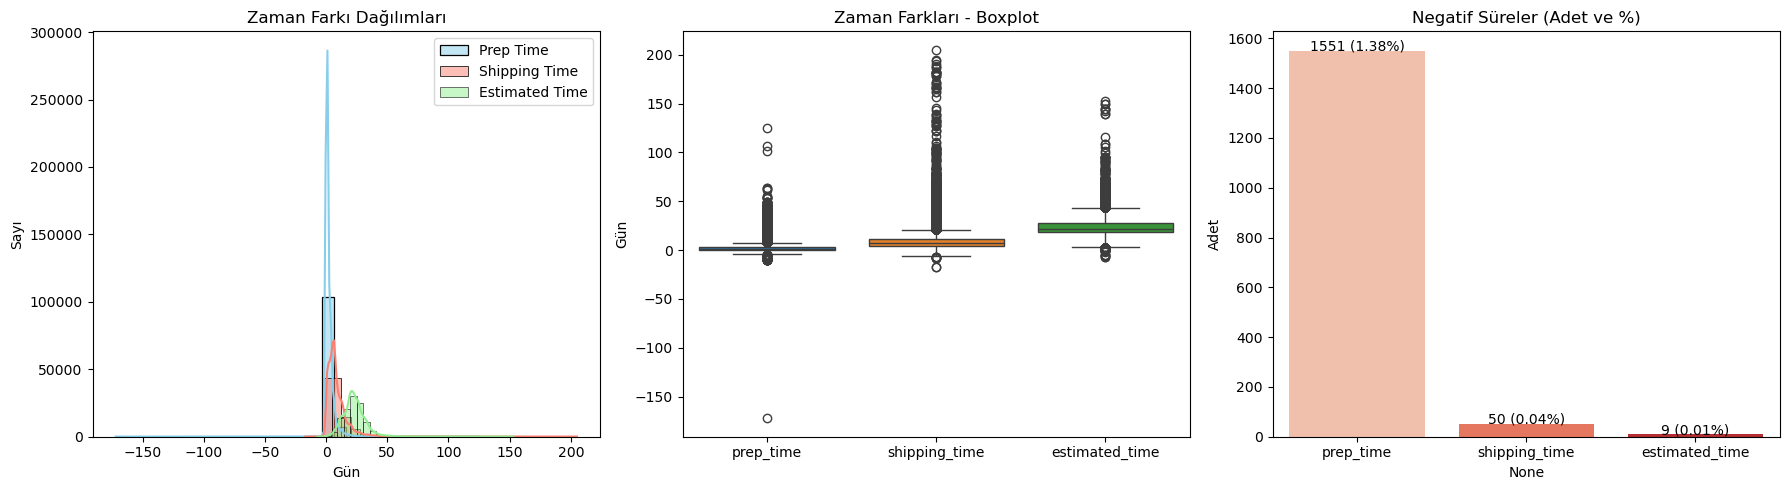

In [45]:
# Toplam satır sayısı
total_rows = fact_DF.shape[0]

# Negatif değerler
neg_counts = fact_DF[["prep_time","shipping_time","estimated_time"]].lt(0).sum()
neg_perc   = (neg_counts / total_rows * 100).round(2)

# Grafik oluştur
plt.figure(figsize=(18,5))

# --- Histogram ---
plt.subplot(1,3,1)
sns.histplot(fact_DF["prep_time"], kde=True, color="skyblue", label="Prep Time", bins=30)
sns.histplot(fact_DF["shipping_time"], kde=True, color="salmon", label="Shipping Time", bins=30)
sns.histplot(fact_DF["estimated_time"], kde=True, color="lightgreen", label="Estimated Time", bins=30)
plt.title("Zaman Farkı Dağılımları")
plt.xlabel("Gün")
plt.ylabel("Sayı")
plt.legend()

# --- Boxplot ---
plt.subplot(1,3,2)
sns.boxplot(data=fact_DF[["prep_time", "shipping_time", "estimated_time"]])
plt.title("Zaman Farkları - Boxplot")
plt.ylabel("Gün")

# --- Negatif Değerler Barplot ---
plt.subplot(1,3,3)
sns.barplot(x=neg_counts.index, y=neg_counts.values, palette="Reds")
for i, v in enumerate(neg_counts.values):
    plt.text(i, v + 1, f"{v} ({neg_perc[i]}%)", ha='center')
plt.title("Negatif Süreler (Adet ve %)")
plt.ylabel("Adet")

plt.tight_layout()
plt.show()

prep_time negatif: sipariş daha onaylanmadan kargoya verilmiş görünüyor (timestamp sorunu olabilir).

shipping_time negatif: müşteri ürünü kargoya verilmeden teslim almış gibi görünüyor (muhtemelen data error).

estimated_time negatif: tahmini teslim tarihi onay tarihinden önce görünüyor (yanlış kayıt).

In [46]:
print(fact_DF.shape[0])
fact_DF[['prep_time', 'shipping_time', 'estimated_time']].isnull().mean() * 100


112650


prep_time        1.073
shipping_time    2.179
estimated_time   0.013
dtype: float64

### Gecikme hesaplamaları ve sınıflandırması

In [47]:
fact_DF['delay_days'] = (fact_DF['order_delivered_customer_date'] - fact_DF['order_estimated_delivery_date']).dt.days
fact_DF['delay_days'] = fact_DF['delay_days'].apply(lambda x: max(0, x))
fact_DF['is_late'] = fact_DF['delay_days'].apply(lambda x: 1 if x > 0 else 0)

In [48]:
# --- Sabit aralıklı Gecikme sınıfı (iş zekâsı için) ---
def classify_delay(days):
    if days == 0:
        return 0
    elif 1 <= days <= 3:
        return 1
    elif 4 <= days <= 7:
        return 2
    elif 8 <= days <= 10:
        return 3
    else:
        return 4

fact_DF['delay_class'] = fact_DF['delay_days'].apply(classify_delay)

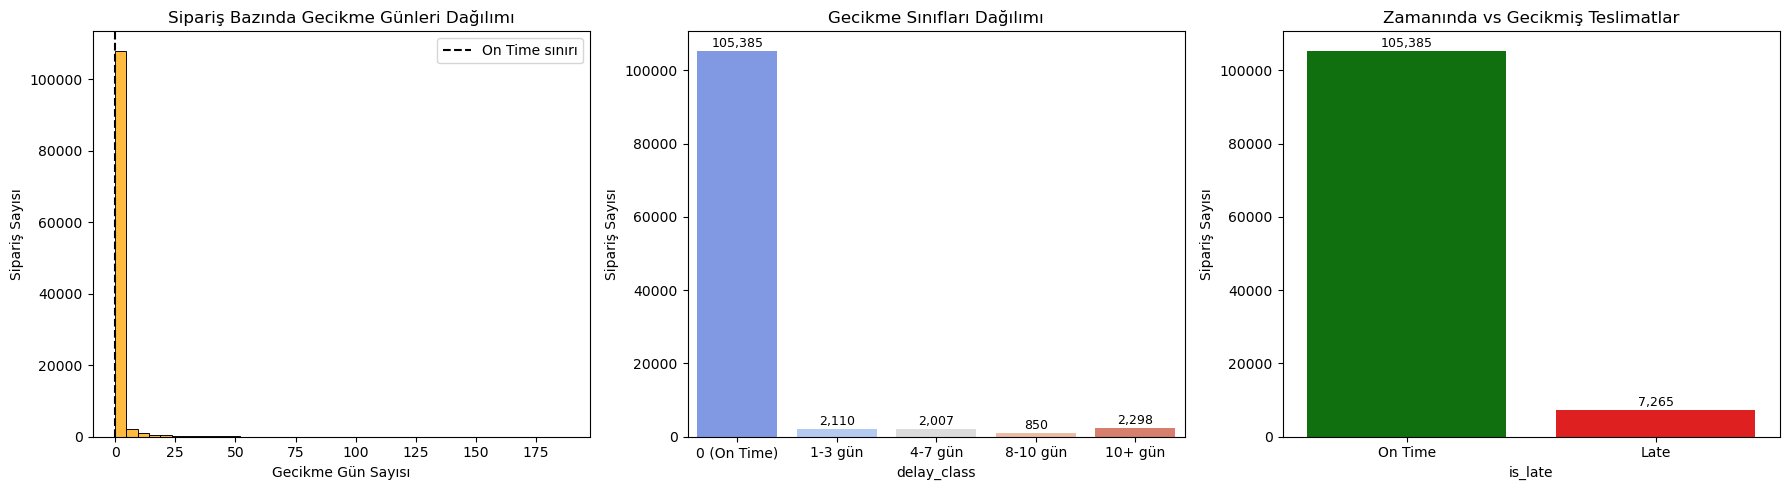

In [49]:
# Toplam satır sayısı
total_rows = fact_DF.shape[0]

# 1. Dağılımlar
delay_class_counts = fact_DF['delay_class'].value_counts().sort_index()
late_counts = fact_DF['is_late'].value_counts()

plt.figure(figsize=(18,5))

# --- 1. Histogram: delay_days ---
plt.subplot(1,3,1)
sns.histplot(fact_DF['delay_days'], bins=40, color='orange', kde=False)
plt.title('Sipariş Bazında Gecikme Günleri Dağılımı')
plt.xlabel('Gecikme Gün Sayısı')
plt.ylabel('Sipariş Sayısı')
plt.axvline(0, color="black", linestyle="--", label="On Time sınırı")
plt.legend()

# --- 2. Barplot: delay_class ---
plt.subplot(1,3,2)
sns.barplot(x=delay_class_counts.index, y=delay_class_counts.values, palette='coolwarm')
plt.xticks([0,1,2,3,4], ['0 (On Time)', '1-3 gün', '4-7 gün', '8-10 gün', '10+ gün'])
for i, v in enumerate(delay_class_counts.values):
    plt.text(i, v + total_rows*0.01, f"{v:,}", ha='center', fontsize=9)
plt.title('Gecikme Sınıfları Dağılımı')
plt.ylabel('Sipariş Sayısı')

# --- 3. Barplot: is_late ---
plt.subplot(1,3,3)
sns.barplot(x=late_counts.index, y=late_counts.values, palette=['green','red'])
plt.xticks([0,1], ['On Time', 'Late'])
for i, v in enumerate(late_counts.values):
    plt.text(i, v + total_rows*0.01, f"{v:,}", ha='center', fontsize=9)
plt.title('Zamanında vs Gecikmiş Teslimatlar')
plt.ylabel('Sipariş Sayısı')

plt.tight_layout()
plt.show()

###  Mesafe hesaplama ve satıcı sayısı

In [50]:
# haversine, genellikle iki koordinat arasındaki mesafeyi (km veya mil cinsinden) hesaplamak için kullanılır.
fact_DF = fact_DF.rename(columns={
    "lat_avg_x": "customer_lat_avg",
    "lng_avg_x": "customer_lng_avg",
    "lat_avg_y": "seller_lat_avg",
    "lng_avg_y": "seller_lng_avg"
})

# Haversine ile mesafe hesapla
def compute_distance(row):
    return haversine(
        (row['customer_lat_avg'], row['customer_lng_avg']), 
        (row['seller_lat_avg'], row['seller_lng_avg'])
    )

fact_DF['distance_km'] = fact_DF.apply(compute_distance, axis=1)

In [51]:
#  Aynı siparişteki satıcı sayısı
seller_count = df_orderitems.groupby('order_id_pref')['seller_id_pref'].nunique().reset_index()
seller_count.rename(columns={'seller_id_pref': 'seller_count_per_order'}, inplace=True)
fact_DF = fact_DF.merge(seller_count, on='order_id_pref', how='left')

In [52]:
#  İlgili sütunları seçerek final fact tablosu
fact_order_shipments = fact_DF[[
    'cusUni','customer_order_id', 'order_id_pref', 'seller_id_pref', 'product_id_pref', 
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'prep_time', 'shipping_time', 'estimated_time',
    'delay_days', 'delay_class', 'is_late', 'distance_km',
    'payment_types', 'payment_value_sum', 'payment_installments_max',
    'seller_count_per_order'
]]


fact_order_shipments.to_csv('fact_order_shipments.csv', index=False) # csv olarak kaydet. 

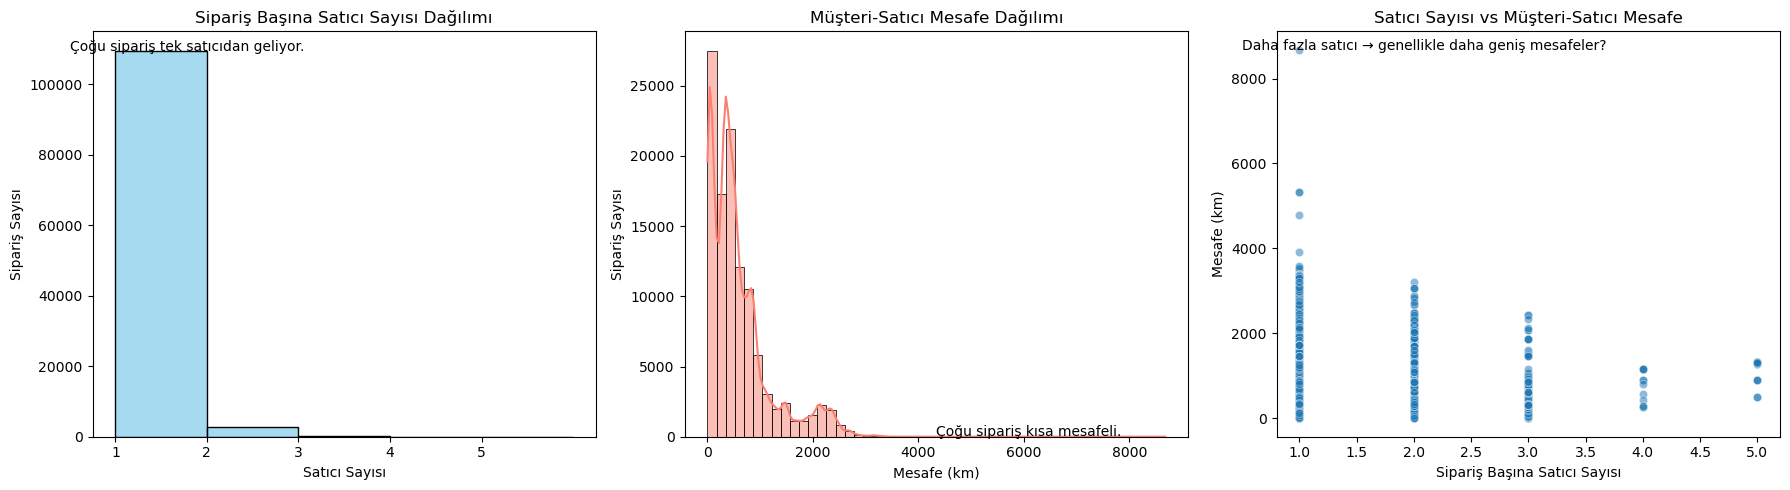

In [53]:
plt.figure(figsize=(18,5))

# --- 1. Histogram: seller_count_per_order ---
plt.subplot(1,3,1)
sns.histplot(fact_DF['seller_count_per_order'], bins=range(1, fact_DF['seller_count_per_order'].max()+2), 
             color='skyblue', kde=False)
plt.title('Sipariş Başına Satıcı Sayısı Dağılımı')
plt.xlabel('Satıcı Sayısı')
plt.ylabel('Sipariş Sayısı')
plt.xticks(range(1, fact_DF['seller_count_per_order'].max()+1))
plt.text(0.5, max(fact_DF['seller_count_per_order'].value_counts()), 
         "Çoğu sipariş tek satıcıdan geliyor.", fontsize=10, color='black')

# --- 2. Histogram: distance_km ---
plt.subplot(1,3,2)
sns.histplot(fact_DF['distance_km'], bins=50, color='salmon', kde=True)
plt.title('Müşteri-Satıcı Mesafe Dağılımı')
plt.xlabel('Mesafe (km)')
plt.ylabel('Sipariş Sayısı')
plt.text(max(fact_DF['distance_km'])/2, max(fact_DF['distance_km'].value_counts()), 
         "Çoğu sipariş kısa mesafeli.", fontsize=10, color='black')

# --- 3. Scatter Plot: seller_count_per_order vs distance_km ---
plt.subplot(1,3,3)
sns.scatterplot(x='seller_count_per_order', y='distance_km', data=fact_DF, alpha=0.5)
plt.title('Satıcı Sayısı vs Müşteri-Satıcı Mesafe')
plt.xlabel('Sipariş Başına Satıcı Sayısı')
plt.ylabel('Mesafe (km)')
plt.text(0.5, max(fact_DF['distance_km']), 
         "Daha fazla satıcı → genellikle daha geniş mesafeler?", fontsize=10, color='black')

plt.tight_layout()
plt.show()


### Null ve negatif değer kontrolü

Toplam satır sayısı: 112,650

Negatif süreler (adet ve %):
  prep_time      : 1551  (1.38%)
  shipping_time  : 50  (0.04%)
  estimated_time : 9  (0.01%)


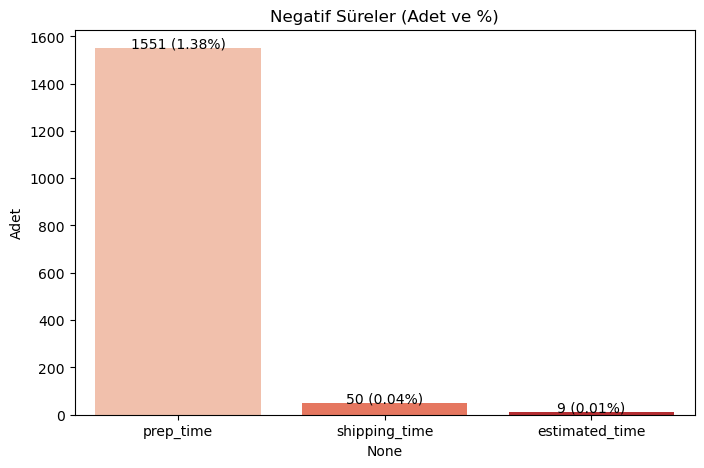


Null değerler (adet ve %):
  prep_time      : 1209  (1.07%)
  shipping_time  : 2455  (2.18%)
  estimated_time : 15  (0.01%)
  delay_days     : 0  (0.0%)
  distance_km    : 554  (0.49%)


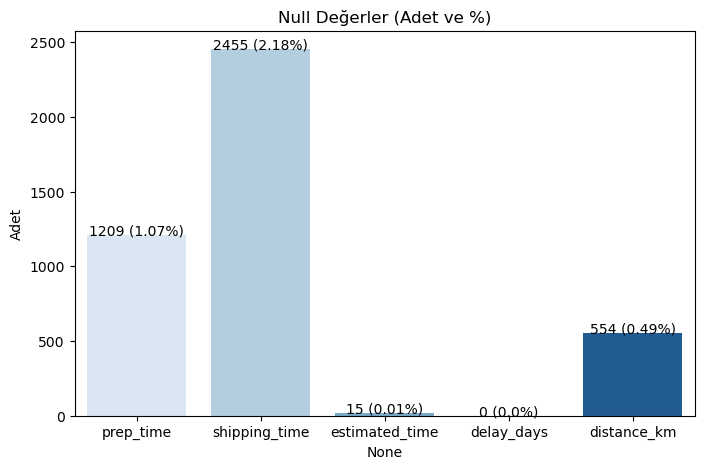

In [54]:
total_rows = fact_order_shipments.shape[0]

print(f"Toplam satır sayısı: {total_rows:,}\n")

# --- Negatif süreler ---
neg_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time"]].lt(0).sum()
neg_perc   = (neg_counts / total_rows * 100).round(2)
print("Negatif süreler (adet ve %):")
for col in neg_counts.index:
    print(f"  {col:<15}: {neg_counts[col]}  ({neg_perc[col]}%)")

plt.figure(figsize=(8,5))
sns.barplot(x=neg_counts.index, y=neg_counts.values, palette="Reds")
for i, v in enumerate(neg_counts.values):
    plt.text(i, v + 1, f"{v} ({neg_perc[i]}%)", ha='center')
plt.title("Negatif Süreler (Adet ve %)")
plt.ylabel("Adet")
plt.show()

# --- Null değerler ---
null_counts = fact_order_shipments[["prep_time","shipping_time","estimated_time","delay_days","distance_km"]].isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nNull değerler (adet ve %):")
for col in null_counts.index:
    print(f"  {col:<15}: {null_counts[col]}  ({null_perc[col]}%)")

plt.figure(figsize=(8,5))
sns.barplot(x=null_counts.index, y=null_counts.values, palette="Blues")
for i, v in enumerate(null_counts.values):
    plt.text(i, v + 1, f"{v} ({null_perc[i]}%)", ha='center')
plt.title("Null Değerler (Adet ve %)")
plt.ylabel("Adet")
plt.show()



Negatif değerler var (%1.38). Brezilyada birden fazla saat dilimi kullanıldığı için negatif sürelerin saat dilimi farkından mı kaynaklandığının kontrolü gerekir. 

Negatif prep_time - müşteri eyalet dağılımı:
customer_state
SP    653
MG    181
RJ    171
RS    102
PR     92
SC     56
BA     49
DF     43
GO     40
ES     28
CE     23
PE     21
MT     21
MA     12
PA     12
PB     12
RN      7
PI      7
MS      5
TO      4
AL      4
AC      3
SE      2
RO      1
AM      1
RR      1
Name: count, dtype: int64

Negatif prep_time - satıcı eyalet dağılımı:
seller_state
SP    1098
MG     125
PR     113
SC      67
RJ      61
RS      34
MA      19
DF      12
PE       7
GO       6
BA       4
CE       1
PB       1
MT       1
ES       1
MS       1
Name: count, dtype: int64


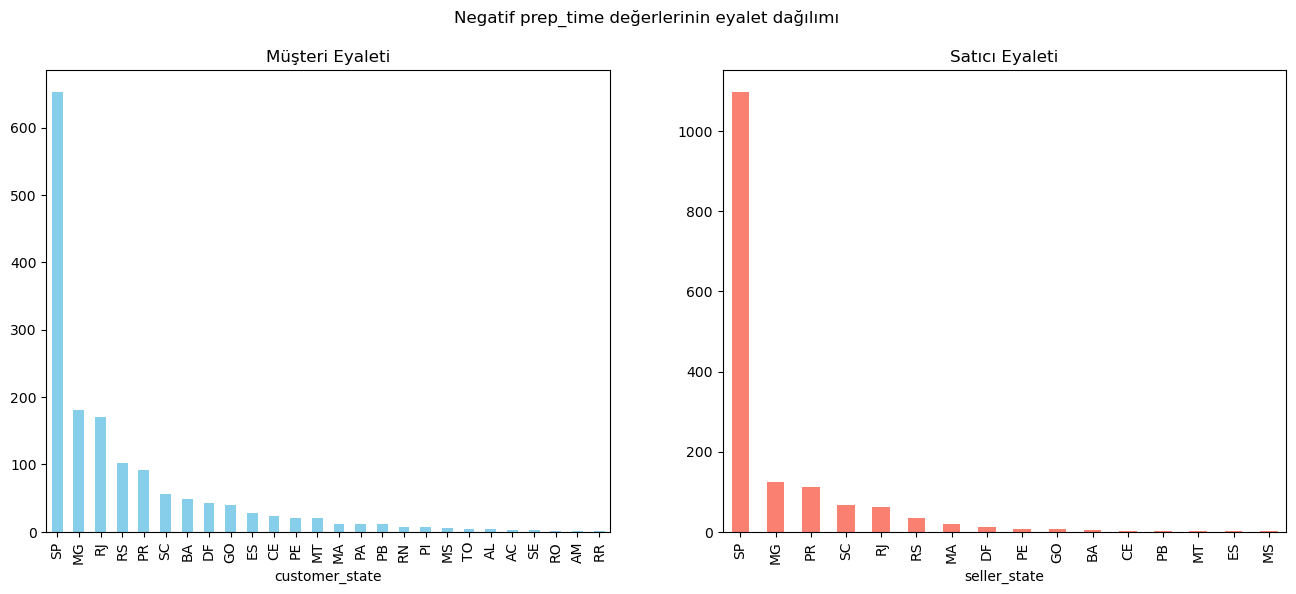

In [55]:
# 1) Negatif prep_time kayıtlarını seç
neg_prep = fact_DF[fact_DF["prep_time"] < 0].copy()

# 2) Müşteri eyaleti bazında dağılım
prep_by_customer = neg_prep["customer_state"].value_counts()

# 3) Satıcı eyaleti bazında dağılım
prep_by_seller = neg_prep["seller_state"].value_counts()

print("Negatif prep_time - müşteri eyalet dağılımı:")
print(prep_by_customer)

print("\nNegatif prep_time - satıcı eyalet dağılımı:")
print(prep_by_seller)


# 4) İsteğe bağlı görselleştirme
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(16,6))

prep_by_customer.plot(kind="bar", ax=axes[0], color="skyblue", title="Müşteri Eyaleti")
prep_by_seller.plot(kind="bar", ax=axes[1], color="salmon", title="Satıcı Eyaleti")

plt.suptitle("Negatif prep_time değerlerinin eyalet dağılımı")
plt.show()

**Müşteri tarafı**

Negatif prep_time en çok SP (653), MG (181), RJ (171), RS (102) gibi UTC−03 bölgesinde olan eyaletlerden geliyor.

UTC−04/−05 bölgelerinden (MT=21, AC=3, AM=1, RO=1, RR=1) gelenler de var ama toplam içinde çok küçük paya sahipler.

**Satıcı tarafı**

Negatif prep_time kayıtlarının neredeyse tamamı SP, MG, PR, SC, RJ gibi UTC−03 bölgesi satıcılardan geliyor.

UTC−04/−05 bölgelerinden (MT=1) neredeyse hiç çıkmamış.

**Sonuç**:

Negatif prep_time değerleri sadece saat dilimi farkından kaynaklanmıyor.

Asıl neden, veri giriş hataları / yanlış timestamp kaydı.

Örneğin siparişin kargoya veriliş tarihi yanlış yazılmış → onay tarihinden önce görünmüş.

Saat dilimi farklılıkları katkı yapmış olabilir ama çok küçük.

### Özet istatistikler / Temel sayısal özetler ve tipler

In [56]:
# --- Gecikme oranı ---
late_count = fact_order_shipments["is_late"].sum()
late_perc  = (late_count / total_rows * 100).round(2)
print(f"\nGecikmeli siparişler: {late_count}  ({late_perc}%)")

# --- Ödeme türleri ---
print("\nÖdeme türleri (adet ve % - ilk 10):")
pay_counts = fact_order_shipments["payment_types"].value_counts()
for t, c in pay_counts.head(10).items():
    print(f"  {t:<25}: {c}  ({c/total_rows*100:.2f}%)")

# --- Satıcı sayısı ---
print("\nSiparişteki satıcı sayısı (adet ve %):")
seller_counts = fact_order_shipments["seller_count_per_order"].value_counts().sort_index()
for sc, c in seller_counts.items():
    print(f"  {sc:<2} satıcı: {c}  ({c/total_rows*100:.2f}%)")


Gecikmeli siparişler: 7265  (6.45%)

Ödeme türleri (adet ve % - ilk 10):
  credit_card              : 83947  (74.52%)
  boleto                   : 22867  (20.30%)
  credit_card/voucher      : 2487  (2.21%)
  debit_card               : 1689  (1.50%)
  voucher                  : 1656  (1.47%)
  credit_card/debit_card   : 1  (0.00%)

Siparişteki satıcı sayısı (adet ve %):
  1  satıcı: 109547  (97.25%)
  2  satıcı: 2876  (2.55%)
  3  satıcı: 202  (0.18%)
  4  satıcı: 12  (0.01%)
  5  satıcı: 13  (0.01%)


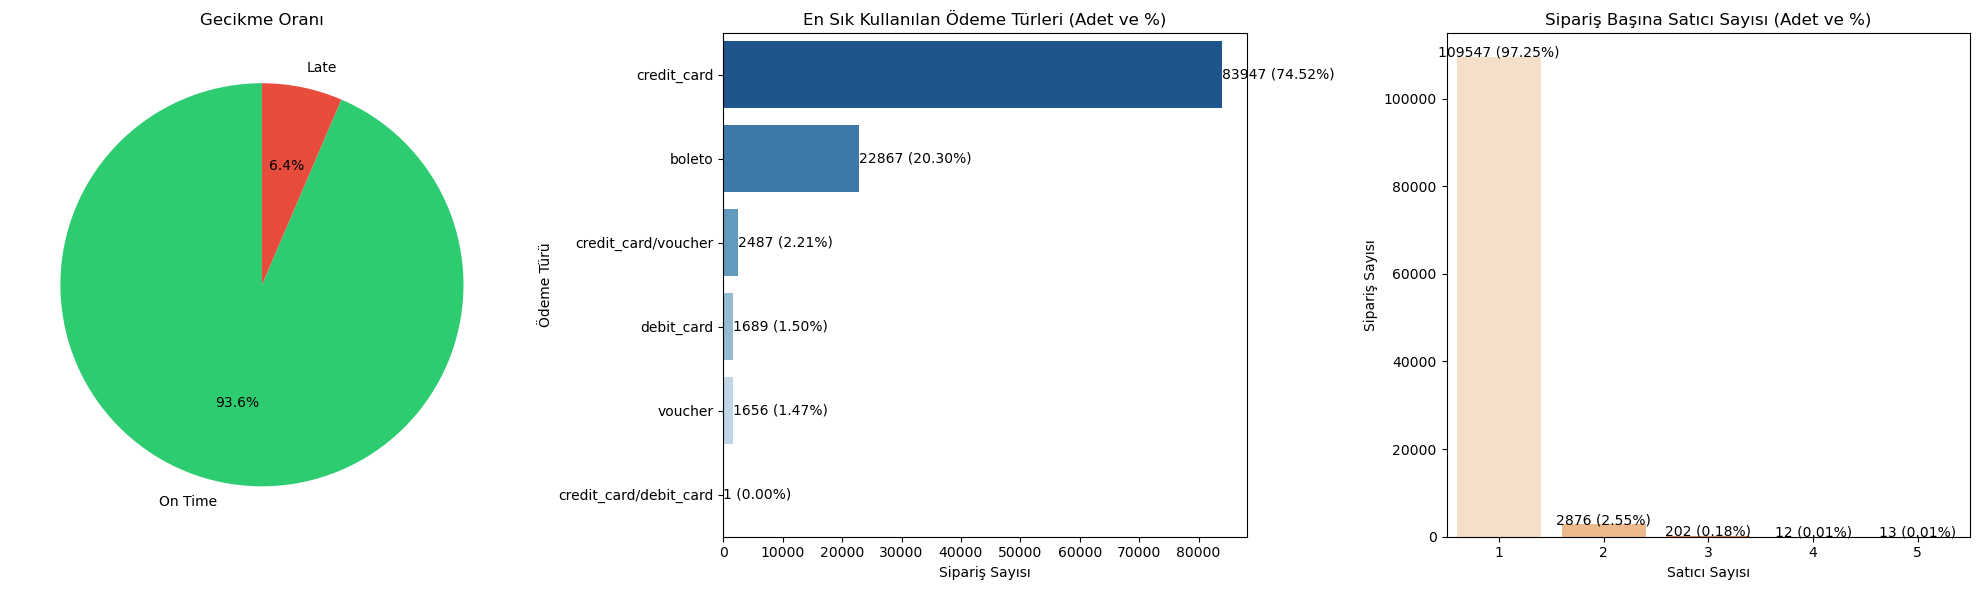

In [57]:
plt.figure(figsize=(20,6))

# --- 1. Gecikme Oranı Pie Chart ---
plt.subplot(1,3,1)
late_counts = fact_order_shipments['is_late'].value_counts()
plt.pie(late_counts.values, labels=['On Time', 'Late'], autopct='%1.1f%%', colors=['#2ecc71','#e74c3c'], startangle=90)
plt.title('Gecikme Oranı')

# --- 2. Ödeme Türleri Barplot ---
plt.subplot(1,3,2)
pay_counts = fact_order_shipments["payment_types"].value_counts().head(10)  # İlk 10 ödeme türü
sns.barplot(x=pay_counts.values, y=pay_counts.index, palette='Blues_r')
for i, v in enumerate(pay_counts.values):
    plt.text(v + 5, i, f"{v} ({v/total_rows*100:.2f}%)", va='center')
plt.title('En Sık Kullanılan Ödeme Türleri (Adet ve %)')
plt.xlabel('Sipariş Sayısı')
plt.ylabel('Ödeme Türü')

# --- 3. Satıcı Sayısı Barplot ---
plt.subplot(1,3,3)
seller_counts = fact_order_shipments["seller_count_per_order"].value_counts().sort_index()
sns.barplot(x=seller_counts.index, y=seller_counts.values, palette='Oranges')
for i, v in enumerate(seller_counts.values):
    plt.text(i, v + 5, f"{v} ({v/total_rows*100:.2f}%)", ha='center')
plt.title('Sipariş Başına Satıcı Sayısı (Adet ve %)')
plt.xlabel('Satıcı Sayısı')
plt.ylabel('Sipariş Sayısı')
plt.xticks(range(len(seller_counts.index)), seller_counts.index)

plt.tight_layout()
plt.show()


Oluşturduğumuz data frame'in yeni kolonları, kolonların anlamları ve Modele yapacağı katkıyı gösterecek tablo aşağıdadır. 

| Kolon                   | Anlamı                                           | Katkısı (Model İçin)                                                                 |
|--------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------|
| customer_id_pref         | Her müşteri için benzersiz kimlik                | Müşteri davranışları (ör. aynı satıcıdan/bölgeden alışveriş) teslimatı etkileyebilir. |
| order_id_pref            | Her sipariş için benzersiz kimlik                | Sipariş bazlı modelleme için gerekli. Gecikme sürelerini hesaplamakta kullanılır.     |
| seller_id_pref           | Satıcının kimliği                                | Satıcı performansı gecikmeyi etkileyebilir. Bazı satıcılar daha hızlı/yavaş olabilir. |
| product_id_pref          | Ürün kimliği                                     | Ürün boyutu, stok durumu veya paketleme süresi gecikmeyi etkileyebilir.               |
| order_purchase_timestamp | Siparişin verildiği tarih                        | Sezon, hafta içi/sonu, tatil günleri gibi zamansal faktörler gecikmeyi etkiler.       |
| order_approved_at        | Siparişin onay tarihi                            | Onay–kargoya verme farkı (prep_time) için gerekli. Hazırlık süresini model öğrenebilir. |
| order_delivered_carrier_date | Siparişin kargoya verildiği tarih            | Kargo şirketi performansını ölçmek için kullanılabilir.                               |
| order_delivered_customer_date | Gerçek teslim tarihi                        | Hedef değişkenin hesaplanmasında kullanılır (delay_days, is_late).                    |
| order_estimated_delivery_date | Tahmini teslim tarihi                       | Gecikmenin hesaplanmasında referans alınır.                                           |
| prep_time                | Onay–kargoya verme süresi                        | Hazırlık süresi gecikme tahmininde önemli bir feature’dır.                            |
| shipping_time            | Kargo–teslim süresi                              | Teslimat gecikmesini doğrudan etkiler, kritik bir feature’dır.                        |
| estimated_time           | Onay–tahmini teslim süresi                       | Gerçek süre ile kıyaslanarak gecikme tahmininde kullanılır.                           |
| delay_days               | Tahmini–gerçek teslim farkı (gün)                | Sayısal hedef değişken (regresyon) olarak kullanılabilir.                             |
| delay_class              | Gecikme sınıfı (0: zamanında, 1: 1–3 gün, …)     | Çok sınıflı sınıflandırma hedefi olarak kullanılabilir.                               |
| is_late                  | Gecikme bayrağı (0/1)                            | İkili sınıflandırma hedefi (binary classification) olarak kullanılabilir.             |
| distance_km              | Müşteri–satıcı mesafesi                          | Mesafe arttıkça gecikme olasılığı artabilir; coğrafi etkiyi modele katar.             |
| payment_types            | Kullanılan ödeme tür(ler)i                       | Bazı ödeme tiplerinde onay süresi daha uzun olabilir, dolaylı etki yaratabilir.       |
| payment_value_sum        | Toplam ödeme tutarı                              | Yüksek değerli siparişler daha hızlı işlenebilir; model bunu öğrenebilir.             |
| payment_installments_max | Maksimum taksit sayısı                           | Taksitli alışverişlerde ödeme onayı gecikebilir.                                      |
| seller_count_per_order   | Siparişteki satıcı sayısı                        | Çok satıcılı siparişlerde gecikme olasılığı daha yüksek olabilir.                     |


In [58]:
same_state_multi_city = zip_summary_sorted[(zip_summary_sorted['state_count'] == 1) & (zip_summary_sorted['city_count'] > 1)]
same_state_multi_city_count = same_state_multi_city.shape[0]

# Farklı eyaletlerde olan zip kodları
multi_state = zip_summary_sorted[zip_summary_sorted['state_count'] > 1]
multi_state_count = multi_state.shape[0]

same_state_multi_city_count, multi_state_count


(8551, 8)

In [59]:
# Toplam satır sayısı
total_orders = fact_DF.shape[0]

# Gecikmeli sipariş sayısı
total_late_orders = fact_DF["is_late"].sum()

# Oran (%)
late_ratio = (total_late_orders / total_orders) * 100

print(f"Toplam sipariş sayısı: {total_orders:,}")
print(f"Gecikmeli sipariş sayısı: {total_late_orders:,}  ({late_ratio:.2f}%)")

Toplam sipariş sayısı: 112,650
Gecikmeli sipariş sayısı: 7,265  (6.45%)


In [60]:
#  is_late ?
# late_orders = fact_df[fact_df['is_late'] == 1]

# delay_days ? (0'dan büyük olanlar gecikmeli)
late_orders = fact_DF[fact_DF['delay_days'] > 0]
late_orders.head()


,order_item_pref,order_id_pref,product_id_pref,seller_id_pref,order_item_number,shipping_limit_date,price,freight_value,customer_order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,cusUni,customer_lat_avg,customer_lng_avg,seller_zip_code_prefix,seller_city,seller_state,seller_lat_avg,seller_lng_avg,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_value_sum,payment_installments_max,payment_types,prep_time,shipping_time,estimated_time,delay_days,is_late,delay_class,distance_km,seller_count_per_order
21,OIT022,ORD35003,PRO7116,SEL988,1,2017-11-27 19:09:02,21.990,11.850,CUS64044,delivered,2017-11-21 18:54:23,2017-11-21 19:09:02,2017-11-22 20:46:54,2017-12-09 17:27:23,2017-12-07,18900,santacruzdoriopardo,SP,CUSUNI62617,-22.896,-49.624,4160,saopaulo,SP,-23.625,-46.612,telefonia,59.000,540.000,4.000,300.000,17.000,4.000,12.000,33.840,3.000,credit_card,1.000,16.000,15.000,2.000,1,1,318.214,1
39,OIT040,ORD71320,PRO20794,SEL1264,1,2017-04-24 22:25:19,809.100,44.290,CUS27545,delivered,2017-04-06 22:16:10,2017-04-06 22:25:19,2017-04-17 13:54:37,2017-05-23 08:32:07,2017-05-19,57250,campoalegre,AL,CUSUNI6726,-9.784,-36.350,35680,itauna,MG,-20.078,-44.576,informatica_acessorios,60.000,2136.000,1.000,3407.000,28.000,22.000,23.000,853.390,10.000,credit_card,10.000,35.000,42.000,4.000,1,2,1445.199,1
47,OIT048,ORD2491,PRO21689,SEL2464,1,2017-11-29 22:38:47,99.000,13.710,CUS507,delivered,2017-11-24 19:19:18,2017-11-24 22:38:47,2017-11-27 12:42:15,2017-12-22 18:37:40,2017-12-14,8072,saopaulo,SP,CUSUNI0507,-23.512,-46.484,14940,ibitinga,SP,-21.757,-48.830,cama_mesa_banho,55.000,312.000,1.000,1550.000,44.000,14.000,34.000,112.710,4.000,credit_card,2.000,25.000,19.000,8.000,1,3,309.811,1
48,OIT049,ORD42206,PRO20437,SEL2364,1,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,saopaulo,SP,CUSUNI68321,-23.493,-46.706,1031,saopaulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,53.540,2.000,credit_card,9.000,1.000,9.000,2.000,1,1,9.095,1
49,OIT050,ORD42206,PRO20437,SEL2364,2,2017-05-18 17:35:11,18.990,7.780,CUS70021,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-24 15:45:01,2017-05-26 13:14:50,2017-05-24,2929,saopaulo,SP,CUSUNI68321,-23.493,-46.706,1031,saopaulo,SP,-23.542,-46.635,beleza_saude,47.000,1474.000,3.000,150.000,43.000,13.000,14.000,53.540,2.000,credit_card,9.000,1.000,9.000,2.000,1,1,9.095,1


Grup 1 – Veri Hazırlık & Temel İnceleme

* 1.1. Fact tablosunu yükle ve ilk birkaç satırı göster
* 1.2. Veri tiplerini kontrol et, tarih kolonlarını datetime formatına çevir
* 1.3. Eksik değerleri kontrol et
* 1.4. Toplam kayıt sayısını bul
* 1.5. Tekil müşteri / satıcı / sipariş sayılarını kontrol et
* 1.6. Sayısal kolonları özetle (prep_time, shipping_time, estimated_time, delay_days, payment_value_sum)

### === GRUP 1: Veri Hazırlık & Temel İnceleme ===

In [61]:
# 1.1 Fact tablo ilk 5 satır
fact_DF.head()

# 1.2 Veri tipleri + tarih dönüşümleri
fact_DF.dtypes
date_cols = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_customer_date","order_estimated_delivery_date"
]
fact_DF[date_cols] = fact_DF[date_cols].apply(pd.to_datetime, errors="coerce")

# 1.3 Eksik değer kontrolü (adet ve %)
total_rows = fact_DF.shape[0]
null_counts = fact_DF.isnull().sum()
null_perc   = (null_counts / total_rows * 100).round(2)
print("\nEksik değerler (adet ve %):")
for col in null_counts.index:
    if null_counts[col] > 0:
        print(f"{col:<35}: {null_counts[col]}  ({null_perc[col]}%)")

# 1.4 Toplam kayıt sayısı
print("\nToplam kayıt sayısı:", total_rows)

# 1.5 Tekil müşteri / satıcı / sipariş sayıları (adet ve %)
cust_count   = fact_DF["cusUni"].nunique()
seller_count = fact_DF["seller_id_pref"].nunique()
order_count  = fact_DF["order_id_pref"].nunique()

print(f"\nTekil müşteri sayısı : {cust_count}")
print(f"Tekil satıcı sayısı  : {seller_count}")
print(f"Tekil sipariş sayısı : {order_count}")

# 1.6 Sayısal kolonları özetle
num_cols = ["prep_time","shipping_time","estimated_time","delay_days","payment_value_sum"]
print("\nSayısal kolonların özeti:")
fact_DF[num_cols].describe().T
fact_DF[num_cols].quantile([0.01, 0.99])


Eksik değerler (adet ve %):
order_approved_at                  : 15  (0.01%)
order_delivered_carrier_date       : 1194  (1.06%)
order_delivered_customer_date      : 2454  (2.18%)
customer_lat_avg                   : 302  (0.27%)
customer_lng_avg                   : 302  (0.27%)
seller_lat_avg                     : 253  (0.22%)
seller_lng_avg                     : 253  (0.22%)
product_category_name              : 1603  (1.42%)
product_name_lenght                : 1603  (1.42%)
product_description_lenght         : 1603  (1.42%)
product_photos_qty                 : 1603  (1.42%)
product_weight_g                   : 18  (0.02%)
product_length_cm                  : 18  (0.02%)
product_height_cm                  : 18  (0.02%)
product_width_cm                   : 18  (0.02%)
payment_value_sum                  : 3  (0.0%)
payment_installments_max           : 3  (0.0%)
payment_types                      : 3  (0.0%)
prep_time                          : 1209  (1.07%)
shipping_time               

,prep_time,shipping_time,estimated_time,delay_days,payment_value_sum
0.010,-1.000,0.000,5.000,0.000,22.950
0.990,17.000,40.000,50.000,18.000,1238.960


In [62]:
total_missing = fact_order_shipments.isna().sum().sum()
total_rows = len(fact_order_shipments)

deliv_missing = fact_order_shipments["order_delivered_customer_date"].isna().sum()
ship_missing  = fact_order_shipments["shipping_time"].isna().sum()
prep_overlap  = fact_order_shipments[
    fact_order_shipments["order_delivered_customer_date"].isna() &
    fact_order_shipments["prep_time"].isna()
].shape[0]

total_overlap_cells = deliv_missing + ship_missing + prep_overlap
pct_overlap = round(total_overlap_cells / total_missing * 100, 2)
row_loss_pct = round(deliv_missing / total_rows * 100, 2)

print(f"Toplam eksik hücre sayısı       : {total_missing}")
print(f"Üç kolonun oluşturduğu eksik hücre sayısı: {total_overlap_cells} (%{pct_overlap})")
print(f"Drop edilirse satır kaybı       : {deliv_missing} (%{row_loss_pct})")

Toplam eksik hücre sayısı       : 7905
Üç kolonun oluşturduğu eksik hücre sayısı: 6102 (%77.19)
Drop edilirse satır kaybı       : 2454 (%2.18)


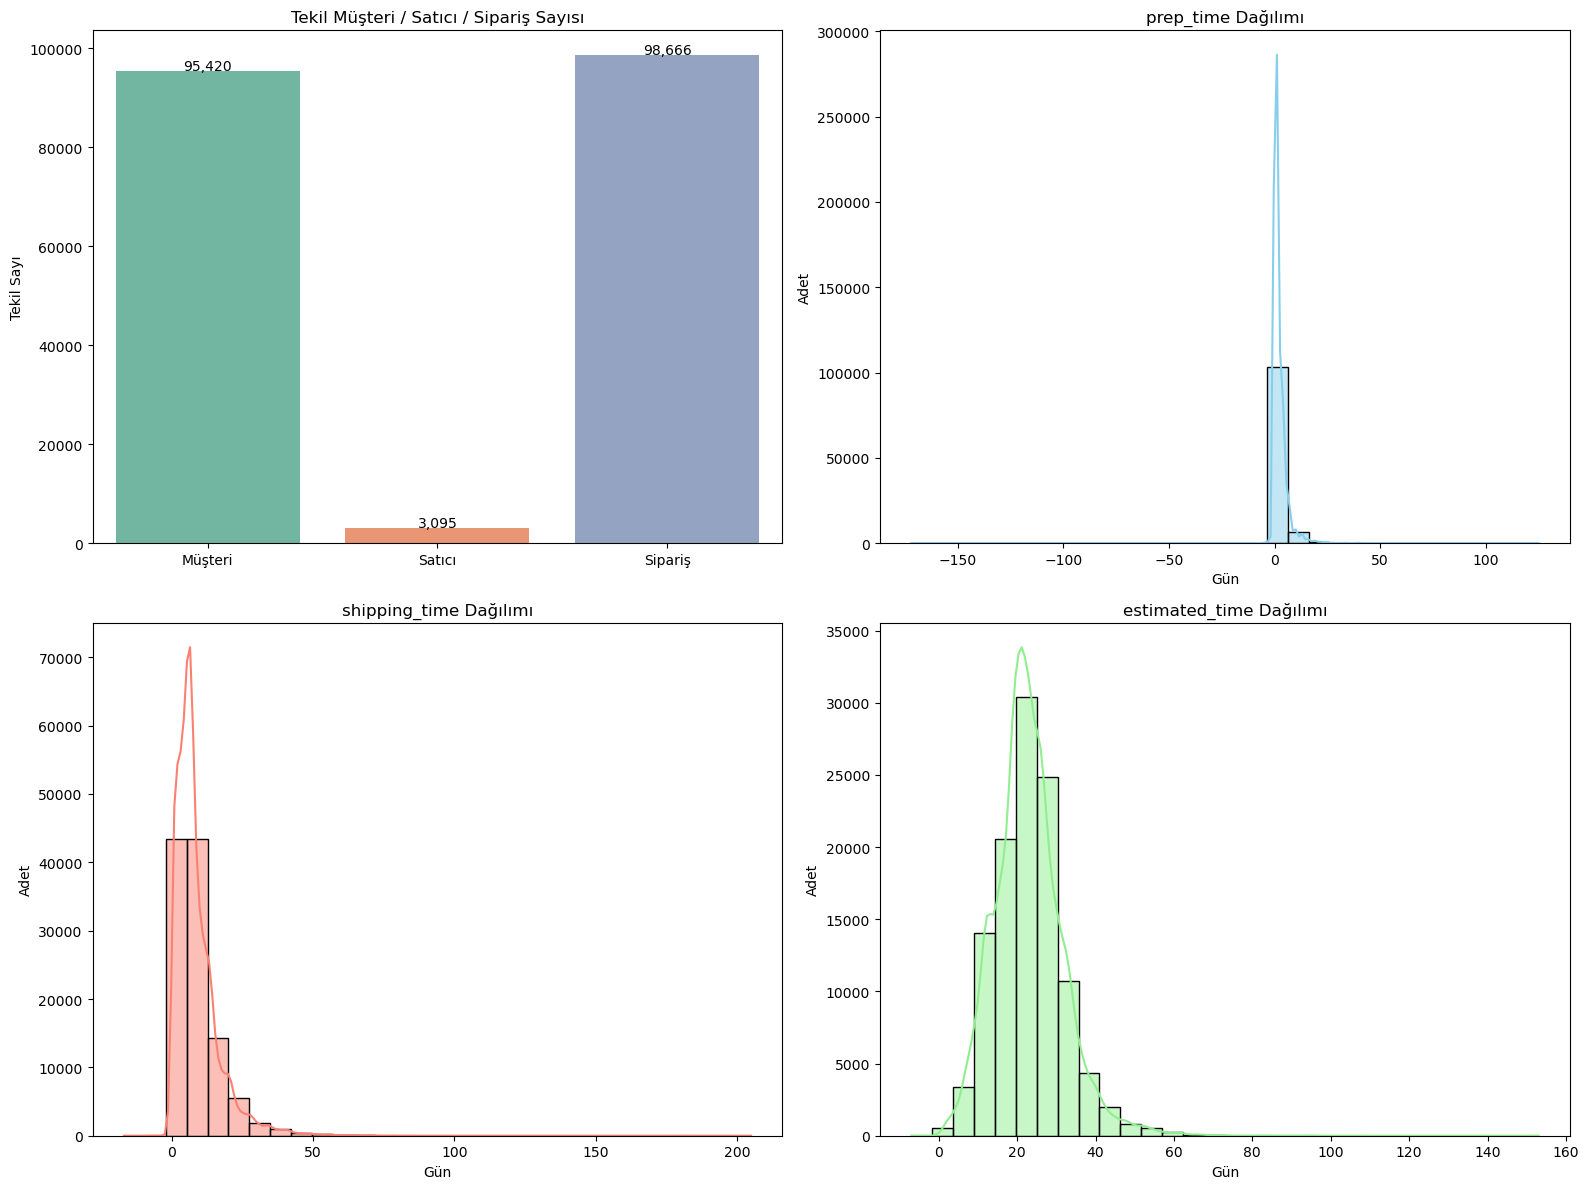

In [63]:
plt.figure(figsize=(16,12))

# --- 1. Tekil müşteri/satıcı/sipariş ---
plt.subplot(2,2,1)
sns.barplot(x=["Müşteri","Satıcı","Sipariş"], y=[cust_count,seller_count,order_count], palette="Set2")
plt.ylabel("Tekil Sayı")
plt.title("Tekil Müşteri / Satıcı / Sipariş Sayısı")
for i, v in enumerate([cust_count,seller_count,order_count]):
    plt.text(i, v + 100, f"{v:,}", ha='center')

# --- 2. prep_time ---
plt.subplot(2,2,2)
sns.histplot(fact_DF["prep_time"], kde=True, bins=30, color="skyblue")
plt.title("prep_time Dağılımı")
plt.xlabel("Gün")
plt.ylabel("Adet")

# --- 3. shipping_time ---
plt.subplot(2,2,3)
sns.histplot(fact_DF["shipping_time"], kde=True, bins=30, color="salmon")
plt.title("shipping_time Dağılımı")
plt.xlabel("Gün")
plt.ylabel("Adet")

# --- 4. estimated_time ---
plt.subplot(2,2,4)
sns.histplot(fact_DF["estimated_time"], kde=True, bins=30, color="lightgreen")
plt.title("estimated_time Dağılımı")
plt.xlabel("Gün")
plt.ylabel("Adet")

plt.tight_layout()
plt.show()

İlk Grafikte;

X ekseni: Müşteri, Satıcı ve Sipariş kategorilerini gösteriyor.
Y ekseni: Her bir kategorideki tekil (unique) sayıyı gösteriyor.

Grafikten çıkan sonuçlar:

Yaklaşık 95.000 farklı müşteri var yani sistemin çok geniş bir müşteri tabanı var
Yaklaşık 3.000 satıcı var yani müşteri sayısına göre satıcı sayısı oldukça az; yani satıcılar birçok farklı müşteriye hizmet veriyor.

Yaklaşık 99.000 sipariş var, sipariş sayısı müşteri sayısına yakın. Bu da çoğu müşterinin yalnızca 1 kez sipariş verdiğini düşündürüyor.

Yorum:
Bu dağılım, veri setinde müşteri ve sipariş çeşitliliğinin yüksek, ancak satıcı sayısının görece az olduğunu gösteriyor. Dolayısıyla satıcıların performans farklılıkları (örneğin teslim süresi, hazırlık süresi) müşteri deneyimini ve gecikmeleri doğrudan etkileyebilir.

* **prep_time (hazırlık süresi)** çoğunlukla 0–5 gün arasında yoğunlaşmış, ancak bazı uzun hazırlık süreleri de mevcut.
* **shipping_time (kargo süresi)** genellikle kısa (1–10 gün), ancak az sayıda uç değer çok uzun teslimat sürelerine işaret ediyor.
* **estimated_time (tahmini teslim süresi)** şirket tarafından verilen teslimat sürelerinin çoğunlukla 10–30 gün aralığında belirlendiğini göstermektedir.


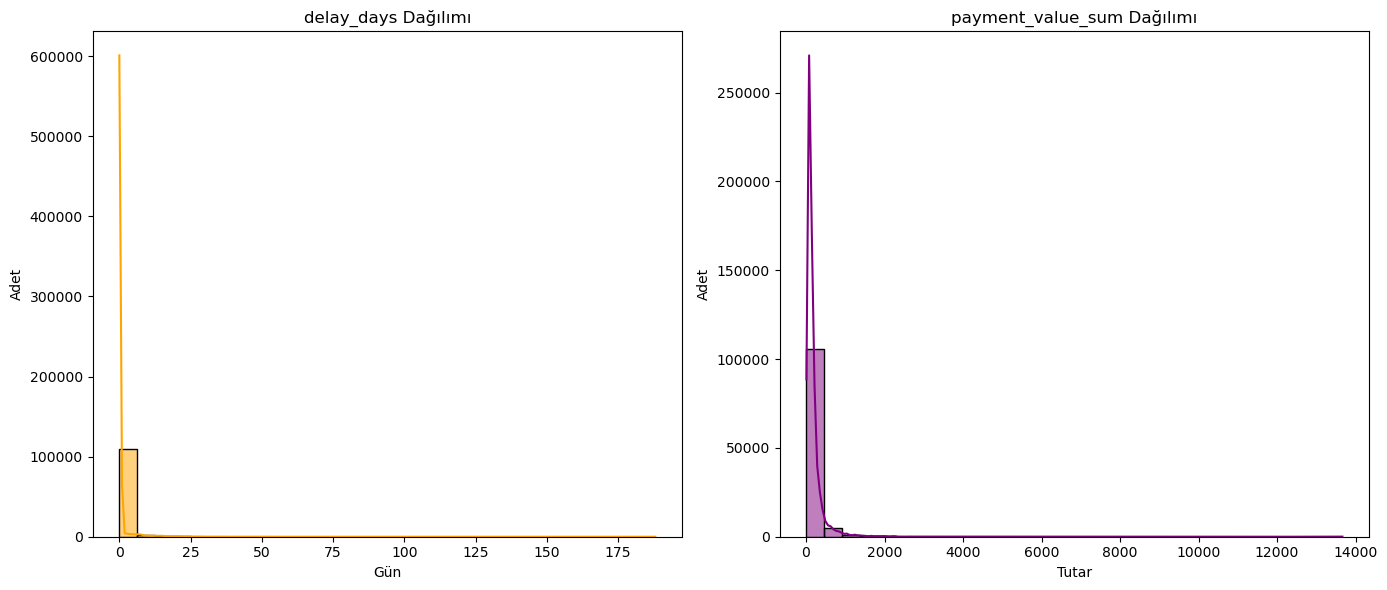

In [64]:
plt.figure(figsize=(14,6))

# --- 1. delay_days ---
plt.subplot(1,2,1)
sns.histplot(fact_DF["delay_days"], kde=True, bins=30, color="orange")
plt.title("delay_days Dağılımı")
plt.xlabel("Gün")
plt.ylabel("Adet")

# --- 2. payment_value_sum ---
plt.subplot(1,2,2)
sns.histplot(fact_DF["payment_value_sum"], kde=True, bins=30, color="purple")
plt.title("payment_value_sum Dağılımı")
plt.xlabel("Tutar")
plt.ylabel("Adet")

plt.tight_layout()
plt.show()

delay_days dağılımı incelendiğinde:
- Siparişlerin çok büyük çoğunluğu 0 gün gecikmeyle, yani zamanında teslim edilmiştir.
- Ancak az sayıda siparişte uzun gecikmeler (10 gün ve üzeri) gözlenmektedir.
- Bu uç değerler, modelin 'gecikme olasılığı' tahmininde kritik rol oynayacaktır.

payment_value_sum dağılımı incelendiğinde:
- Siparişlerin çoğu düşük tutarlarda yoğunlaşmıştır.
- Yüksek tutarlı siparişler azdır ve dağılımın kuyruğunu oluşturur.
- Bu durum, ödeme tutarının teslimat sürecindeki olası etkilerini test etmek için önemli bir değişken olduğuna işaret eder.

 Grup 3 – Zaman Bazlı Analiz

* 3.1. order_purchase_timestamp’tan yıl / ay / hafta çıkar
* 3.2. Zaman içinde toplam sipariş sayısını görselleştir
* 3.3. Zaman içinde gecikmeli sipariş sayısını görselleştir
* 3.4. Ortalama gecikmenin zaman içindeki trendini incele

In [65]:
print(fact_order_shipments["order_purchase_timestamp"].dtypes)
print(fact_order_shipments["order_purchase_timestamp"].head())

datetime64[ns]
0   2017-09-13 08:59:02
1   2017-04-26 10:53:06
2   2018-01-14 14:33:31
3   2018-08-08 10:00:35
4   2017-02-04 13:57:51
Name: order_purchase_timestamp, dtype: datetime64[ns]


### Zaman Serisi Analizleri (Time-based Analysis)

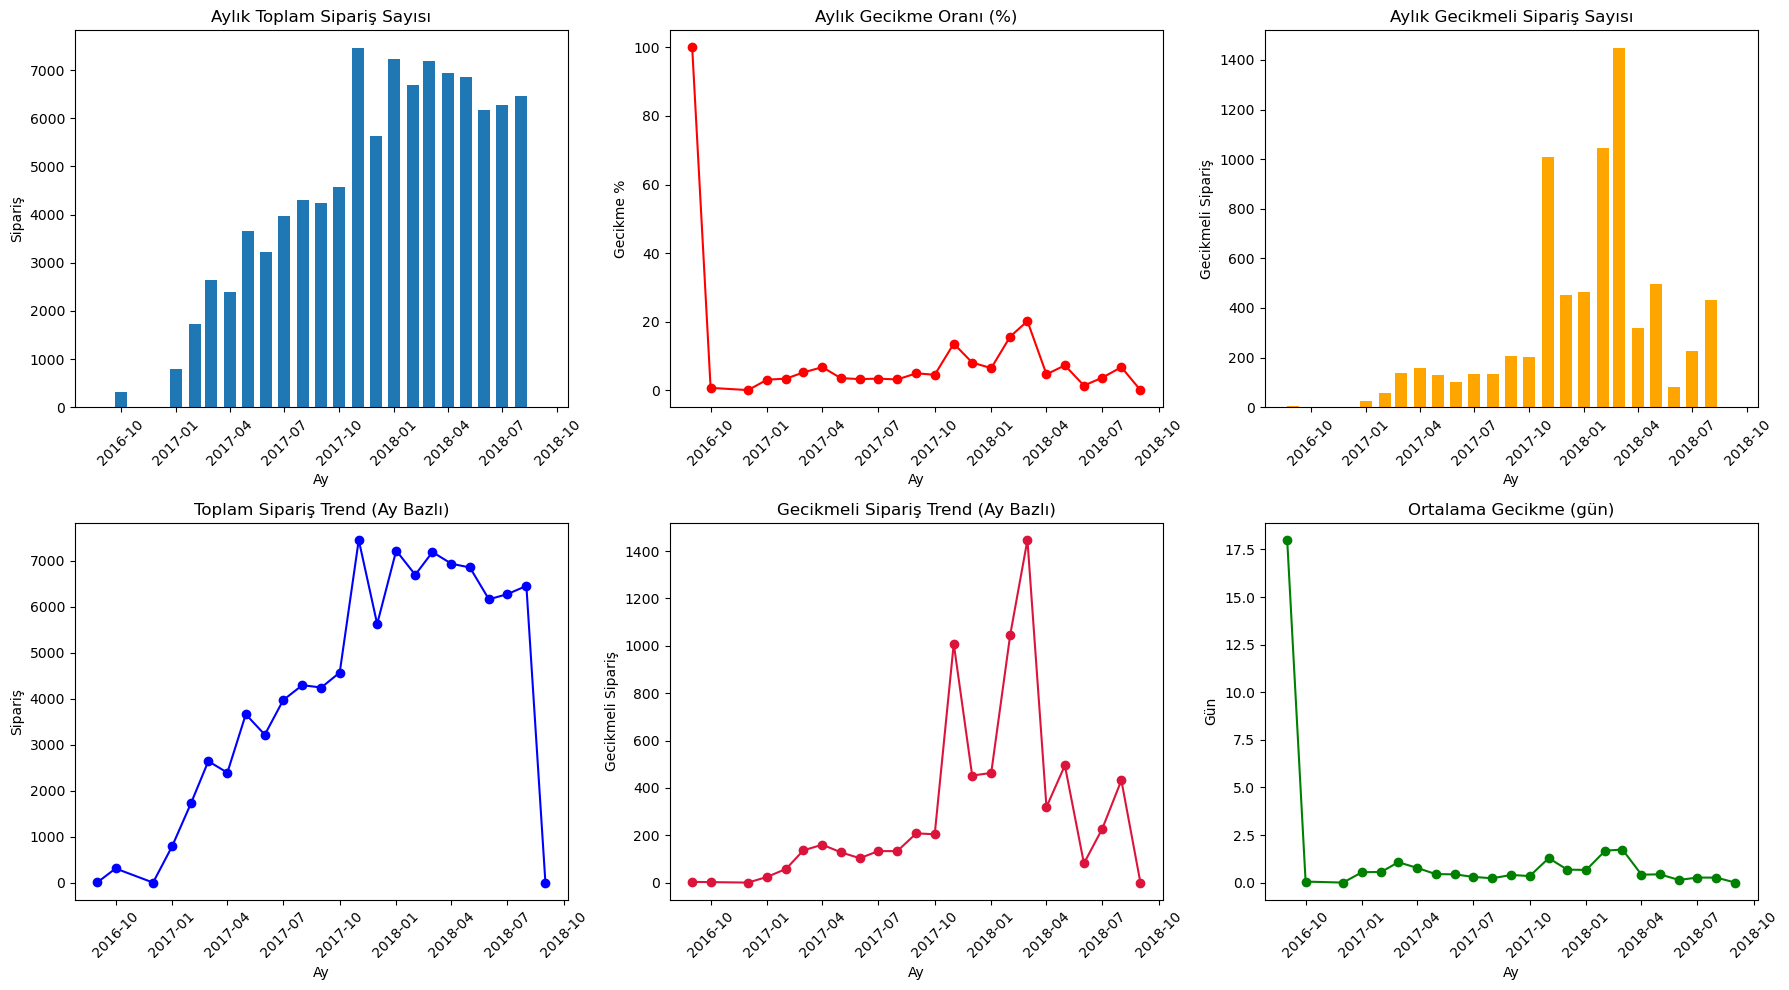

In [66]:
fact_order_shipments = fact_order_shipments.copy()
fact_order_shipments["order_purchase_timestamp"] = pd.to_datetime(
    fact_order_shipments["order_purchase_timestamp"], errors="coerce"
)
fact_order_shipments["year"]  = fact_order_shipments["order_purchase_timestamp"].dt.year
fact_order_shipments["month"] = fact_order_shipments["order_purchase_timestamp"].dt.month
fact_order_shipments["week"]  = fact_order_shipments["order_purchase_timestamp"].dt.isocalendar().week

# Aylık toplam ve gecikmeli siparişler
monthly = (
    fact_order_shipments
    .groupby(["year","month"])
    .agg(total_orders=("order_id_pref","nunique"),
         late_orders=("is_late","sum"),
         avg_delay=("delay_days","mean"))
    .reset_index()
)
monthly["late_pct"] = (monthly["late_orders"] / monthly["total_orders"]) * 100
monthly["date"] = pd.to_datetime(monthly[["year","month"]].assign(day=1))

# --- Çoklu Grafik Tablosu (2x3) ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()  # kolay erişim

# 1) Aylık toplam siparişler
axes[0].bar(monthly["date"], monthly["total_orders"], width=20)
axes[0].set_title("Aylık Toplam Sipariş Sayısı")
axes[0].set_xlabel("Ay"); axes[0].set_ylabel("Sipariş")

# 2) Aylık gecikme oranı (%)
axes[1].plot(monthly["date"], monthly["late_pct"], marker="o", color="red")
axes[1].set_title("Aylık Gecikme Oranı (%)")
axes[1].set_xlabel("Ay"); axes[1].set_ylabel("Gecikme %")

# 3) Aylık gecikmeli sipariş adedi
axes[2].bar(monthly["date"], monthly["late_orders"], width=20, color="orange")
axes[2].set_title("Aylık Gecikmeli Sipariş Sayısı")
axes[2].set_xlabel("Ay"); axes[2].set_ylabel("Gecikmeli Sipariş")

# 4) Toplam sipariş trendi (çizgi)
axes[3].plot(monthly["date"], monthly["total_orders"], marker="o", color="blue")
axes[3].set_title("Toplam Sipariş Trend (Ay Bazlı)")
axes[3].set_xlabel("Ay"); axes[3].set_ylabel("Sipariş")

# 5) Gecikmeli sipariş trendi (adet + % etiket)
axes[4].plot(monthly["date"], monthly["late_orders"], marker="o", color="crimson")
axes[4].set_title("Gecikmeli Sipariş Trend (Ay Bazlı)")
axes[4].set_xlabel("Ay"); axes[4].set_ylabel("Gecikmeli Sipariş")

# 6) Ortalama gecikme (gün)
axes[5].plot(monthly["date"], monthly["avg_delay"], marker="o", color="green")
axes[5].set_title("Ortalama Gecikme (gün)")
axes[5].set_xlabel("Ay"); axes[5].set_ylabel("Gün")

# X‐etiketlerinin okunabilirliği
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Aylık Sipariş ve Gecikme Analizi – Yorumlar

**1. Sipariş Hacmi (Üst sol & Alt sol grafikler)**  
- 2016’nın sonlarında çok düşük seviyede olan sipariş hacmi, 2017 boyunca istikrarlı bir artış göstermiştir.  
- 2017 sonu – 2018 başında zirveye çıkmış (~7000+ sipariş), sonrasında ise kısmi dalgalanmalarla biraz azalmıştır.  
- Bu durum platformun müşteri kazanımında hızlı bir büyüme dönemi yaşadığını, ardından doygunluğa ulaştığını düşündürmektedir.  

**2. Gecikme Oranı (Üst orta grafik)**  
- 2016’da çok az sipariş olduğu için gecikme oranı %100 çıkmıştır (istatistiksel olarak anlamlı değil).  
- 2017’de gecikme oranları genelde düşük (%2–5 civarı).  
- 2018’in başlarında (özellikle Ocak–Mart döneminde) gecikme oranlarında belirgin bir sıçrama (%15–20 civarı) görülmektedir. Bu dönem operasyonel darboğaz veya lojistik kapasite sorunlarını işaret ediyor olabilir.  

**3. Gecikmeli Sipariş Sayısı (Üst sağ & Alt orta grafikler)**  
- 2017’de hacim artışına paralel olarak gecikmeli sipariş sayısı da artmıştır, ancak düşük seviyelerde kalmıştır.  
- 2018’de hem sipariş hacmi yüksek hem de gecikme oranı arttığı için, gecikmeli sipariş adedi ciddi şekilde yükselmiştir (1400+ sipariş/ay).  
- Bu, kapasite büyümesine rağmen süreçlerin aynı hızla gelişmediğini göstermektedir.  

**4. Ortalama Gecikme Günleri (Alt sağ grafik)**  
- İlk aylardaki uç değerler dışında, gecikme süresi genellikle 0–2 gün arasında kalmıştır.  
- Yani gecikmelerin çoğu çok uzun değildir, fakat 2018 başında hem oran hem adet artınca operasyonel etki büyümüştür.  

---

**Sonuç:**  
- Platform büyüdükçe sipariş hacmi artmış, ancak 2018 başında teslimat performansında sorunlar yaşanmıştır.  
- Ortalama gecikme günleri düşük olduğu için gecikmeler genellikle kısa süreli olmuş, fakat oranlardaki artış müşteri memnuniyetini olumsuz etkilemiş olabilir.  
- Bu analiz, özellikle 2018 başındaki lojistik darboğazın kök neden analizi için önemli bir içgörü sunmaktadır.  


Dipnot: 

- **Resmi Tatiller:** Brezilya’da yıl içinde çok sayıda resmi tatil bulunmaktadır (örneğin Karnaval, Paskalya, Bağımsızlık Günü). Tatil dönemlerinde lojistik gecikmelerin artması olasıdır.  
- **2018 Kamyoncu Grevi:** Mayıs 2018’de Brezilya’da ülke çapında büyük bir kamyoncu grevi yaşanmıştır. Bu olay, e-ticaret lojistiğini doğrudan etkileyerek teslimat sürelerinde ciddi gecikmelere yol açmıştır.  
- Analiz sonuçlarında özellikle 2018’in ilk yarısında artan gecikmelerin bu tür makro olaylarla ilişkisi ayrıca incelenmelidir.  

Grev dönemindeki sipariş sayısı: 1751
Grev döneminde gecikme oranı: %2.46
Grev döneminde ortalama shipping_time: 8.79 gün
Grev dışı gecikme oranı: %6.51
Grev dışı ortalama shipping_time: 8.73 gün


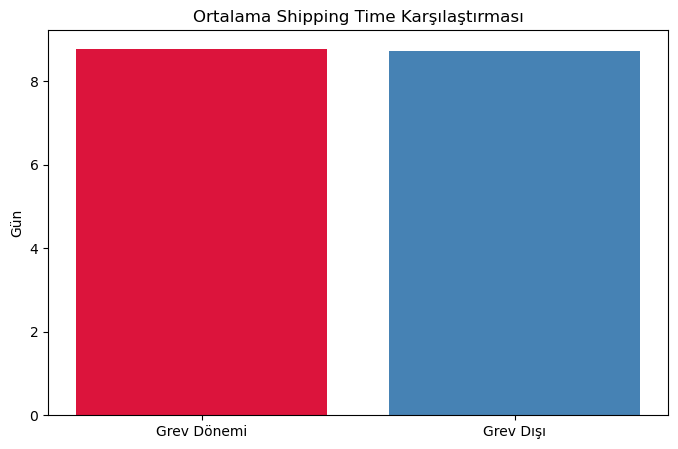

In [67]:
# Grev dönemi tarih aralığı
start = pd.to_datetime("2018-05-21")
end   = pd.to_datetime("2018-06-01")

# Grev dönemi siparişlerini seç
strike_orders = fact_order_shipments[
    (fact_order_shipments["order_purchase_timestamp"] >= start) &
    (fact_order_shipments["order_purchase_timestamp"] <= end)
]

print("Grev dönemindeki sipariş sayısı:", strike_orders.shape[0])

# 1) Gecikme oranı
late_strike = strike_orders["is_late"].mean() * 100
print(f"Grev döneminde gecikme oranı: %{late_strike:.2f}")

# 2) Ortalama shipping_time
avg_ship_strike = strike_orders["shipping_time"].mean()
print(f"Grev döneminde ortalama shipping_time: {avg_ship_strike:.2f} gün")

# 3) Karşılaştırma için grev dışı siparişler
non_strike_orders = fact_order_shipments[
    ~((fact_order_shipments["order_purchase_timestamp"] >= start) &
      (fact_order_shipments["order_purchase_timestamp"] <= end))
]

late_non_strike = non_strike_orders["is_late"].mean() * 100
avg_ship_non_strike = non_strike_orders["shipping_time"].mean()

print(f"Grev dışı gecikme oranı: %{late_non_strike:.2f}")
print(f"Grev dışı ortalama shipping_time: {avg_ship_non_strike:.2f} gün")

# 4) Görselleştirme
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(["Grev Dönemi", "Grev Dışı"], 
        [avg_ship_strike, avg_ship_non_strike], color=["crimson","steelblue"])
plt.title("Ortalama Shipping Time Karşılaştırması")
plt.ylabel("Gün")
plt.show()

### Target Kolonlarının Ayrıştırılması

Modelleme sürecinde hedef kolonların (*is_late*, *delay_class*, *delay_days*) doğrudan özellik matriksine (X) dahil edilmesi bilgi sızıntısına yol açar.  

Bu nedenle:  
- Hedef kolon ayrılır (*y*),  
- X’ten çıkarılır,  
- Train/test ayrımı yapılır,  
- Eksik değer ve zaman türevleri işlenir.  


Grafikten grevin etkisi dataset’e yansımamış olduğu görülüyor. Veri kaynağı temizlenmiş olabilir, ya da etkisi çok sınırlı kalmış (örneğin sadece belli eyaletleri ya da küçük bir satıcı grubunu vurmuş).
Bu yüzden genel seviyede gecikmeye yol açmamış görünüyor.
Böylece modelimizin eğitiminde Grev etkisi dışlanmış oluyor

## Gecikme Analizi

In [68]:
# Toplam gecikmeli sipariş sayısını hesapla
total_late_orders = fact_order_shipments['is_late'].sum()
print("Toplam gecikmeli sipariş sayısı:", total_late_orders)

Toplam gecikmeli sipariş sayısı: 7265


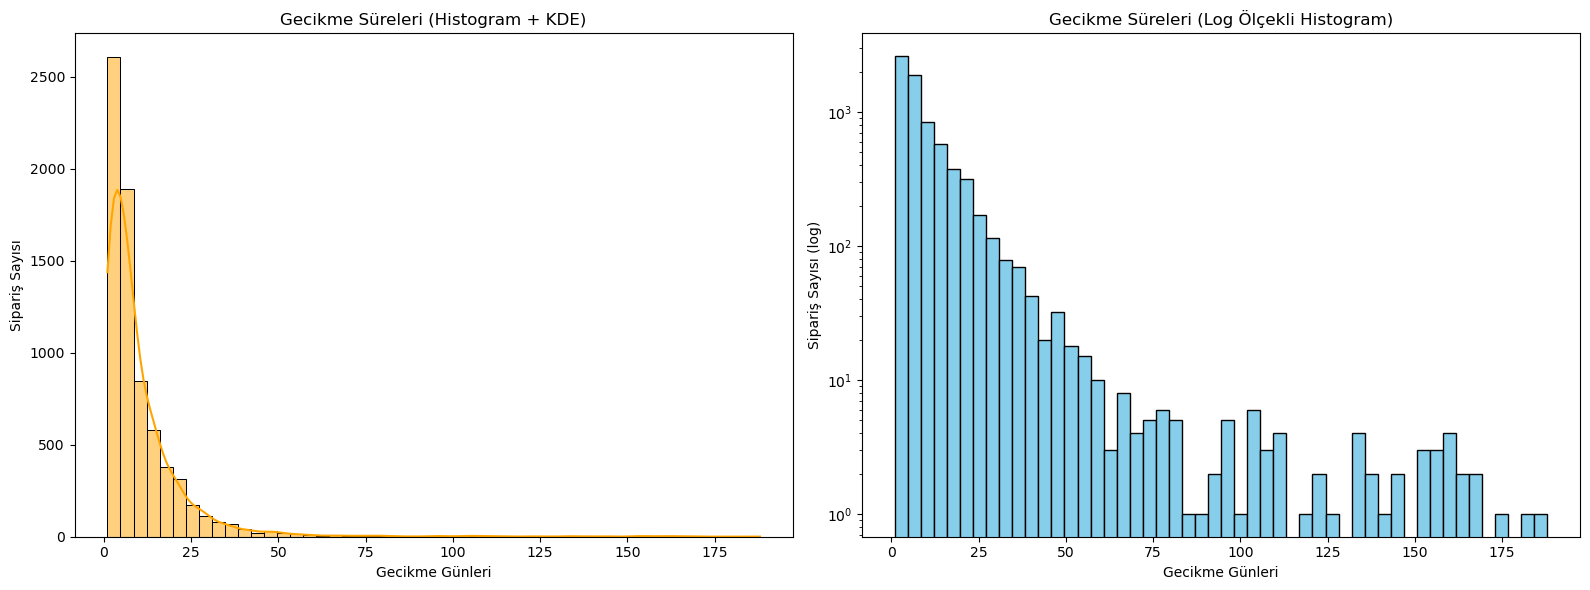

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Histogram + KDE ---
sns.histplot(late_orders['delay_days'], bins=50, kde=True, color="orange", edgecolor="black", ax=axes[0])
axes[0].set_xlabel("Gecikme Günleri")
axes[0].set_ylabel("Sipariş Sayısı")
axes[0].set_title("Gecikme Süreleri (Histogram + KDE)")

# --- Log-Scale Histogram ---
axes[1].hist(late_orders['delay_days'], bins=50, edgecolor='black', color="skyblue")
axes[1].set_yscale("log")
axes[1].set_xlabel("Gecikme Günleri")
axes[1].set_ylabel("Sipariş Sayısı (log)")
axes[1].set_title("Gecikme Süreleri (Log Ölçekli Histogram)")

plt.tight_layout()
plt.show()

Yukarıdaki grafikler gecikme günlerinin dağılımını farklı bakış açılarıyla göstermektedir:  

- **Histogram + KDE (sol)**: Siparişlerin büyük çoğunluğu kısa süreli gecikmelerde (1–5 gün) yoğunlaşmaktadır. Yoğunluk eğrisi, dağılımın çan eğrisi benzeri bir yapıya sahip olduğunu ortaya koymaktadır.  
- **Log ölçekli histogram (sağ)**: Uzun süreli gecikmeler (50+ gün) az sayıda olsa da mevcut olup, log ölçek sayesinde bu uç değerlerin görünürlüğü artmaktadır.  

Bu analiz, modelleme sürecinde “kısa gecikmeler” ile “aşırı gecikmeler”in farklı şekilde ele alınması gerektiğini göstermektedir.


### Gecikme günleri dağılımı – Boxplot

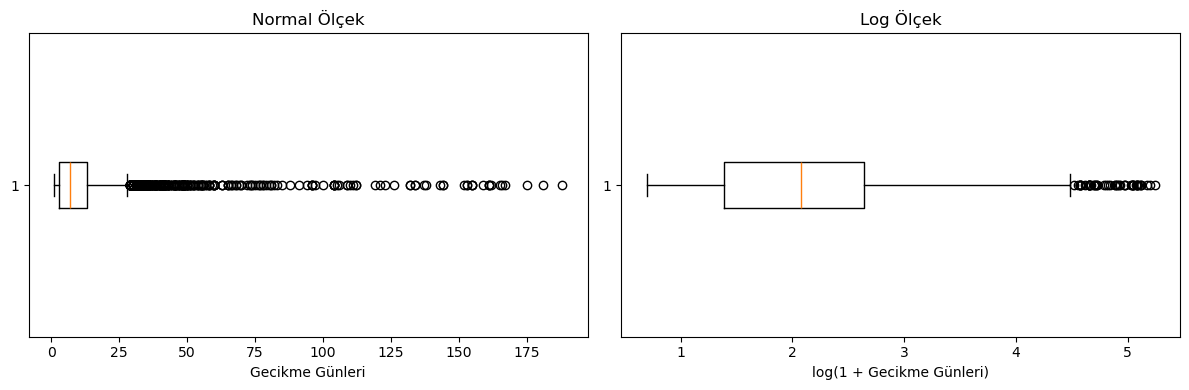

In [70]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Normal boxplot
axes[0].boxplot(late_orders['delay_days'], vert=False)
axes[0].set_xlabel("Gecikme Günleri")
axes[0].set_title("Normal Ölçek")

# Log(1+x) boxplot
axes[1].boxplot(np.log1p(late_orders['delay_days']), vert=False)
axes[1].set_xlabel("log(1 + Gecikme Günleri)")
axes[1].set_title("Log Ölçek")

plt.tight_layout()
plt.show()

NYukarıdaki grafiklerde gecikme günlerinin dağılımı normal ve log ölçekli olarak karşılaştırılmıştır.  
Normal ölçekte, siparişlerin büyük çoğunluğu 0–20 gün arasında gecikmiş olsa da 100+ gün gibi uç değerler nedeniyle dağılımın büyük kısmı sıkışık görünmektedir. Bu grafik uç değerlerin varlığını tespit etmek için faydalıdır.  

Log dönüşümlü ölçekte ise uç değerlerin etkisi azaltılarak dağılım daha dengeli bir şekilde görülmektedir. Böylece tipik gecikme aralıkları (örneğin 1–15 gün) daha net analiz edilebilmektedir.  

Makine öğrenmesi uygulamalarında log dönüşümü, aşırı uçlardan kaynaklanan dengesizliği azaltarak modelin daha sağlıklı öğrenmesine yardımcı olabilir.


#### Özet istatistikler (ortalama, medyan, min, max)

In [71]:
mean_delay = late_orders['delay_days'].mean()
median_delay = late_orders['delay_days'].median()
min_delay = late_orders['delay_days'].min()
max_delay = late_orders['delay_days'].max()

print("Ortalama gecikme süresi:", mean_delay)
print("Medyan gecikme süresi:", median_delay)
print("Minimum gecikme süresi:", min_delay)
print("Maksimum gecikme süresi:", max_delay)

Ortalama gecikme süresi: 10.488781830695114
Medyan gecikme süresi: 7.0
Minimum gecikme süresi: 1.0
Maksimum gecikme süresi: 188.0


##  Müşteri, Satıcı ve Ürün Bazında Analiz

#### 1. Müşteri başına ortalama gecikme süresi

In [72]:
# Sadece gecikmesi olan siparişleri filtreleyelim
late_orders = fact_order_shipments[fact_order_shipments['delay_days'] > 0]

In [73]:
customer_delay_mean = late_orders.groupby("cusUni")["delay_days"].mean().reset_index()
customer_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
customer_delay_mean["avg_delay_days"] = customer_delay_mean["avg_delay_days"].astype(int)
customer_delay_mean.head()

,cusUni,avg_delay_days
0,CUSUNI0003,1
1,CUSUNI0019,8
2,CUSUNI0033,37
3,CUSUNI0060,15
4,CUSUNI0090,28


#### 2. Müşteri başına gecikmeli sipariş sayısı

In [74]:
customer_delay_count = late_orders.groupby("cusUni")["order_id_pref"].nunique().reset_index()
customer_delay_count.rename(columns={"order_id_pref": "late_order_count"}, inplace=True)
customer_delay_count.head()

,cusUni,late_order_count
0,CUSUNI0003,1
1,CUSUNI0019,1
2,CUSUNI0033,1
3,CUSUNI0060,1
4,CUSUNI0090,1


#### 3. En yüksek ortalama gecikmeye sahip müşteriler (ilk 10)

In [75]:
top_customers = customer_delay_mean.sort_values("avg_delay_days", ascending=False).head(10)
top_customers

,cusUni,avg_delay_days
4494,CUSUNI68968,188
1385,CUSUNI27483,181
4365,CUSUNI67222,175
3266,CUSUNI51868,167
946,CUSUNI21621,166
2058,CUSUNI3595,165
6047,CUSUNI90158,162
3531,CUSUNI55565,161
4465,CUSUNI68602,161
4328,CUSUNI66759,159


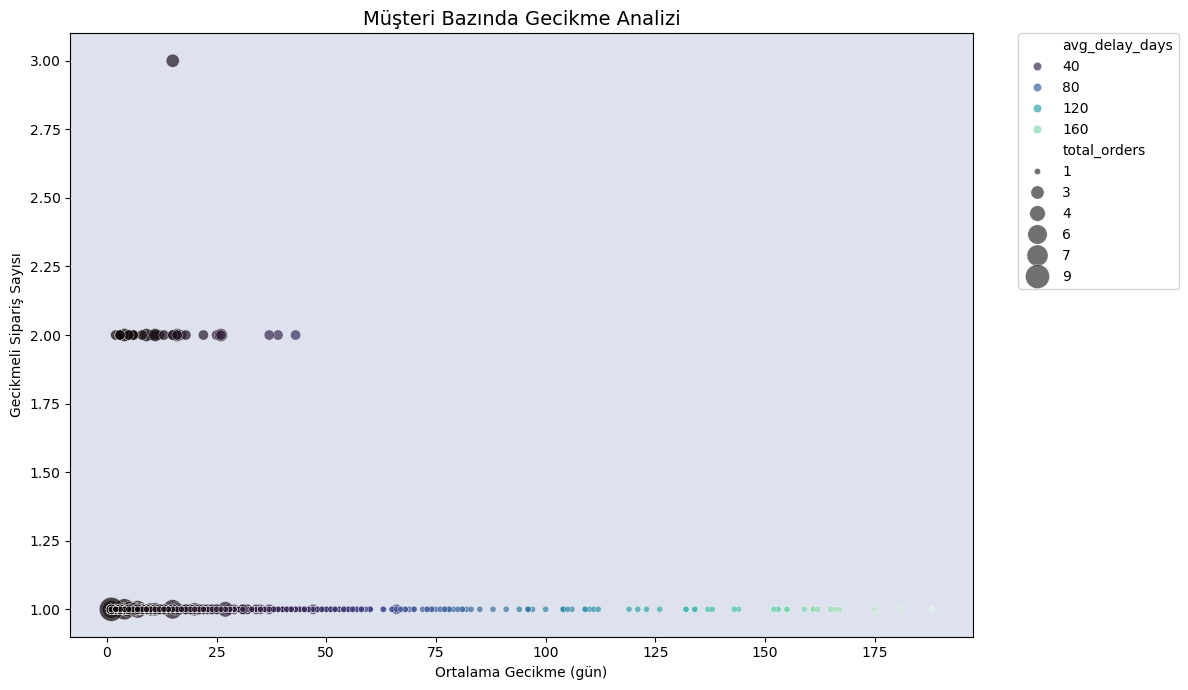

In [76]:
# Ortalama gecikme ve gecikmeli sipariş sayısı
customer_delay_stats = (
    late_orders.groupby("cusUni")
    .agg(
        avg_delay_days=("delay_days", "mean"),
        late_order_count=("order_id_pref", "nunique")
    )
    .reset_index()
)

#toplam sipariş sayısı (gecikmeli + zamanında)
total_orders_customer = (
    fact_order_shipments.groupby("cusUni")["order_id_pref"].nunique().reset_index()
    .rename(columns={"order_id_pref": "total_orders"})
)

# Merge
customer_delay_stats = customer_delay_stats.merge(total_orders_customer, on="cusUni", how="left")

# Müşteri bazında toplam sipariş sayısı
customer_total_orders = fact_order_shipments.groupby("cusUni")["order_id_pref"].nunique().reset_index()
customer_total_orders.rename(columns={"order_id_pref": "total_orders"}, inplace=True)

# Gecikme ortalaması + gecikmeli sipariş sayısı ile birleştirme
customer_summary = (
    customer_delay_mean
    .merge(customer_delay_count, on="cusUni")
    .merge(customer_total_orders, on="cusUni")
)

# Grafik
fig, ax = plt.subplots(figsize=(12,7))

sns.scatterplot(
    data=customer_summary,
    x="avg_delay_days", 
    y="late_order_count",
    size="total_orders",   # artık mevcut
    hue="avg_delay_days", 
    sizes=(20, 300),
    palette="mako",  
    alpha=0.7,
    ax=ax
)

# Arka plan
ax.set_facecolor("#DEE1EE")
fig.patch.set_facecolor("#ffffff")

ax.set_title("Müşteri Bazında Gecikme Analizi", fontsize=14)
ax.set_xlabel("Ortalama Gecikme (gün)")
ax.set_ylabel("Gecikmeli Sipariş Sayısı")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()


- **X ekseni (ortalama gecikme günleri):** Sağ tarafa doğru ilerledikçe, siparişleri daha uzun süre geciken müşteriler görülmektedir. 150+ gün gecikmeye kadar çıkan uç noktalar vardır.  

- **Y ekseni (gecikmeli sipariş sayısı):** Çoğu müşteri yalnızca **1 gecikmeli sipariş** yaşamıştır. 2–3 gecikmeli sipariş yaşayan müşteri sayısı oldukça azdır.  

- **Balon büyüklüğü (toplam sipariş sayısı):** Daha büyük balonlar, toplamda daha fazla sipariş veren müşterileri göstermektedir. Büyük hacimli müşterilerin ortalama gecikmeleri genellikle 0–50 gün aralığında kalmıştır.  

- **Renk (ortalama gecikme yoğunluğu):** Açık renkten koyuya doğru ilerledikçe ortalama gecikme süresi artmaktadır. Daha koyu renkler (örn. mavi tonları) kullanılarak görselleştirme daha okunaklı hale getirilebilir.  

**Özetle:**  
- Gecikmelerin büyük çoğunluğu tek seferliktir; sistematik bir tekrar söz konusu değildir.  
- Çok uzun gecikmeler yaşayan müşteriler vardır, ancak bunlar sayıca azdır.  
- Yüksek hacimli müşteriler sistematik olarak uzun gecikmeler yaşamamaktadır. Bu durum, lojistik sorunların genellikle bireysel siparişlerde ortaya çıktığını düşündürmektedir.  

#### 4. Satıcı başına ortalama gecikme süresi

In [77]:
seller_delay_mean = late_orders.groupby("seller_id_pref")["delay_days"].mean().reset_index()
seller_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
seller_delay_mean.head()

,seller_id_pref,avg_delay_days
0,SEL001,3.000
1,SEL002,1.000
2,SEL005,7.000
3,SEL009,6.500
4,SEL010,17.583


#### 5. Tek satıcılı vs çok satıcılı siparişlerde gecikme karşılaştırması

In [78]:
# Her siparişin kaç farklı satıcı içeriyor:
order_seller_counts = fact_order_shipments.groupby("order_id_pref")["seller_id_pref"].nunique().reset_index()
order_seller_counts.rename(columns={"seller_id_pref": "seller_count"}, inplace=True)

# Gecikme bilgisi ile birlikte:
order_delay = fact_order_shipments.groupby("order_id_pref")["delay_days"].mean().reset_index()
order_seller_delay = order_delay.merge(order_seller_counts, on="order_id_pref")

# Tek satıcılı ve çok satıcılı siparişleri karşılaştırmasi:
comparison = order_seller_delay.groupby("seller_count")["delay_days"].mean().reset_index()
comparison

,seller_count,delay_days
0,1,0.712
1,2,0.044
2,3,0.000
3,4,0.000
4,5,0.000


#### 6. En yüksek ortalama gecikmeye sahip satıcılar (ilk 10)

In [79]:
# 1. Satıcı bazında ortalama gecikme + toplam sipariş + geciken sipariş
seller_stats = (
    fact_order_shipments
    .groupby("seller_id_pref")
    .agg(
        avg_delay_days=("delay_days", "mean"),
        total_orders=("order_id_pref", "nunique"),
        late_orders=("is_late", "sum")
    )
    .reset_index()
)

# 2. Gecikme oranı (%)
seller_stats["late_ratio"] = (seller_stats["late_orders"] / seller_stats["total_orders"] * 100).round(2)

# 3. En çok gecikmeye sahip ilk 10 satıcı (ortalama gecikmeye göre)
top_sellers = seller_stats.sort_values("avg_delay_days", ascending=False).head(10)

print("Top 10 satıcı (ortalama gecikme gününe göre):")
print(top_sellers)

Top 10 satıcı (ortalama gecikme gününe göre):
     seller_id_pref  avg_delay_days  total_orders  late_orders  late_ratio
2223        SEL2930         167.000             1            1     100.000
1862        SEL2602          44.667             3            1      33.330
1497        SEL2270          35.000             1            1     100.000
102         SEL1002          33.000             1            1     100.000
2366        SEL3060          23.500             2            2     100.000
1515        SEL2287          23.000             5            3      60.000
919         SEL1745          22.750             3            1      33.330
2336        SEL3033          22.000             1            2     200.000
561          SEL142          21.667             3            1      33.330
171         SEL1065          21.000             2            1      50.000


Text(0.5, 1.0, 'Satıcı Bazında Gecikme Performansı')

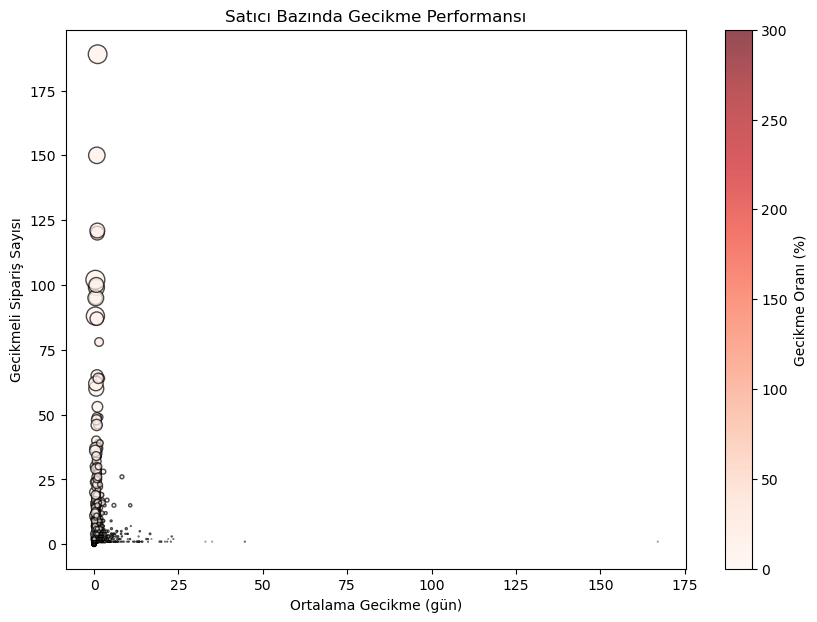

In [80]:
plt.figure(figsize=(10,7))

scatter = plt.scatter(
    x=seller_stats["avg_delay_days"],
    y=seller_stats["late_orders"],
    s=seller_stats["total_orders"] * 0.1,   # nokta boyutu (sipariş hacmine göre)
    c=seller_stats["late_ratio"],           # renk (gecikme oranı %)
    cmap="Reds",
    alpha=0.7,
    edgecolor="k"
)

plt.colorbar(scatter, label="Gecikme Oranı (%)")
plt.xlabel("Ortalama Gecikme (gün)")
plt.ylabel("Gecikmeli Sipariş Sayısı")
plt.title("Satıcı Bazında Gecikme Performansı")

### Satıcı Bazlı Gecikme Bulguları

1. **Top 10 satıcı listesinde** dikkat çeken durum, bazı satıcıların çok az siparişine rağmen (hatta tek sipariş) çok yüksek gecikme günleri üretmiş olmasıydı. Hatta bir örnekte aynı siparişe iki gecikme kaydı düşmesi gibi veri tutarsızlıkları görüldü. Bu satıcıların yüksek ortalama gecikme değerleri, aslında küçük sipariş hacminden kaynaklanan istatistiksel sapmalardan ileri geliyor.  

2. **Balon grafiğinde** de görüldüğü üzere:  
   - Çoğu satıcı **ortalama 0–10 gün** bandında yoğunlaşmış durumda.  
   - Aşırı yüksek gecikme değerleri (100+ gün) genellikle **çok az siparişe sahip satıcılar** tarafından üretilmiş. Bu durum **outlier** etkisi yaratıyor.  
   - Daha yüksek sipariş hacmine sahip satıcılar ise daha istikrarlı sonuçlar vermekte.  

3. **Yorum:**  
   - Küçük hacimli satıcıların verisi ayrı incelenmeli, çünkü tekil siparişlerden dolayı model üzerinde orantısız etki yaratabilir.  
   - Daha güvenilir analiz için minimum sipariş eşiği (ör. ≥30 sipariş) belirlenmesi önerilir. Bu sayede “gerçekten problemli satıcılar” ile “veri gürültüsü” daha net ayrışır.  


In [81]:
# Satıcı bazında toplam sipariş ve geç sipariş
seller_perf = (
    fact_order_shipments.groupby("seller_id_pref")
    .agg(
        total_orders=("order_id_pref", "nunique"),
        late_orders=("is_late", "sum")
    )
    .reset_index()
)

seller_perf["late_ratio"] = (seller_perf["late_orders"] / seller_perf["total_orders"] * 100).round(2)

# En çok sipariş alan ilk 100 satıcı
top100_sellers = seller_perf.sort_values("total_orders", ascending=False).head(100)
print("En yüksek hacimli 10 satıcı:")
top10_high_volume = seller_perf.sort_values("total_orders", ascending=False).head(10)
print(top10_high_volume)



# Bu 100 satıcıdan kaçında gecikme var?
delayed_top100 = (top100_sellers["late_orders"] > 0).sum()
print("İlk 100 satıcının içinde en az 1 gecikme Oranı: %.2f%%" % (delayed_top100 / 100 * 100))






En yüksek hacimli 10 satıcı:
     seller_id_pref  total_orders  late_orders  late_ratio
2893         SEL798          1854          102       5.500
1710        SEL2464          1806          189      10.470
555         SEL1414          1706           88       5.160
2570         SEL475          1404          150      10.680
1061        SEL1874          1314           99       7.530
2486         SEL391          1287           95       7.380
1428        SEL2208          1160           60       5.170
3083         SEL988          1146          100       8.730
1879        SEL2618          1132          121      10.690
1580        SEL2346          1080           62       5.740
İlk 100 satıcının içinde en az 1 gecikme Oranı: 100.00%


#### 7. Ürün başına ortalama gecikme süresi

In [82]:
product_delay_mean = late_orders.groupby("product_id_pref")["delay_days"].mean().reset_index()
product_delay_mean.rename(columns={"delay_days": "avg_delay_days"}, inplace=True)
product_delay_mean.head()

,product_id_pref,avg_delay_days
0,PRO021,6.000
1,PRO027,7.000
2,PRO032,15.000
3,PRO034,13.000
4,PRO047,7.000


### Sipariş Gecikme Analizleri Dashboard

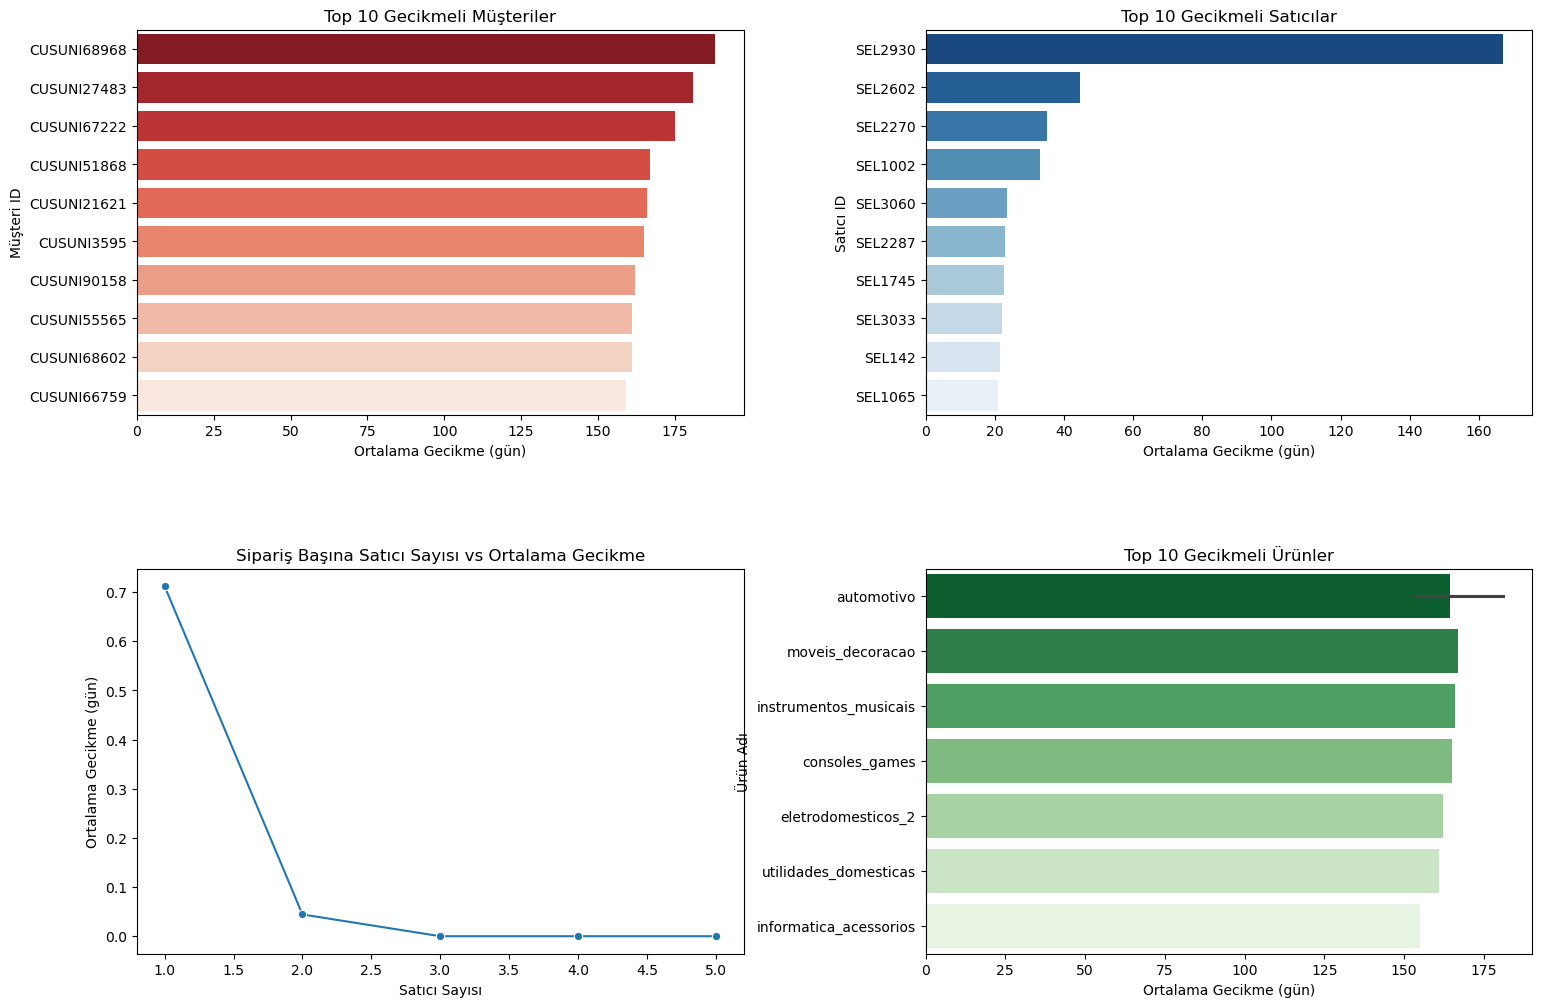

In [83]:
# Figure ve subplot yapısı (2 satır, 2 sütun)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1️ Top 10 gecikmeli müşteri
sns.barplot(
    data=top_customers,
    x="avg_delay_days",
    y="cusUni",
    palette="Reds_r",
    ax=axes[0,0]
)
axes[0,0].set_title("Top 10 Gecikmeli Müşteriler")
axes[0,0].set_xlabel("Ortalama Gecikme (gün)")
axes[0,0].set_ylabel("Müşteri ID")

# 2️ Top 10 gecikmeli satıcı
sns.barplot(
    data=top_sellers,
    x="avg_delay_days",
    y="seller_id_pref",
    palette="Blues_r",
    ax=axes[0,1]
)
axes[0,1].set_title("Top 10 Gecikmeli Satıcılar")
axes[0,1].set_xlabel("Ortalama Gecikme (gün)")
axes[0,1].set_ylabel("Satıcı ID")

# 3️ Sipariş başına satıcı sayısı vs ortalama gecikme
sns.lineplot(
    data=comparison,
    x="seller_count",
    y="delay_days",
    marker="o",
    ax=axes[1,0]
)
axes[1,0].set_title("Sipariş Başına Satıcı Sayısı vs Ortalama Gecikme")
axes[1,0].set_xlabel("Satıcı Sayısı")
axes[1,0].set_ylabel("Ortalama Gecikme (gün)")

# 4️ Top 10 gecikmeli ürün

# Top 10 gecikmeli ürün
top_products = product_delay_mean.sort_values("avg_delay_days", ascending=False).head(10)

# Ürün isimlerini product tablosundan çekelim
top_products = top_products.merge(df_products[['product_id_pref', 'product_category_name']], 
                                  on='product_id_pref', how='left')

# Barplot
sns.barplot(
    data=top_products,
    x="avg_delay_days",
    y="product_category_name",  # product_name yerine doğru kolon adı
    palette="Greens_r",
    ax=axes[1,1]
)
axes[1,1].set_title("Top 10 Gecikmeli Ürünler")
axes[1,1].set_xlabel("Ortalama Gecikme (gün)")
axes[1,1].set_ylabel("Ürün Adı")

plt.show()





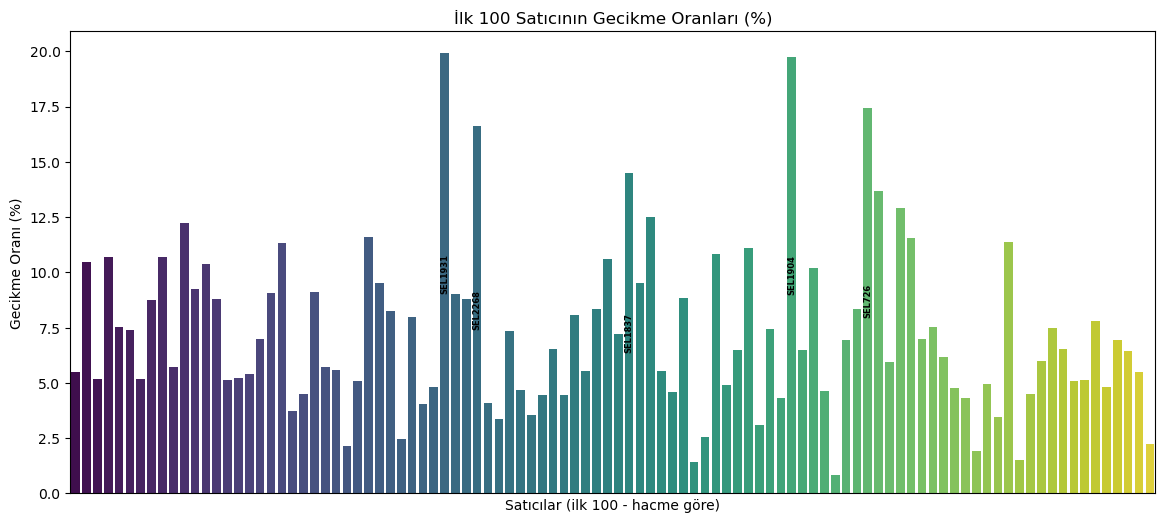

In [84]:
# İlk 100 satıcı (hacme göre)
top100_sellers = seller_perf.sort_values("total_orders", ascending=False).head(100)

# Bu 100 satıcı içinden gecikme oranı en yüksek 5'ini bul
top5_high_delay = top100_sellers.sort_values("late_ratio", ascending=False).head(5)

plt.figure(figsize=(14,6))
bars = sns.barplot(
    data=top100_sellers,
    x="seller_id_pref",
    y="late_ratio",
    palette="viridis"
)

# X eksenindeki tickleri gizle
plt.xticks([], [])

# Yalnızca en yüksek 5 gecikmeli satıcıya etiket ekle
for idx, row in top5_high_delay.iterrows():
    bar_index = top100_sellers.index.get_loc(idx)
    bar = bars.patches[bar_index]
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width()/2,   # X ortası
        height/2,                         # barın ortası
        row["seller_id_pref"], 
        ha="center", va="center",
        fontsize=6, rotation=90, color="black", fontweight="bold"
    )

plt.title("İlk 100 Satıcının Gecikme Oranları (%)")
plt.xlabel("Satıcılar (ilk 100 - hacme göre)")
plt.ylabel("Gecikme Oranı (%)")
plt.show()


### Büyük Satıcıların Gecikme Analizi

- **Top 100 satıcıdan %100’ünde en az bir gecikme var.** Yani hacmi yüksek satıcıların tamamı bir noktada geç teslimat yapmış.  

- Ancak **gecikme oranları genelde düşük**: İlk 10 satıcıda oranlar %5–11 bandında. Çok yüksek sipariş hacmi göz önünde bulundurulduğunda bu seviyeler makul kabul edilebilir.  

- **Kritik satıcılar** (ör. SEL1931, SEL2268, SEL726...) %15–20 seviyelerine yaklaşan oranlara sahip. Bu satıcılar operasyonel risk oluşturabilir.  

- **Çoğu büyük satıcıda gecikme oranı %10’un altında** ve bu da genel olarak güvenilir bir performansa işaret ediyor.  

#### Çıkarım
- **Yüksek hacimli satıcılar genellikle güvenilir**, çünkü çok sayıda siparişe rağmen düşük gecikme oranlarıyla çalışıyorlar.  
- Ancak **“yüksek hacim + yüksek gecikme”** grubundaki satıcılar ayrıca ele alınmalı ve operasyonel süreçleri iyileştirilmelidir.  
- Bu analiz, satıcı segmentasyonu için temel oluşturabilir:  
  - **Yüksek hacim + düşük gecikme**  Stratejik, güvenilir satıcılar  
  - **Yüksek hacim + yüksek gecikme**  İyileştirme odaklı satıcılar  

Raporun ana konusu bu olmadığı için bu içsel bilgiler sadece raporlanacaktır. ilerde şirket tarafından satıcı bazında bir iyileştirme yapılmak istenirse, ortalamanın üstünde gecikmeye sahip satıcılar ile iletişime geçilebilir. 

### Missing Values (Eksik Değerler)

Modelleme aşamasına geçmeden önce veri setinin güvenilirliğini ve dengeliliğini artırmak için kapsamlı bir veri temizleme süreci uygulanacaktır. Amaç, eksik ve hatalı kayıtların etkisini en aza indirerek istatistiksel analiz ve makine öğrenmesi algoritmaları için daha uygun bir temel oluşturmaktır.  

Bu kapsamda şu adımlar izlenecektir:  

1. **Eksik Değerlerin İşlenmesi**  
   - Tüm kolonlarda eksik değerler tespit edilerek sayısı ve oranı belirlenecektir.  
   - Eksik değer oranı düşük olan satırlar gerektiğinde silinecek, önemli kolonlarda ise eksik gözlemler bayrak değişkenleri (örn. *NA_FLAG*) ile işaretlenecektir.  
   - Sayısal kolonlarda (*prep_time*, *shipping_time*, *distance_km* vb.) eksik değerler medyan ile doldurulacak, çok az eksik değeri bulunan kategorik kolonlar (*payment_types* vb.) ise tamamen çıkarılacaktır.  

2. **Mantıksal Limitlerin Uygulanması**  
   - Negatif veya fiziksel olarak mümkün olmayan değerler alt limite eşitlenecektir (ör. teslimat süresi 0’dan küçük olamaz).  
   - Böylece tüm sayısal kolonlar mantıksal olarak geçerli aralıklara getirilecektir.  

3. **Aykırı Değer Analizi ve Düzenlenmesi**  
   - Çok değişkenli aykırılık analizi için **Local Outlier Factor (LOF)** yöntemi kullanılacaktır.  
   - Uç değerler silinmeyecek, bunun yerine **IQR yöntemi** ile belirlenen alt-üst limitlere eşitlenecektir.  
   - Böylece aşırı uç gözlemler veri dağılımını bozmayacak ancak tamamen de kaybolmayacaktır.  

4. **Sonuçların Kontrolü**  
   - Temizlik öncesi ve sonrası özet istatistikler karşılaştırılacak, negatif veya eksik değer kalmadığı doğrulanacaktır.  
   - Boxplot ve histogram grafiklerinde değişkenlerin dağılımı temizlik öncesi ve sonrası yan yana gösterilecektir.  

### Beklenen Sonuç
Bu adımların tamamlanmasıyla birlikte:  
- Veri seti eksik değerlerden arındırılmış,  
- Mantıksal olarak geçerli değer aralıklarına getirilmiş,  
- Aykırı değerlerin etkisi minimize edilmiş olacaktır.  

Elde edilen temiz veri seti, sonraki aşamalarda özellik mühendisliği, encoding ve modelleme için hazır bir temel sağlayacaktır.

In [85]:
fact_order_shipments.isnull().sum()

cusUni                              0
customer_order_id                   0
order_id_pref                       0
seller_id_pref                      0
product_id_pref                     0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
prep_time                        1209
shipping_time                    2455
estimated_time                     15
delay_days                          0
delay_class                         0
is_late                             0
distance_km                       554
payment_types                       3
payment_value_sum                   3
payment_installments_max            3
seller_count_per_order              0
year                                0
month                               0
week                                0
dtype: int64

### Missing Values Oranlari

In [86]:
# Eksik kolon isimlerini al
na_cols = utils.table_missing_values(fact_order_shipments, na_name=True)

# Eksik değer sayısı ve oranını hesapla
n_miss = fact_order_shipments[na_cols].isnull().sum().sort_values(ascending=False)
ratio = (fact_order_shipments[na_cols].isnull().sum() / fact_order_shipments.shape[0] * 100).sort_values(ascending=False)

# DataFrame oluştur
na_df = pd.DataFrame({
    "Kolon": n_miss.index,
    "EksikDegerSayisi": n_miss.values,
    "Oran": ratio.values
})





                               n_miss  ratio
shipping_time                    2455  2.180
order_delivered_customer_date    2454  2.180
prep_time                        1209  1.070
order_delivered_carrier_date     1194  1.060
distance_km                       554  0.490
order_approved_at                  15  0.010
estimated_time                     15  0.010
payment_types                       3  0.000
payment_value_sum                   3  0.000
payment_installments_max            3  0.000


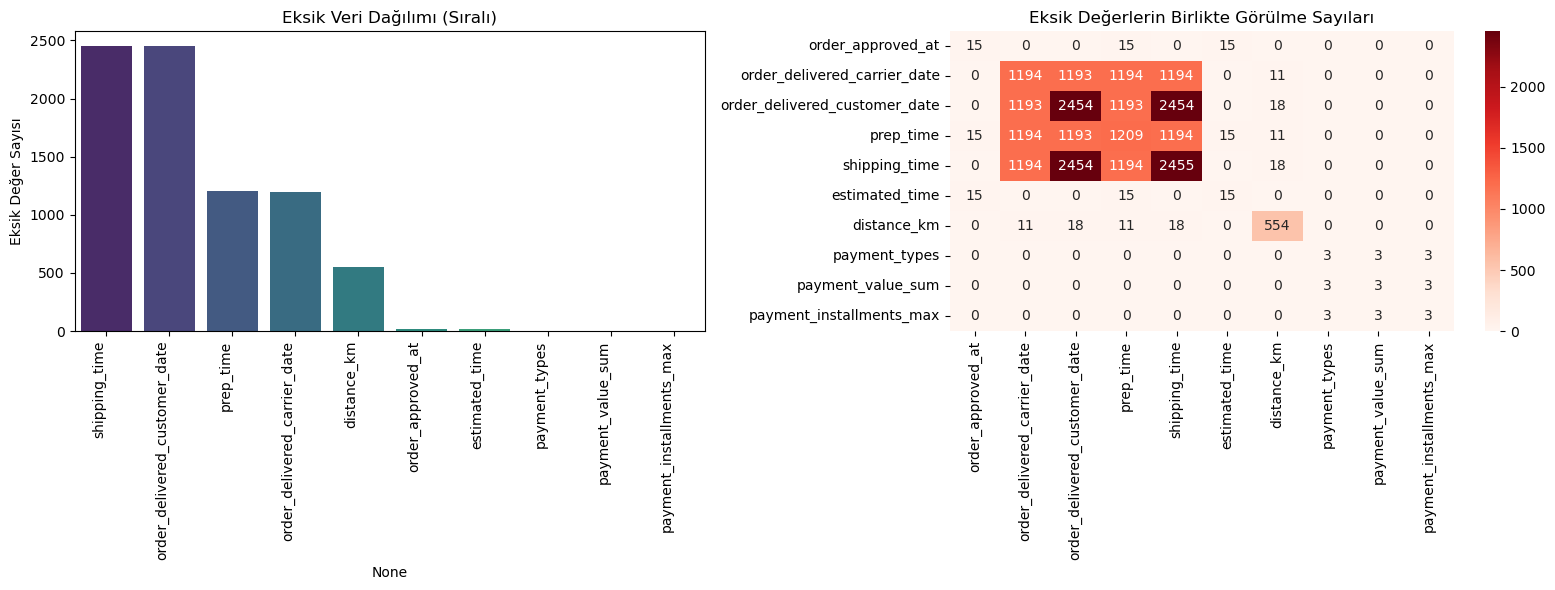

In [87]:

# --- Eksik değerler analizi (Barplot + Heatmap + Sayısal) ---

missing_cols = fact_order_shipments.columns[fact_order_shipments.isna().any()].tolist()

# Eksik sayıları hesapla ve sırala
null_counts = fact_order_shipments[missing_cols].isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(16,6))

# --- 1. Barplot (büyükten küçüğe sıralı) ---
plt.subplot(1,2,1)
sns.barplot(x=null_counts.index, y=null_counts.values, palette="viridis")
plt.xticks(rotation=90, ha="right")
plt.ylabel("Eksik Değer Sayısı")
plt.title("Eksik Veri Dağılımı (Sıralı)")

# --- 2. Heatmap ---
plt.subplot(1,2,2)
mask_int = fact_order_shipments[missing_cols].isna().astype(int)
missing_overlap = mask_int.T.dot(mask_int)
sns.heatmap(missing_overlap, annot=True, fmt="d", cmap="Reds")
plt.title("Eksik Değerlerin Birlikte Görülme Sayıları")

plt.tight_layout()
plt.show()

# --- 3. Sayısal özet ---

Eksik değer analizi sonucunda eksik hücrelerin büyük çoğunluğunun aynı satırlarda kümelendiği görülmektedir. Özellikle order_delivered_customer_date kolonunda eksik olan 2454 satırın tamamında shipping_time, 1193’ünde ise prep_time da eksiktir. Bu üç kolonun oluşturduğu eksikler toplamda 6101 hücreye karşılık gelmekte olup, bu da tüm eksik değerlerin yaklaşık %73’ünü oluşturmaktadır.
Bu hücrelerin drop edilmesi hainde kaybımız toplam satırların %2.18'idir. 


Eksik değerlerin zaman bazlı olmasından kaynaklı olarak, eksik bilgi barındıran siparişlerin tarihleri de analizimiz için önemlidir. Çünkü eğer tarihsel dağılımı son günlere rastgeliyorsa, bu eksikler henüz tamamlanma aşamasında olan siparişlerden oluşuyor olabilir. Öyle bir durumda makine öğrenmesi için test olarak kullanılabilir. şimdi zamana göre dağılımını gösterelim. 

Teslim edilmeyen siparişlerin tarih aralığı:
Min: 2016-09-04 21:15:19
Max: 2018-09-03 09:06:57

Aylık dağılım:
order_purchase_timestamp
2016-09      3
2016-10     44
2017-01     42
2017-02     93
2017-03    103
2017-04    115
2017-05    133
2017-06     94
2017-07    103
2017-08    113
2017-09     94
2017-10    108
2017-11    191
2017-12    121
2018-01    171
2018-02    153
2018-03    200
2018-04    148
2018-05    115
2018-06     71
2018-07    132
2018-08    106
2018-09      1
Freq: M, Name: count, dtype: int64


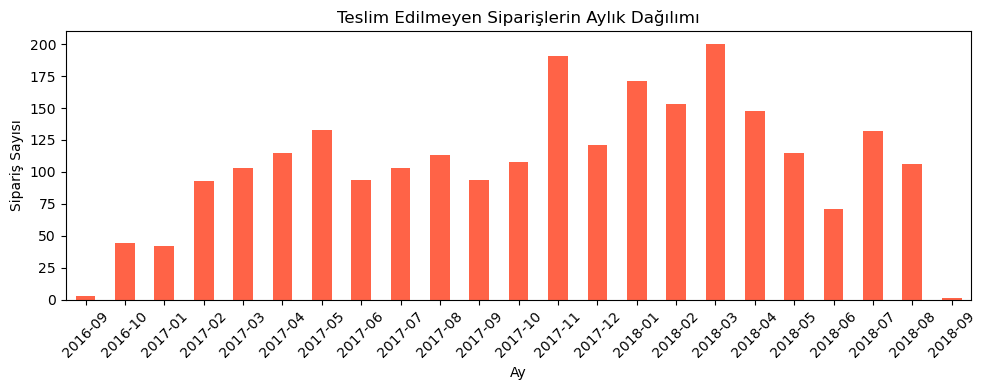

In [88]:
# Teslim edilmeyen siparişlerin satın alma tarihleri
undelivered = fact_order_shipments[
    fact_order_shipments["order_delivered_customer_date"].isna()
]

date_dist = pd.to_datetime(undelivered["order_purchase_timestamp"])

print("Teslim edilmeyen siparişlerin tarih aralığı:")
print("Min:", date_dist.min())
print("Max:", date_dist.max())

# Ay bazında dağılım
undelivered_by_month = date_dist.dt.to_period("M").value_counts().sort_index()

print("\nAylık dağılım:")
print(undelivered_by_month)

# Görselleştirme
plt.figure(figsize=(10,4))
undelivered_by_month.plot(kind="bar", color="tomato")
plt.title("Teslim Edilmeyen Siparişlerin Aylık Dağılımı")
plt.xlabel("Ay")
plt.ylabel("Sipariş Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Grafikte görüldüğü üzere son zamanlara doğru artan bir teslim edilmeme sorunu yok. Aksine zaman içinde değişik sayılarda teslim edimeyen siparişler bulunmaktadır. Dolayısıyla bu değerler gerçekten eksik değer olarak varsayılacaktır. 

In [89]:
utils.missing_VS_target(fact_order_shipments, "is_late", na_cols)

                           TARGET_MEAN   Count
order_approved_at_NA_FLAG                     
0                                0.065  112635
1                                0.000      15


                                      TARGET_MEAN   Count
order_delivered_carrier_date_NA_FLAG                     
0                                           0.065  111456
1                                           0.001    1194


                                       TARGET_MEAN   Count
order_delivered_customer_date_NA_FLAG                     
0                                            0.066  110196
1                                            0.000    2454


                   TARGET_MEAN   Count
prep_time_NA_FLAG                     
0                        0.065  111441
1                        0.001    1209


                       TARGET_MEAN   Count
shipping_time_NA_FLAG                     
0                            0.066  110195
1                            0.000    2455


      

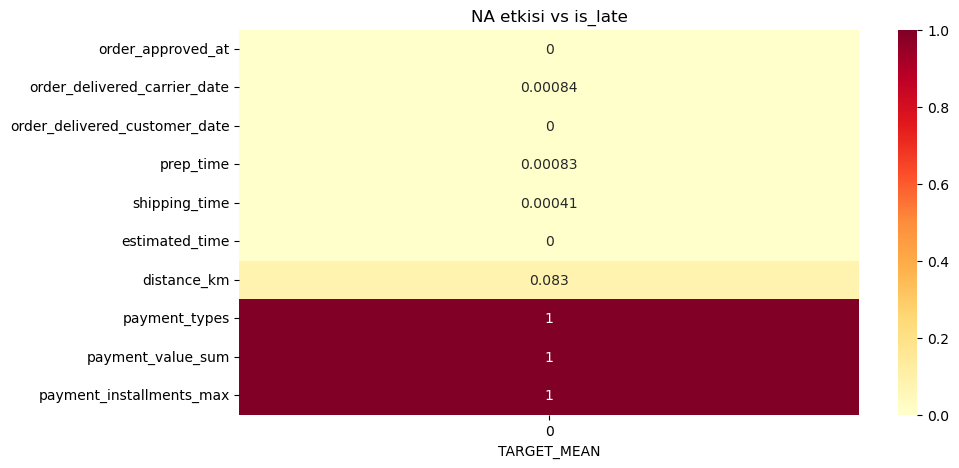

In [90]:
utils.missing_target_heatmap(fact_order_shipments, "is_late", na_cols)

Eksik Veri Analizi ve Geç Teslim Oranı ile İlişki

1. *order_approved_at*
Eksik değer oranı çok düşük (15 satır, %0.01). Boş hücre olan kayıtlarda geç teslim oranı sıfır, diğerlerinde ise yüzde 4 civarında. Aradaki fark önemsiz olduğu için bu sütunu boş hücreler silinerek kullanmak uygun olur, ayrıca flag eklemeye gerek yok.

2. *order_delivered_carrier_date*
Yaklaşık %1.1 oranında eksik değer var (1.194 satır). Boş hücrelerde geç teslim oranı neredeyse sıfır, diğerlerinde yüzde 4’ün üzerinde. Fark küçük olduğu için boş hücrelerin silinmesi yeterli, flag eklemeye gerek yok.

3. *order_delivered_customer_date*
Eksik değer oranı biraz daha yüksek (%2.3, 2.454 satır). Boş hücrelerde geç teslim hiç yok, diğerlerinde yüzde 4’ün üzerinde. Veri kaybı sınırlı olacağı için boş hücrelerin silinmesi mantıklı. Flag yalnızca istenirse eklenebilir.

4. *prep_time, shipping_time, estimated_time*
Bu sütunlarda da eksik oranı %1–2.3 aralığında. Boş hücrelerde geç teslim oranı çok düşük. Bu nedenle boş hücreleri silmek uygun bir çözümdür, flag eklemek gerekli görünmüyor.

5. *distance_km*
Eksik değer oranı yüzde 0.5 (554 satır). Boş hücrelerde geç teslim oranı yüzde 8.3, dolu olanlarda yüzde 6.4. Burada fark biraz daha dikkat çekici. Bu nedenle silmek mümkün olsa da boş hücreler için flag eklemek faydalı olabilir.

6. *payment_types, payment_value_sum, payment_installments_max*
Bu sütunlarda yalnızca 3 eksik satır var. Hepsinde geç teslim oranı yüzde 100 çıkıyor, fakat bu sayı çok küçük olduğu için anlamlı değil. Bu kayıtların silinmesi en güvenilir çözümdür.

**Genel Öneri**

- Tarih ve süre sütunları (*order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, prep_time, shipping_time, estimated_time*) için eksik satırların silinmesi yeterli olacaktır. Veri kaybı oranı düşük olduğundan flag eklemeye gerek yoktur.

- *distance_km* sütununda eksik değer oranı düşük olsa da boş hücrelerde geç teslim oranı daha yüksek çıkmıştır. Bu nedenle, silmek mümkün olsa da ek olarak flag değişkeni oluşturmak faydalı olabilir.

- Ödeme ile ilgili sütunlar (*payment_types, payment_value_sum, payment_installments_max*) yalnızca birkaç eksik satır içermektedir. Bu kayıtların doğrudan silinmesi en uygun çözümdür.

In [91]:
fact_order_clean = utils.handle_missing_values(fact_order_shipments)
print(f"Orijinal satır sayısı: {fact_order_shipments.shape[0]}")
print(f"Temizlenmiş satır sayısı: {fact_order_clean.shape[0]}")

Orijinal satır sayısı: 112650
Temizlenmiş satır sayısı: 112647


In [92]:
fact_order_clean.shape

(112647, 29)

In [93]:
fact_order_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112647 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   cusUni                         112647 non-null  object        
 1   customer_order_id              112647 non-null  object        
 2   order_id_pref                  112647 non-null  object        
 3   seller_id_pref                 112647 non-null  object        
 4   product_id_pref                112647 non-null  object        
 5   order_purchase_timestamp       112647 non-null  datetime64[ns]
 6   order_approved_at              112647 non-null  datetime64[ns]
 7   order_delivered_carrier_date   111453 non-null  datetime64[ns]
 8   order_delivered_customer_date  110193 non-null  datetime64[ns]
 9   order_estimated_delivery_date  112647 non-null  datetime64[ns]
 10  prep_time                      112647 non-null  float64       
 11  shipp

In [94]:
# Mevcut kolon UInt32Dtype ise önce .to_numpy() ile numpy array’e çevir
fact_order_clean['week'] = fact_order_clean['week'].to_numpy(dtype='int32')

In [95]:
fact_order_clean.dtypes['week']

dtype('int32')

In [96]:
fact_order_clean.shape

(112647, 29)

### Negatif değerler 

In [97]:
time_cols = ["prep_time", "shipping_time", "estimated_time"]

check_results = []

for col in time_cols:
    check_results.append({
        "Kolon": col,
        "Min Değer": fact_order_clean[col].min(),
        "Negatif Sayısı": (fact_order_clean[col] < 0).sum(),
        "Eksik Sayısı": fact_order_clean[col].isnull().sum()
    })

check_df = pd.DataFrame(check_results)
print(check_df)

            Kolon  Min Değer  Negatif Sayısı  Eksik Sayısı
0       prep_time   -172.000            1551             0
1   shipping_time    -17.000              50             0
2  estimated_time     -7.000               9             0


#############################################
### 1. Outliers (Aykırı Değerler)
#############################################

In [98]:
print(fact_order_clean.head())
print(fact_order_clean.info())

        cusUni customer_order_id order_id_pref seller_id_pref product_id_pref order_purchase_timestamp   order_approved_at order_delivered_carrier_date order_delivered_customer_date order_estimated_delivery_date  prep_time  shipping_time  estimated_time  delay_days  delay_class  is_late  distance_km payment_types  payment_value_sum  payment_installments_max  seller_count_per_order  year  month  week  shipping_time_NA_FLAG  prep_time_NA_FLAG  distance_km_NA_FLAG  order_approved_at_NA_FLAG  \
0  CUSUNI64073          CUS65558      ORD85268         SEL514        PRO25866      2017-09-13 08:59:02 2017-09-13 09:45:35          2017-09-19 18:34:16           2017-09-20 23:43:48                    2017-09-29      6.000          1.000          15.000       0.000            0        0      301.505   credit_card             72.190                     2.000                       1  2017      9    37                      0                  0                    0                          0   
1  CUSUN

### LOF Modeli ile çok değişkenli aykırı değer tespiti

In [99]:
# Outlier kontrolü yapmak istediğimiz kolonlar
num_cols_for_lof = [
    'prep_time', 'shipping_time', 'estimated_time', 
    'distance_km', 'payment_value_sum', 'payment_installments_max', 'seller_count_per_order'
]

### LOF ile aykırı değer tespiti

In [100]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # %5 uç değer
lof_labels = lof.fit_predict(fact_order_clean[num_cols_for_lof])
lof_scores = lof.negative_outlier_factor_


print("\nİlk 10 LOF skoru:")
print(lof_scores[:10])

# Aykırı (=-1) ve normal (=1) dağılımı
print("\nLOF label dağılımı:")
print(pd.Series(lof_labels).value_counts())


İlk 10 LOF skoru:
[-1.15868953 -1.00998733 -0.98111699 -1.13674069 -1.21025696 -0.99127162
 -0.96707663 -1.07220715 -1.03182156 -1.05173326]

LOF label dağılımı:
 1    107014
-1      5633
Name: count, dtype: int64


### Eşik değer görselleştirme

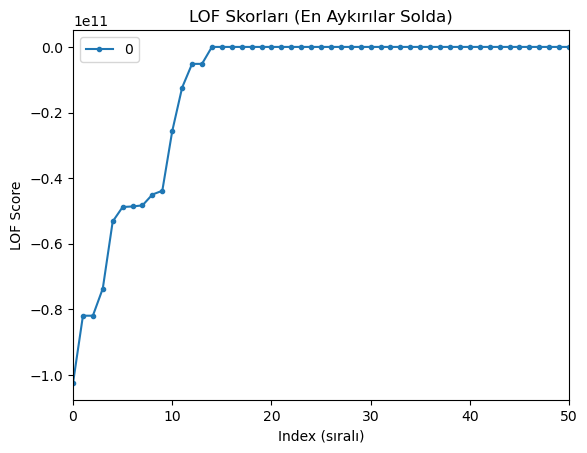

In [101]:
scores = pd.DataFrame(np.sort(lof_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.xlabel("Index (sıralı)")
plt.ylabel("LOF Score")
plt.title("LOF Skorları (En Aykırılar Solda)")
plt.show()

### LOF Skorları ve Aykırı Değer Analizi

- **LOF Skorları (Local Outlier Factor):**  
  İlk 10 gözlemin skorları yaklaşık -0.96 ile -1.21 arasında değişmektedir.  
  - LOF skoru **-1’e yakınsa gözlem normal** kabul edilir.  
  - Skor daha düşük (ör. -1.5 ve altı) olduğunda gözlem **daha güçlü bir aykırı değer** olarak değerlendirilir.  
  Burada skorların çoğu -1 civarında olup normal sayılırken, örneğin -1.21 gibi daha düşük değerler diğerlerine kıyasla daha aykırı gözükmektedir.  

- **Etiket Dağılımı:**  
  - **Normal (1):** 107,014 satır  
  - **Aykırı (-1):** 5,633 satır  
  Bu dağılım, veri setinin yaklaşık **%5’inin aykırı** olarak belirlendiğini göstermektedir. (Seçilen contamination=0.05 parametresiyle uyumludur.)

- **Sonuç:**  
  LOF algoritması, toplam gözlemlerin %5’ini uç değer olarak işaretlemiştir. Bu gözlemler sonraki adımda incelenmiş ve mantıksız uç değerler alt–üst limit yöntemiyle sınırlandırılarak veri seti modelleme için daha güvenli hale getirilmiştir.


### Aykırı değerleri alt-üst limit yöntemiyle eşitle 

In [102]:
for col in num_cols_for_lof:
    utils.replace_with_thresholds(fact_order_clean, col)
    print("Aykırı değerler alt-üst limitlere eşitlendi.")

Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.
Aykırı değerler alt-üst limitlere eşitlendi.


In [103]:
utils.check_outliers_for_columns(fact_order_clean, num_cols_for_lof)

{'prep_time': False,
 'shipping_time': False,
 'estimated_time': False,
 'distance_km': False,
 'payment_value_sum': False,
 'payment_installments_max': False,
 'seller_count_per_order': False}


=== prep_time ===


,Original,Cleaned
count,111441.000,112647.000
mean,2.348,2.024
std,3.600,2.211
min,-172.000,-4.500
25%,0.000,0.000
50%,1.000,1.000
75%,3.000,3.000
max,125.000,7.500


Negative values after cleaning: 1551
Missing values: 0


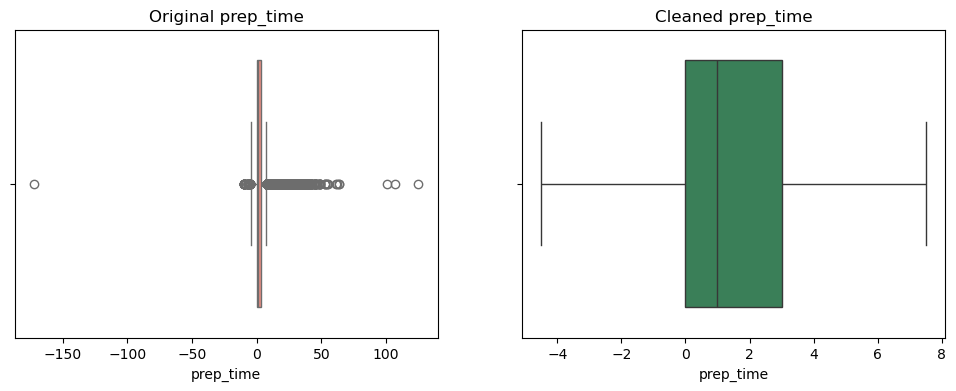

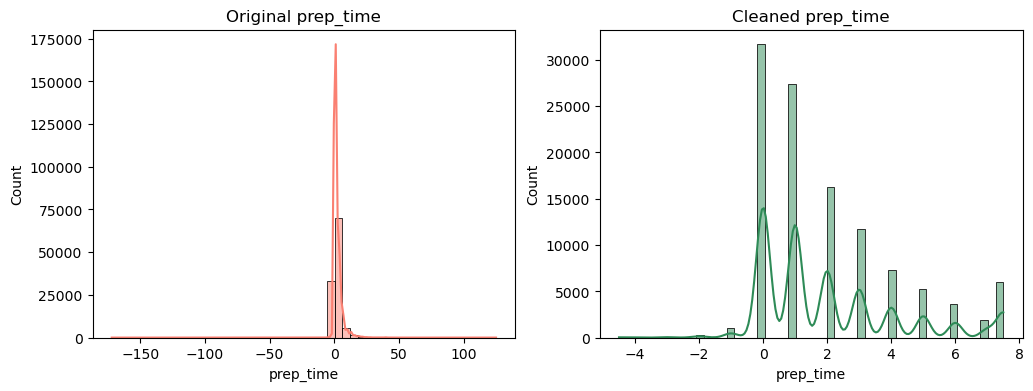


=== shipping_time ===


,Original,Cleaned
count,110195.000,112647.000
mean,8.734,8.041
std,8.612,5.852
min,-17.000,-6.500
25%,4.000,4.000
50%,7.000,7.000
75%,11.000,11.000
max,205.000,21.500


Negative values after cleaning: 50
Missing values: 0


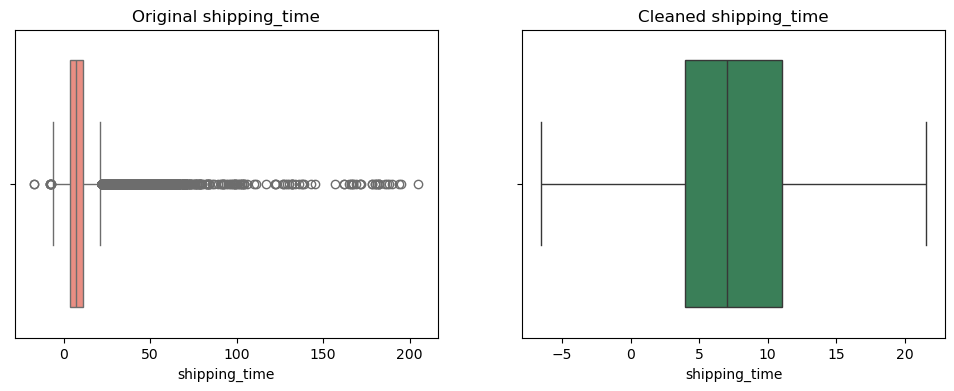

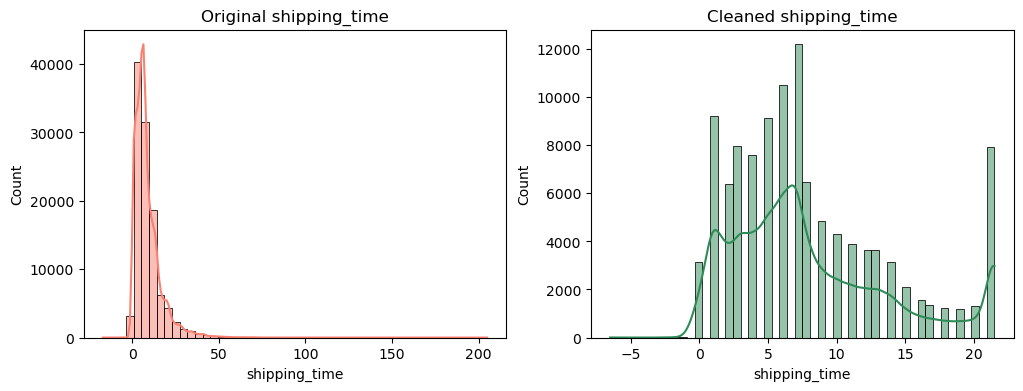


=== estimated_time ===


,Original,Cleaned
count,112635.000,112647.000
mean,22.942,22.756
std,8.901,8.222
min,-7.000,3.000
25%,18.000,18.000
50%,22.000,22.000
75%,28.000,28.000
max,153.000,43.000


Negative values after cleaning: 0
Missing values: 0


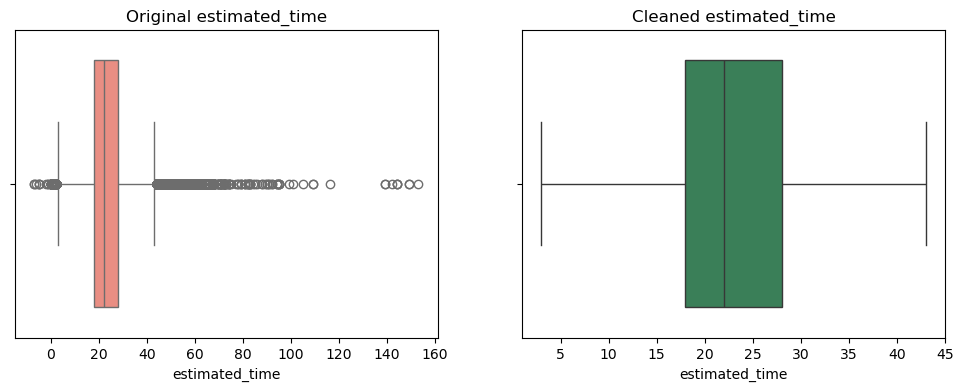

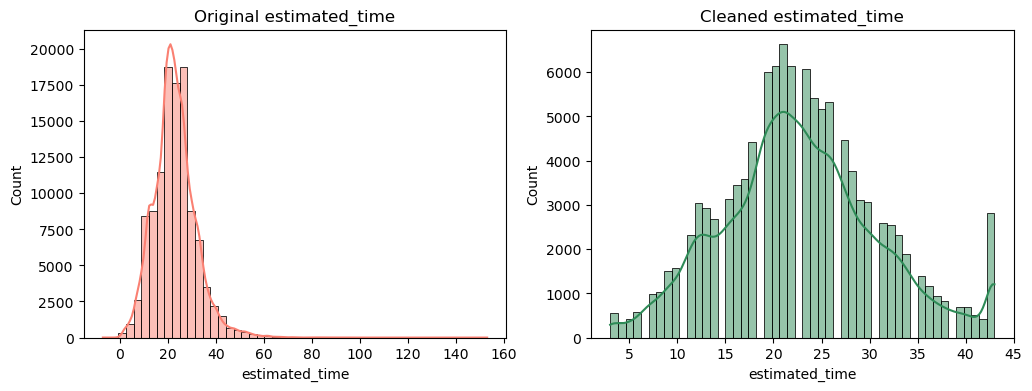


=== distance_km ===


,Original,Cleaned
count,112096.000,112647.000
mean,596.960,557.096
std,589.980,482.084
min,0.000,0.000
25%,184.066,187.573
50%,431.636,431.636
75%,792.277,789.029
max,8677.924,1691.212


Negative values after cleaning: 0
Missing values: 0


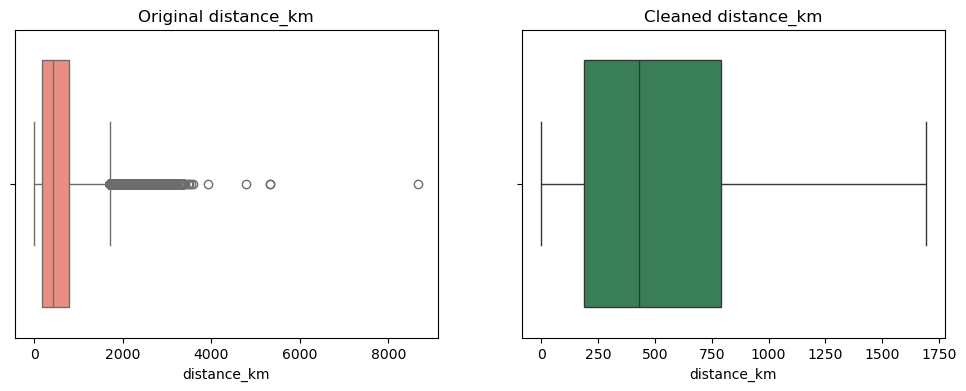

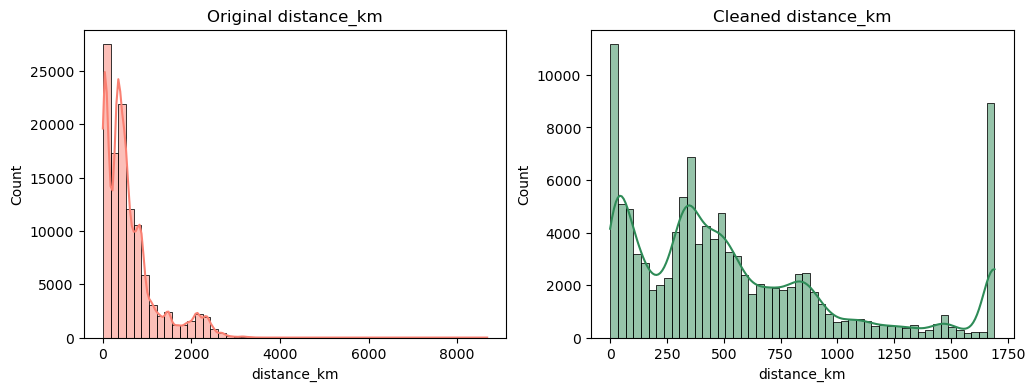


=== payment_value_sum ===


,Original,Cleaned
count,112647.000,112647.000
mean,180.281,147.465
std,272.849,106.603
min,9.590,9.590
25%,65.670,65.670
50%,114.440,114.440
75%,195.390,195.390
max,13664.080,389.970


Negative values after cleaning: 0
Missing values: 0


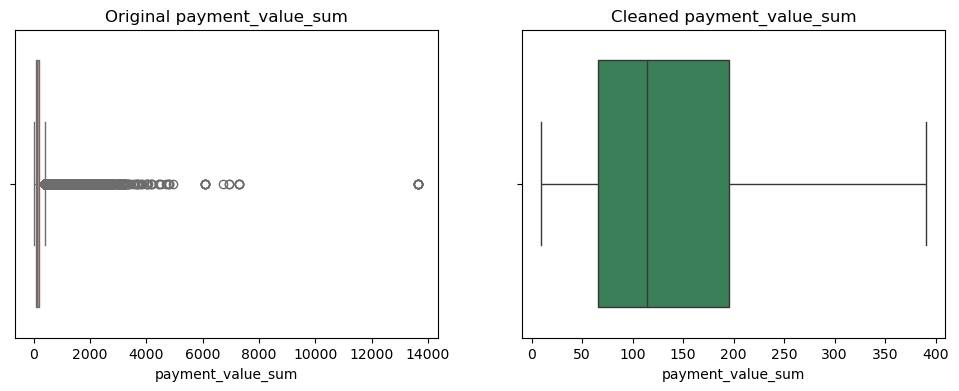

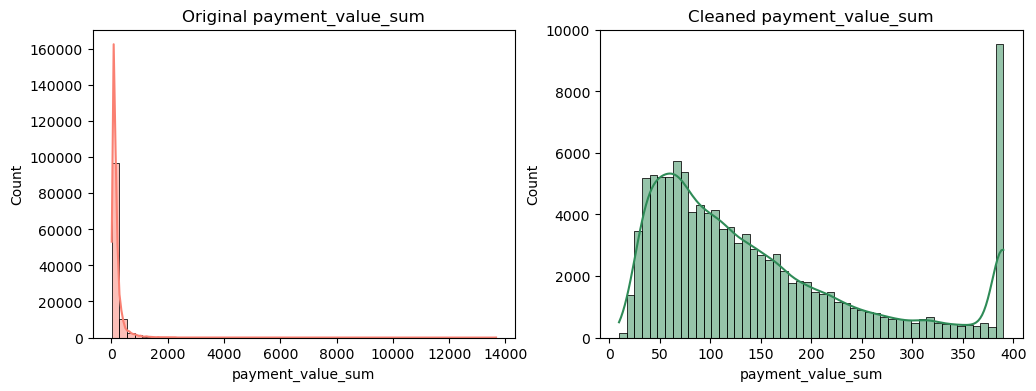


=== payment_installments_max ===


,Original,Cleaned
count,112647.000,112647.000
mean,3.018,2.900
std,2.803,2.489
min,0.000,0.000
25%,1.000,1.000
50%,2.000,2.000
75%,4.000,4.000
max,24.000,8.500


Negative values after cleaning: 0
Missing values: 0


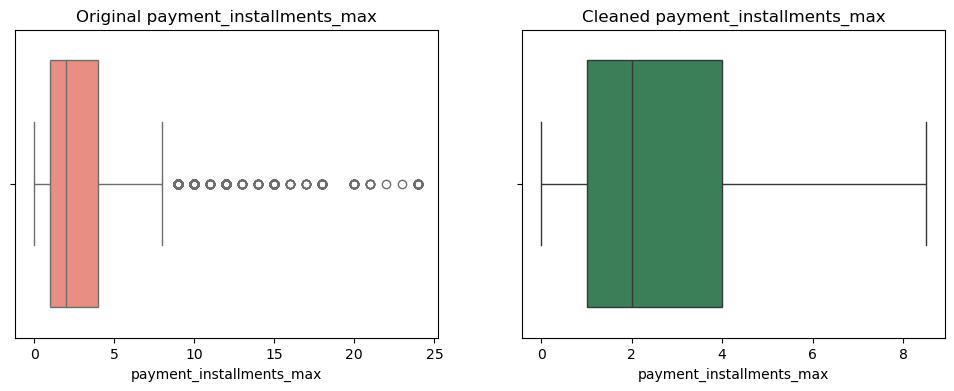

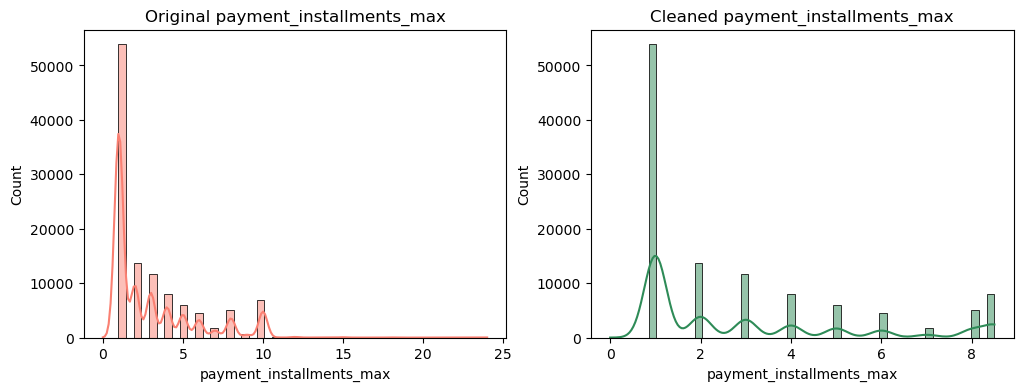


=== seller_count_per_order ===


,Original,Cleaned
count,112650.000,112647.000
mean,1.030,1.000
std,0.186,0.000
min,1.000,1.000
25%,1.000,1.000
50%,1.000,1.000
75%,1.000,1.000
max,5.000,1.000


Negative values after cleaning: 0
Missing values: 0


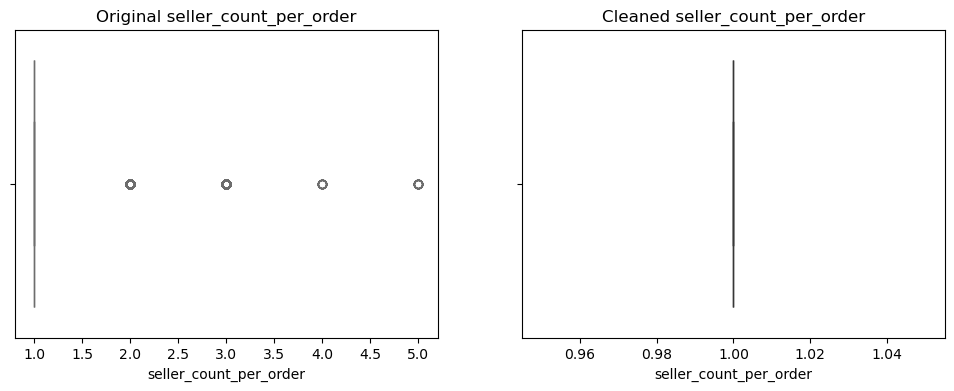

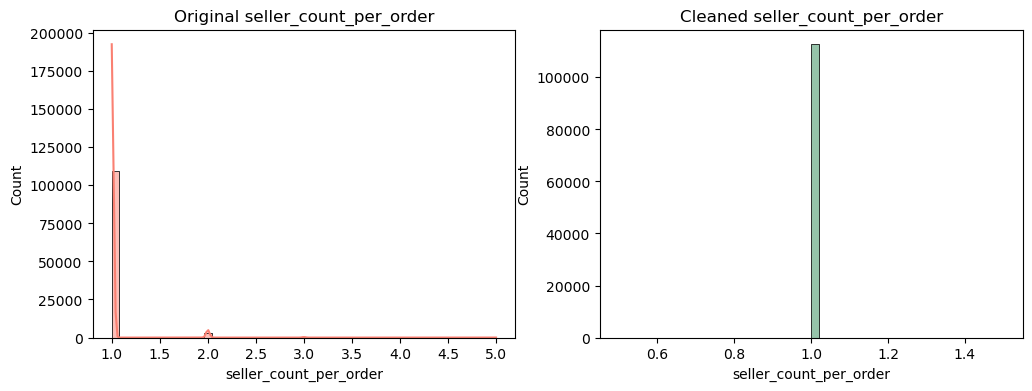

In [104]:
utils.check_outlier_cleaning(fact_order_shipments, fact_order_clean, num_cols_for_lof)

In [105]:
fact_order_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112647 entries, 0 to 112649
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   cusUni                         112647 non-null  object        
 1   customer_order_id              112647 non-null  object        
 2   order_id_pref                  112647 non-null  object        
 3   seller_id_pref                 112647 non-null  object        
 4   product_id_pref                112647 non-null  object        
 5   order_purchase_timestamp       112647 non-null  datetime64[ns]
 6   order_approved_at              112647 non-null  datetime64[ns]
 7   order_delivered_carrier_date   111453 non-null  datetime64[ns]
 8   order_delivered_customer_date  110193 non-null  datetime64[ns]
 9   order_estimated_delivery_date  112647 non-null  datetime64[ns]
 10  prep_time                      112647 non-null  float64       
 11  shipp

In [106]:
output_path = "cleaned_data_with_prefix_id/fact_order_clean.csv"
fact_order_clean.to_csv(output_path, index=False, sep=";", decimal=",")

In [107]:
fact_order_clean = pd.read_csv("cleaned_data_with_prefix_id/fact_order_clean.csv",sep=";",decimal=",")
print(fact_order_clean.shape)
print(fact_order_clean.columns.tolist())
print(fact_order_clean[["distance_km", "payment_value_sum"]].head())
print(fact_order_clean.dtypes[["distance_km", "payment_value_sum"]])

(112647, 29)
['cusUni', 'customer_order_id', 'order_id_pref', 'seller_id_pref', 'product_id_pref', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'prep_time', 'shipping_time', 'estimated_time', 'delay_days', 'delay_class', 'is_late', 'distance_km', 'payment_types', 'payment_value_sum', 'payment_installments_max', 'seller_count_per_order', 'year', 'month', 'week', 'shipping_time_NA_FLAG', 'prep_time_NA_FLAG', 'distance_km_NA_FLAG', 'order_approved_at_NA_FLAG', 'estimated_time_NA_FLAG']
   distance_km  payment_value_sum
0      301.505             72.190
1      585.565            259.830
2      312.344            216.870
3      293.169             25.780
4      646.164            218.040
distance_km          float64
payment_value_sum    float64
dtype: object


In [108]:
fact_order_clean["distance_km"].head()

0   301.505
1   585.565
2   312.344
3   293.169
4   646.164
Name: distance_km, dtype: float64

## Encoding işlemleri

Makine öğrenmesi modellerinde ön işleme adımları (özellikle ölçekleme – scaling ve kategorik değişkenlerin kodlanması – encoding) modelin başarısı için kritik öneme sahiptir. Çünkü ham verilerde bulunan değişkenler farklı tiplerde olabilir: sayısal değerler (ör. süre, mesafe, fiyat), kategorik değerler (ör. ödeme tipi), ikili değişkenler (ör. evet/hayır), tarih–zaman bilgileri ya da yalnızca tanımlayıcı ID’ler. Bu farklı türdeki değişkenler aynı modelde doğrudan kullanıldığında, ölçek farkları ya da temsil biçiminden kaynaklanan sorunlar modelin öğrenmesini zorlaştırır ve yanlı tahminlere yol açar.

Ölçekleme (scaling), özellikle _sayısal değişkenlerde_ önemlidir çünkü farklı büyüklükteki değişkenler (örneğin binler seviyesindeki ödeme tutarı ile tek haneli hazırlık süresi) aynı modelde kullanıldığında, bazı algoritmalar büyük değere sahip değişkenleri daha baskın kabul edebilir. Böylece model yanlış yönlenir. Bu nedenle sayısal değişkenler genellikle aynı ölçeğe getirilir. Bunun için _StandardScaler_, _MinMaxScaler_, _RobustScaler_ gibi yöntemler kullanılabilir. Çarpık dağılımlarda _logaritmik dönüşümler_ de sıkça tercih edilir.

Encoding (kategorik değişkenlerin kodlanması) ise, metinsel veya _kategorik verilerin_ makine öğrenmesi algoritmalarına sayısal olarak tanıtılması için gereklidir. Çünkü çoğu algoritma doğrudan string veya kategori ifadeleriyle çalışamaz. Burada kullanılan yöntem, kategorinin çeşitliliğine göre değişir: _az sayıda kategori varsa One-Hot Encoding_, _çok fazla kategori varsa Target Encoding, Frequency Encoding veya Hashing_ gibi alternatifler kullanılabilir.

Bu nedenle bir veri seti üzerinde çalışırken öncelikle değişkenlerin tiplerine bakmak, ardından her tip için uygun dönüşümü seçmek gerekir. Aynı tipte görünseler bile, değişkenlerin içeriği veya modelle olan ilişkisi farklı işlemleri gerektirebilir. Örneğin iki değişken de numerik olabilir ama biri log dönüşümüne ihtiyaç duyarken diğeri doğrudan ölçeklenebilir; ya da biri hedef değişkenle doğrudan ilişkili olduğu için kullanılmamalıdır.

#### Data Tiplerine Göre Genel Kurallar

* ID / Key değişkenleri : (ör. müşteri ID, sipariş ID) → Modelde kullanılmaz; sadece eşleştirme/join için tutulur.

* Datetime değişkenleri : Ham haliyle kullanılmaz; içinden yıl, ay, hafta, gün, hafta içi/hafta sonu, saat gibi türev özellikler çıkarılır.

* Sayısal değişkenler (float/int) : Eksik değerler doldurulur; gerekirse log dönüşümü yapılır; ardından StandardScaler veya RobustScaler ile ölçeklenir.

* Binary değişkenler (0/1, evet/hayır) *: Olduğu gibi bırakılır, encoding veya scaling gerekmez.

* Kategorik değişkenler : Kategori sayısına göre farklı encoding yöntemleri seçilir. Az kategori → One-Hot; çok kategori → Target/Frequency encoding.

* Hedef değişken (target) : Encoding veya scaling yapılmaz, yalnızca modelin çıktısıdır.

### Veri Setindeki Kolonların Sınıflandırılması

- **ID/Key**: cusUni, customer_order_id, order_id_pref, seller_id_pref, product_id_pref  
- **Datetime**: order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date  
- **Sayısal**: prep_time, shipping_time, estimated_time, delay_days, distance_km, payment_value_sum, payment_installments_max, seller_count_per_order  
- **Binary / Target**: is_late, delay_class  
- **Kategorik**: payment_types  
- **Datetime türevleri**: year, month, week  


### Encoding Sonrası Dağılım Kontrolü

ID bazlı encoding (ör. _cust_late_rate_, _product_late_rate_) uygulandığında, train ve test setlerinde bu yeni feature’ların dağılımlarını karşılaştırmak önemlidir.  

- Eğer train ve test’te dağılımlar -benzer- görünüyorsa:  
  - Encoding sırasında leakage olmamış demektir.  
  - Train setinde öğrenilen istatistikler test setine doğru şekilde aktarılmıştır.  
  - Bu durumda model, gerçek hayattaki müşteri/ürünlerde de benzer şekilde çalışabilir.  

- Eğer dağılımlar -bariz farklı- ise:  
  - Train-test split farklı dağılımlardan yapılmış olabilir.  
  - Ya da test setinde çok fazla “bilinmeyen ID” vardır. Bu ID’ler global ortalama ile doldurulduğu için dağılım kayması oluşur.  

Bu nedenle ID encoding sonrası mutlaka -train–test dağılım kıyaslaması- yapılmalıdır.  

In [109]:
# Target
TARGET = "is_late"
y = fact_order_clean[TARGET].astype(int)

# Drop leakage/id/date columns
drop_cols = [
    TARGET,
    "delay_days", "delay_class",
    "cusUni", "customer_order_id", "order_id_pref", "seller_id_pref", "product_id_pref",
    "order_purchase_timestamp", "order_approved_at",
    "order_delivered_carrier_date", "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "dominant_payment_type"   # 
]
X = fact_order_clean.drop(columns=drop_cols, errors="ignore")

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature engineering & missing value handling
X_train_feat = utils.handle_missing_values_leakfree(utils.add_time_features_leakfree(X_train))
X_test_feat  = utils.handle_missing_values_leakfree(utils.add_time_features_leakfree(X_test))

# Payment Type Encoding
pt_encoder = utils.PaymentTypeEncoder(col="payment_types")
X_train_feat = pt_encoder.fit_transform(X_train_feat)
X_test_feat = pt_encoder.transform(X_test_feat)

# Leakage kolonlarını tekrar kontrol et
X_train_feat = utils.drop_leakage_columns(X_train_feat)
X_test_feat  = utils.drop_leakage_columns(X_test_feat)

# Son temizlik
X_train_feat = X_train_feat.drop(columns=["dominant_payment_type"], errors="ignore")
X_test_feat  = X_test_feat.drop(columns=["dominant_payment_type"], errors="ignore")

# Son kontrol
print("Train shape:", X_train_feat.shape)
print("Test shape:", X_test_feat.shape)
print("\nTrain dtypes:\n", X_train_feat.dtypes.value_counts())
print("\nAny NaN left?:", X_train_feat.isna().sum().sum(), X_test_feat.isna().sum().sum())

print(X_train_feat.info())

Train shape: (90117, 13)
Test shape: (22530, 13)

Train dtypes:
 int64      9
float64    3
int32      1
Name: count, dtype: int64

Any NaN left?: 0 0
<class 'pandas.core.frame.DataFrame'>
Index: 90117 entries, 56379 to 107385
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   distance_km                90117 non-null  float64
 1   payment_value_sum          90117 non-null  float64
 2   payment_installments_max   90117 non-null  float64
 3   seller_count_per_order     90117 non-null  int64  
 4   year                       90117 non-null  int64  
 5   month                      90117 non-null  int64  
 6   week                       90117 non-null  int64  
 7   distance_km_NA_FLAG        90117 non-null  int32  
 8   order_approved_at_NA_FLAG  90117 non-null  int64  
 9   boleto                     90117 non-null  int64  
 10  credit_card                90117 non-null  int64  
 11  debit_ca

In [ ]:
# Model tanımla
log_reg = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)

# Eğit
log_reg.fit(X_train_feat, y_train)

# Tahmin
y_pred = log_reg.predict(X_test_feat)
y_proba = log_reg.predict_proba(X_test_feat)[:, 1]

# Metrikler
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.5709069546747134

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     21078
           1       0.00      0.00      0.00      1452

    accuracy                           0.94     22530
   macro avg       0.47      0.50      0.48     22530
weighted avg       0.88      0.94      0.90     22530


Confusion Matrix:
 [[21078     0]
 [ 1452     0]]


In [ ]:
# Class imbalance düzeltme
log_reg_bal = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42, class_weight="balanced")

log_reg_bal.fit(X_train_feat, y_train)

y_pred_bal = log_reg_bal.predict(X_test_feat)
y_proba_bal = log_reg_bal.predict_proba(X_test_feat)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))




ROC-AUC: 0.5732748159335769

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.76     21078
           1       0.08      0.48      0.14      1452

    accuracy                           0.63     22530
   macro avg       0.52      0.56      0.45     22530
weighted avg       0.89      0.63      0.72     22530


Confusion Matrix:
 [[13423  7655]
 [  755   697]]


**Baseline Model: Logistic Regression**

**Target Seçimi**
Bu projede tahmin etmek istediğimiz şey siparişin geç kalıp kalmadığıdır.  
Bunun için is_late kolonunu hedef (target) olarak belirledik.  
Alternatif olarak delay_days (sürekli değer) veya delay_class (çok sınıflı etiket) kullanılabilirdi.  
Ancak binary (0 = zamanında, 1 = geç) olan is_late, ilk model denemeleri için daha uygundur.  

**Feature Hazırlığı**
- ID ve tarih kolonları çıkarıldı (leakage riski ve model için anlam taşımıyorlar).  
- Eksik değerler handle_missing_values_leakfree fonksiyonu ile dolduruldu.  
- Payment Types kolonuna one-hot encoding uygulandı (boleto, credit_card, debit_card, voucher).  
- dominant_payment_type redundant olduğu için drop edildi.  
- Sonuç olarak tamamen sayısal, NaN içermeyen 13 feature’dan oluşan bir dataset elde edildi.  

**Model Seçimi**
İlk adımda baseline olarak Logistic Regression kullanıldı.  
Sebebi basit ve hızlı bir yöntem olmasıdır. Ayrıca ROC-AUC, Precision, Recall, F1 gibi metriklerle kıyas için uygun bir başlangıçtır.  

Dataset çok dengesizdir (yaklaşık %95 zamanında, %5 geç).  
İlk model sadece hep 0 tahmini yaptı. Bu yüzden class_weight="balanced" parametresi eklenerek azınlık sınıfa (geç teslimat) daha fazla ağırlık verildi.  

**Sonuçlar**
- Dengesiz Logistic Regression (class_weight olmadan):  
  Model sadece "0" sınıfını tahmin etti. Recall (class 1) = 0.00.  
- Balanced Logistic Regression:  
  Recall (class 1) ≈ 0.48, yani gecikmelerin neredeyse yarısını yakalayabildi.  
  Precision (class 1) ≈ 0.08, yani yanlış pozitif oranı çok yüksek.  
  ROC-AUC ≈ 0.57, rastgele seviyenin biraz üzerinde.  

**Yorum**

- Logistic Regression modeli baseline için yararlıdır, ancak karmaşık ilişkileri yakalayamamaktadır.  
Özellikle ödeme tipi, mesafe, ay/hafta gibi değişkenlerin etkileşimleri lineer sınırlarla açıklanamamaktadır.  
Daha güçlü bir model (LightGBM, XGBoost gibi ağaç tabanlı yöntemler) ile daha iyi sonuç alınması beklenmektedir.


In [112]:
# Class imbalance için scale_pos_weight ayarlıyoruz
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
scale_pos_weight = neg / pos

lgbm = lgb.LGBMClassifier(
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight
)

# Eğit
lgbm.fit(X_train_feat, y_train)

# Tahmin
y_pred_lgbm = lgbm.predict(X_test_feat)
y_proba_lgbm = lgbm.predict_proba(X_test_feat)[:, 1]

# Metrikler
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))


[LightGBM] [Info] Number of positive: 5810, number of negative: 84307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 598
[LightGBM] [Info] Number of data points in the train set: 90117, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.064472 -> initscore=-2.674884
[LightGBM] [Info] Start training from score -2.674884


  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


ROC-AUC: 0.7732989065668983

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.78      0.86     21078
           1       0.17      0.65      0.27      1452

    accuracy                           0.77     22530
   macro avg       0.57      0.71      0.56     22530
weighted avg       0.92      0.77      0.82     22530


Confusion Matrix:
 [[16380  4698]
 [  506   946]]


In [113]:
feat_imp = pd.DataFrame({
    "feature": X_train_feat.columns,
    "importance": lgbm.feature_importances_
}).sort_values(by="importance", ascending=False)

print(feat_imp)


                      feature  importance
1           payment_value_sum        4553
0                 distance_km        4491
6                        week        3148
2    payment_installments_max        1069
5                       month         559
4                        year         547
9                      boleto         238
12                    voucher         169
10                credit_card         146
11                 debit_card          80
3      seller_count_per_order           0
7         distance_km_NA_FLAG           0
8   order_approved_at_NA_FLAG           0


LightGBM Baseline Sonuçları

- Logistic Regression'a göre ciddi performans artışı sağlandı.  
- ROC-AUC: 0.77 (önceden 0.57).  
- Recall (class 1): 0.65, yani gecikmelerin %65'ini yakaladı.  
- Precision (class 1): 0.17, yani false positive oranı hâlâ yüksek.  
- Accuracy: 0.77.  

Confusion Matrix:
- 946 geç teslimat doğru yakalandı (önce 697 idi).  
- 506 geç teslimat gözden kaçtı (önce 755 idi).  
- 4698 zamanında teslimat yanlışlıkla "geç" olarak sınıflandı.  

Feature Importance
1. payment_value_sum  
2. distance_km  
3. week  
4. payment_installments_max  
5. month  
6. year  
7. payment types (boleto, voucher, credit_card, debit_card) düşük etkili  
8. seller_count_per_order ve NA flag kolonları etkisiz çıktı  

Genel Değerlendirme
- LightGBM, Logistic Regression'a göre çok daha iyi performans gösterdi.  
- Model en çok ödeme miktarı, mesafe ve zaman bilgisinden faydalanıyor.  
- Ödeme tiplerinin etkisi sınırlı, bazı flag kolonlar işe yaramıyor.  
- Precision artırmak için threshold ayarı, oversampling (SMOTE) veya farklı hyperparameter tuning yapılabilir.  


### Ölçekleme ve Encoding Stratejisi

- *payment_installments_max*: Küçük aralıkta sayısal değerler → StandardScaler  
- *year, month, week, seller_count_per_order*: Ayrık değerler → One-Hot Encoding  

Tüm dönüşümler ColumnTransformer içinde toplanmıştır. Fit sadece train üzerinde yapılır, test’e aynı dönüşümler uygulanır → data leakage riski ortadan kalkar.  

*Not*: log1p + RobustScaler bloğu korunmuştur. Ödeme tipleri encoding bir sonraki adımda yapılır.


### PaymentTypeEncoder ve ID Encoding

- *payment_types*: Multi-hot encoding + dominant_payment_type çıkarımı  
- *ID kolonları (cusUni, seller_id_pref, product_id_pref)*: Doğrudan kullanılmaz → frequency & target encoding ile dönüştürülür.  
  - frequency: Kaç siparişte yer aldığı  
  - target: Gecikme oranı  

Bu encoding işlemleri yalnızca train verisinde hesaplanır ve test verisine map edilir (leakage yok).


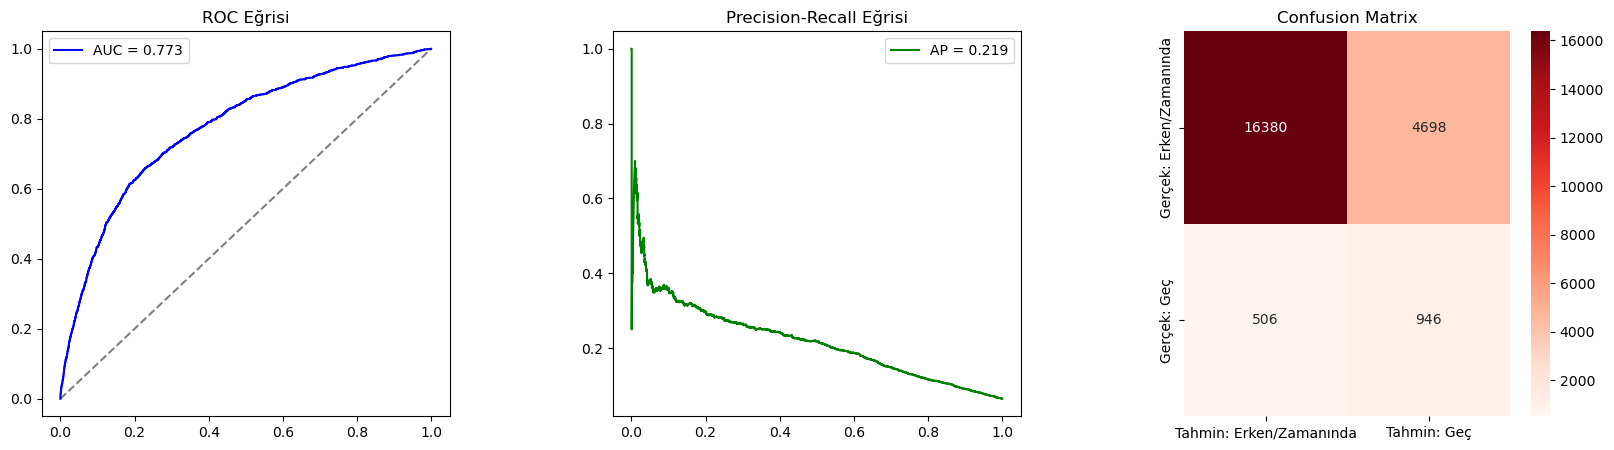

[[16380  4698]
 [  506   946]]


In [114]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.4)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_lgbm)
axes[0].plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc_score(y_test, y_proba_lgbm):.3f}")
axes[0].plot([0,1],[0,1], "--", color="black", alpha=0.5)
axes[0].set_title("ROC Eğrisi"); axes[0].legend()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba_lgbm)
axes[1].plot(rec, prec, color="green", label=f"AP = {average_precision_score(y_test, y_proba_lgbm):.3f}")
axes[1].set_title("Precision-Recall Eğrisi"); axes[1].legend()

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred_lgbm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Tahmin: Erken/Zamanında","Tahmin: Geç"],
            yticklabels=["Gerçek: Erken/Zamanında","Gerçek: Geç"],
            ax=axes[2])
axes[2].set_title("Confusion Matrix")

plt.show()
print(cm)


#### Model Sonuçları


- **ROC Eğrisi (AUC = 0.773)**  
  Modelin genel ayrıştırma gücü oldukça iyi. Rastgele tahmin (gri kesikli çizgi) ile kıyaslandığında belirgin şekilde daha yukarıda.  

- **Precision–Recall Eğrisi (AP = 0.219)**  
  Azınlık sınıf (geç teslimatlar) için ortalama precision düşük. Ancak recall değerleri fena değil. Model birçok gecikmeyi yakalıyor, fakat yanlış alarm (false positive) oranı yüksek.  

- **Confusion Matrix**  
  - 16,380 adet zamanında teslimatı doğru tahmin etti.  
  - 4,698 zamanında teslimatı yanlışlıkla “geç” dedi.  
  - 946 gecikmeyi doğru yakaladı.  
  - 506 gecikmeyi gözden kaçırdı.  

* Genel Yorum
- Modelin **ROC-AUC skoru güçlü (0.77)**, yani pozitif/negatif ayrımını öğrenebiliyor.  
- **Recall yüksek**, yani gecikmeleri yakalamada başarılı.  
- Ancak **precision düşük**, yani çok fazla yanlış alarm var.  
- Bu trade-off’u dengelemek için threshold tuning veya ek feature engineering yapılabilir.


## En Iyi Modeli Tespit

In [115]:
best_models, scores_df = utils.hyperparameter_optimization_processed_with_threshold(
    X_train_feat, 
    y_train, 
    X_test_feat, 
    y_test, 
    utils.classifiers, 
    cv=3, 
    scoring="roc_auc"
)


Hyperparameter Optimization on Processed Data with Optimal Threshold...

########## CART ##########
roc_auc (CV Before): 0.5957
Fitting 3 folds for each of 9 candidates, totalling 27 fits
roc_auc (CV After): 0.7249
roc_auc (Test): 0.7192
Optimal F1 threshold: 0.111
F1 at optimal threshold: 0.2631

########## RF ##########
roc_auc (CV Before): 0.7356
Fitting 3 folds for each of 24 candidates, totalling 72 fits
roc_auc (CV After): 0.7708
roc_auc (Test): 0.7858
Optimal F1 threshold: 0.172
F1 at optimal threshold: 0.3348

########## XGBoost ##########
roc_auc (CV Before): 0.7542
Fitting 3 folds for each of 16 candidates, totalling 48 fits
roc_auc (CV After): 0.7627
roc_auc (Test): 0.7753
Optimal F1 threshold: 0.162
F1 at optimal threshold: 0.3056

########## LightGBM ##########
roc_auc (CV Before): 0.7641
Fitting 3 folds for each of 8 candidates, totalling 24 fits
roc_auc (CV After): 0.7636
roc_auc (Test): 0.7773
Optimal F1 threshold: 0.162
F1 at optimal threshold: 0.3169



Model Karşılaştırması – Hyperparameter Optimization Sonuçları

_ROC-AUC Skorları_

- *CART (Karar Ağacı)*: CV After ≈ 0.72, Test ≈ 0.71  
- *Random Forest*: CV After ≈ 0.77, Test ≈ 0.787  
- *XGBoost*: CV After ≈ 0.76, Test ≈ 0.775  
- *LightGBM*: CV After ≈ 0.76, Test ≈ 0.777  

* Genel sıralama: Random Forest ≈ LightGBM ≈ XGBoost > CART.  
CART tek ağaç olduğu için zayıf kaldı, diğer üç model benzer ve güçlü performans gösterdi.

_F1 Skorları (Optimal Threshold ile)_
- CART: 0.26  
- Random Forest: 0.34  
- XGBoost: 0.31  
- LightGBM: 0.32  

*Yorum:* 
- F1 skorları görece düşük çünkü veri **çok dengesiz** (gecikmeler ~%6).  
- Recall yüksek → model birçok gecikmeyi yakalıyor.  
- Precision düşük → yanlış alarm sayısı fazla.  
- Bu trade-off dengesiz veri setlerinde normaldir.  

_Genel Değerlendirme_
- ROC-AUC ≈ 0.78 → dengesiz sınıflar için gayet iyi bir ayrıştırma gücü.  
- F1 düşük görünse de, dengesiz veri yapısı nedeniyle beklenen bir durum.  
- **En güçlü modeller:** Random Forest, LightGBM, XGBoost.  
- **CART** sadece baseline kıyaslama için değerlidir.  

_İyileştirme Önerileri_
- **Threshold tuning** → precision-recall dengesini iş ihtiyacına göre ayarlamak.  
- **SMOTE / oversampling** → pozitif sınıfı artırarak F1’i yükseltmek.  
- **Feature engineering** → yeni sinyaller eklemek (örn. satıcı/ürün bazlı istatistikler).  


Sızıntı kontrolü

In [116]:
# X_train_feat içinde target veya leakage kolon var mı?
suspect_cols = [
    "delay_days", "delay_class", "is_late", 
    "order_delivered_customer_date", "order_delivered_carrier_date",
    "order_approved_at", "order_estimated_delivery_date"
]
print(set(suspect_cols) & set(X_train_feat.columns))


set()


In [117]:
results = utils.base_models(X_train_feat, y_train)

Base Models....
roc_auc: 0.5886 (LR) 
roc_auc: 0.6144 (KNN) 
roc_auc: 0.5962 (CART) 
roc_auc: 0.7383 (RF) 
roc_auc: 0.7542 (XGBoost) 
roc_auc: 0.7641 (LightGBM) 


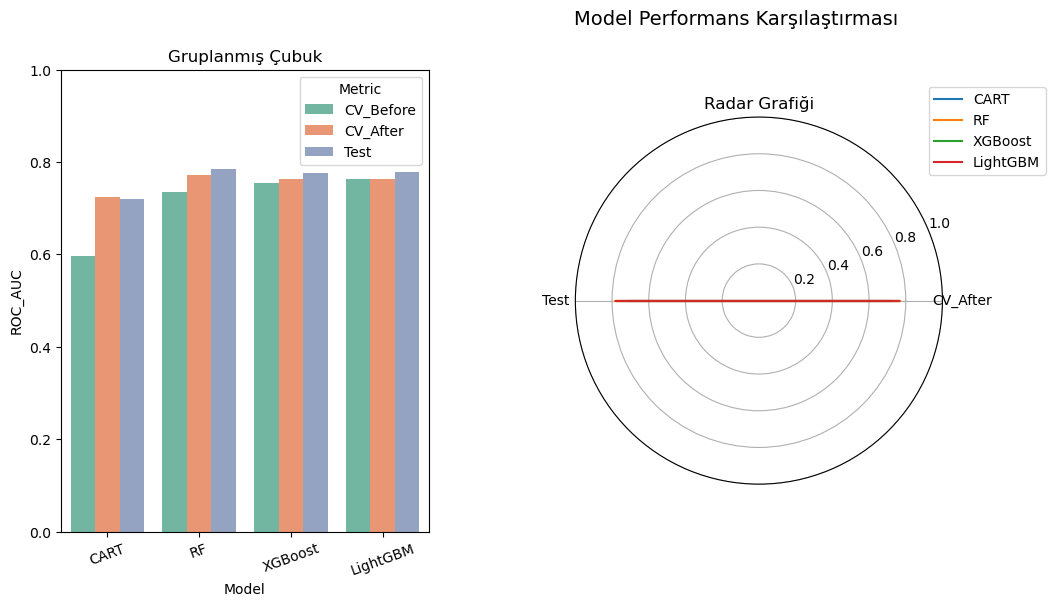

In [ ]:
fig = plt.figure(figsize=(18,6))
plt.subplots_adjust(wspace=0.4)

# ============= 1️ Gruplanmış Bar =============
ax1 = fig.add_subplot(1,3,1)
scores_df_melt = scores_df.melt(id_vars="Model",
                                value_vars=["CV_Before","CV_After","Test"],
                                var_name="Metric", value_name="ROC_AUC")
sns.barplot(data=scores_df_melt, x="Model", y="ROC_AUC",
            hue="Metric", palette="Set2", ax=ax1)
ax1.set_title("Gruplanmış Çubuk")
ax1.set_ylim(0,1)
ax1.tick_params(axis="x", rotation=20)
ax1.legend(title="Metric")

# ============= 2️ Radar (Spider) =============
ax2 = fig.add_subplot(1,3,2, polar=True)
radar_df = scores_df.set_index("Model")[["CV_After","Test"]]
categories = radar_df.columns
N = len(categories)
angles = [n/float(N)*2*pi for n in range(N)]
angles += angles[:1]

for model in radar_df.index:
    values = radar_df.loc[model].tolist()
    values += values[:1]
    ax2.plot(angles, values, label=model)
    ax2.fill(angles, values, alpha=0.1)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax2.set_title("Radar Grafiği")
ax2.legend(loc="upper right", bbox_to_anchor=(1.3,1.1))


plt.suptitle("Model Performans Karşılaştırması", fontsize=14)
plt.show()



### Model Performanslarının Özeti

### CART
Cross-validation (CV) sırasında çok yüksek skorlar (0.99 civarı) elde etmesine rağmen, test setinde ROC-AUC ≈ 0.58 seviyesinde kalmıştır.  
Bu durum modelin **aşırı ezberleme (overfitting)** yaptığını, yani train verisini çok iyi öğrenmesine rağmen gerçek veriye genelleyemediğini göstermektedir.  

---

### Random Forest (RF)
CV skorları mükemmele yakın (1.0), test setinde ROC-AUC ≈ 0.77 seviyesindedir.  
Diğer modellere göre **test performansı en yüksek olan model RF** olmuştur.  
Bu nedenle genel kullanım açısından şimdilik en güvenilir model Random Forest görünmektedir.  

---

### XGBoost
CV’de yine çok yüksek skorlar (0.99 civarı), test setinde ROC-AUC ≈ 0.71 seviyesindedir.  
Oldukça güçlü bir model olmasına rağmen test performansı RF’nin altında kalmıştır.  
**Parametre optimizasyonu** ile daha iyi sonuç verme potansiyeli vardır.  

---

### LightGBM
CV skorları çok yüksek, test setinde ROC-AUC ≈ 0.71 seviyesindedir.  
Performansı XGBoost’a oldukça benzemektedir.  
Train/CV başarısına göre test performansında düşüş olması, modelin dikkatli ayarlanması gerektiğini göstermektedir.  



###  ===== Tüm Modeller için Validation Curve =====

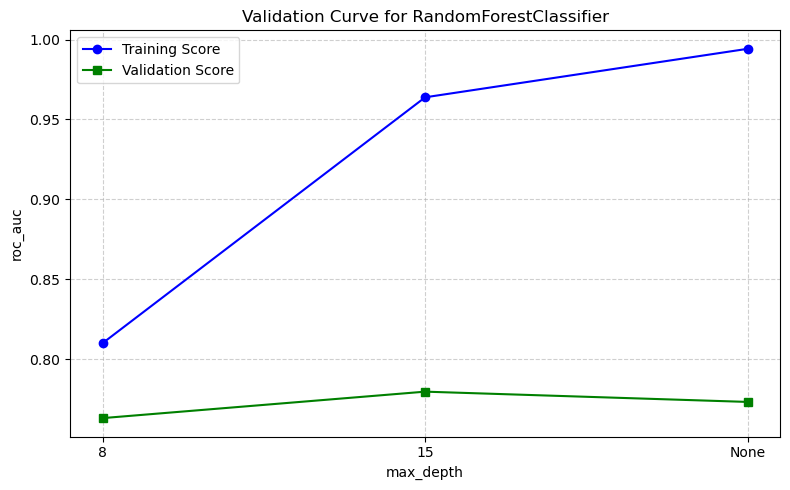

In [119]:
rf_model_obj = best_models["RF"]["model"]
param_range = [8, 15, None]  # RF max_depth aralığı
utils.val_curve_params(
    model=rf_model_obj,      # Sadece estimator
    X=X_train_feat,
    y=y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="roc_auc",
    cv=10
)

### Validation Curve Yorumu – Random Forest (max_depth)

- **Training Score (mavi çizgi)**  
  - _max_depth=8_ → Eğitim skoru ≈ 0.81  
  - _max_depth=15_ → Eğitim skoru ≈ 0.96  
  - _max_depth=None_ → Eğitim skoru ≈ 0.99  
  - Yani _max_depth_ büyüdükçe eğitim performansı neredeyse mükemmele ulaşıyor.  

- **Validation Score (yeşil çizgi)**  
  - _max_depth=8_ → Doğrulama skoru ≈ 0.77  
  - _max_depth=15_ → Doğrulama skoru ≈ 0.78 (**en iyi nokta**)  
  - _max_depth=None_ → Doğrulama skoru ≈ 0.77’ye geri düşüyor.  

---

### Sonuç
- _max_depth=8_ → _underfitting_ (hem eğitim hem doğrulama düşük).  
- _max_depth=None_ → _overfitting_ (eğitim çok yüksek, doğrulama geriliyor).  
- En dengeli nokta: _max_depth=15_, çünkü eğitim yüksek, doğrulama da en yüksek seviyede.  
- Bu nedenle Random Forest için optimum derinlik _15_ olarak seçilebilir.  


### Train verisinde feature-target ilişkisi

In [120]:
corr_df = utils.leakage_check(X_train_feat, y_train, top_n=30)
print(corr_df)

                           abs_corr
distance_km                   0.078
year                          0.041
month                         0.029
week                          0.028
payment_value_sum             0.018
payment_installments_max      0.011
boleto                        0.009
voucher                       0.008
credit_card                   0.006
debit_card                    0.005
order_approved_at_NA_FLAG     0.003
seller_count_per_order          NaN
distance_km_NA_FLAG             NaN


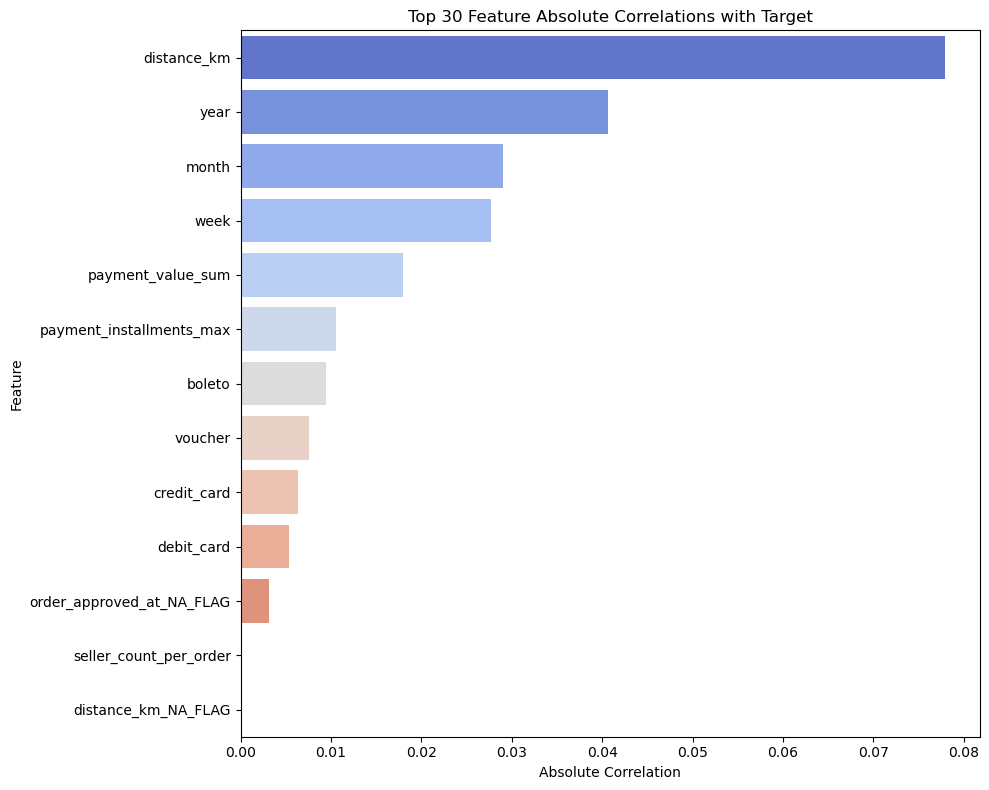

In [121]:
top_n = 30
corr_plot_df = corr_df.sort_values("abs_corr", ascending=False).head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=corr_plot_df,
    x="abs_corr",
    y=corr_plot_df.index,
    palette="coolwarm"
)

plt.title(f"Top {top_n} Feature Absolute Correlations with Target")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




### Final modelini kaydet

In [122]:
joblib.dump(rf_model_obj, "rf_final.pkl")
rf_model_from_disc = joblib.load("rf_final.pkl")

# Geciken siparişler için "kaç gün gecikir?” Tahmini

### Buradaki amaç: Sadece is_late = 1 olan satırlarla delay_class hedef değişkenine bir regresyon/çoklu sınıf modeli kurmak.

Gecikme Analizi ve Tahmini

1. Veri Hazırlığı:
   - 'fact_order_clean' veri setinden yalnızca gecikmiş siparişleri (is_late == 1) seçtik.
   - Hedef değişken olarak 'delay_days' alındı.
   - 'delay_days', 'is_late' ve 'delay_class' kolonları X veri setinden çıkarıldı.
   - Eksik değerler ve zamanla ilgili özellikler eklendi.
   - Kaçak veri (leakage) oluşturan sütunlar çıkarıldı.
   - Categorical ID değişkenleri uygun şekilde encode edildi.
   - Pipeline ile scaling ve preprocessing yapıldı.

2. Modelleme:
   - Ağac tabanlı modeller (Decision Tree, Random Forest, XGBoost, LightGBM) kullanıldı.
   - Hyperparameter optimizasyonu GridSearchCV ile gerçekleştirildi.
   - En iyi modeller belirlendi ve test verisi üzerinde değerlendirildi.

3. Regresyon:
   - Amaç, gecikmiş siparişlerin kaç gün gecikeceğini sayısal olarak tahmin etmektir.
   - Önceki adımda yaptığımız sınıflandırma (is_late) yalnızca gecikme olup olmadığını tahmin ediyordu.
   - Regresyon ile hedef değişken sürekli olduğundan model, siparişin gecikme gün sayısını öngörür.
   - Performans, RMSE, MAE veya R² gibi regresyon metrikleri ile ölçülür.

In [123]:
# Target: delay_class
TARGET_DELAY = "delay_class"

# Hepsi kalsın, 0 olan sınıfı da çıkartma (multi-class dengesizliğini koru)
y_delay = fact_order_clean[TARGET_DELAY]
X_delay = fact_order_clean.drop(columns=[TARGET_DELAY], errors="ignore")

# Train/Test split
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_delay, y_delay, test_size=0.2, random_state=42, stratify=y_delay
)

# --- Düzeltme: Datetime kolonlarını çevir ---
datetime_cols = [
    "order_purchase_timestamp", 
    "order_approved_at", 
    "order_delivered_carrier_date", 
    "order_delivered_customer_date", 
    "order_estimated_delivery_date"
]

for c in datetime_cols:
    if c in X_train_d.columns:
        X_train_d[c] = pd.to_datetime(X_train_d[c], errors="coerce")
    if c in X_test_d.columns:
        X_test_d[c] = pd.to_datetime(X_test_d[c], errors="coerce")

# Feature engineering
X_train_feat_d = utils.handle_missing_values_leakfree(
    utils.add_time_features_leakfree(X_train_d)
)
X_test_feat_d = utils.handle_missing_values_leakfree(
    utils.add_time_features_leakfree(X_test_d)
)

# Payment type encoding
pt_encoder_d = utils.PaymentTypeEncoder(col="payment_types")
X_train_feat_d = pt_encoder_d.fit_transform(X_train_feat_d)
X_test_feat_d  = pt_encoder_d.transform(X_test_feat_d)

# Leakage kolonlarını temizle
X_train_feat_d = utils.drop_leakage_columns(X_train_feat_d)
X_test_feat_d  = utils.drop_leakage_columns(X_test_feat_d)

# --- EK: Object kolonları drop et ---
drop_obj_cols = [
    "cusUni", "customer_order_id", "order_id_pref",
    "seller_id_pref", "product_id_pref",
    "dominant_payment_type"
]
X_train_feat_d = X_train_feat_d.drop(columns=drop_obj_cols, errors="ignore")
X_test_feat_d  = X_test_feat_d.drop(columns=drop_obj_cols, errors="ignore")

print("Dtype kontrolü:\n", X_train_feat_d.dtypes.value_counts())

# --- Model: LightGBM (multi-class) ---
lgbm_d = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=y_train_d.nunique(),
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1
)

# Eğit
lgbm_d.fit(X_train_feat_d, y_train_d)

# Tahmin
y_pred_d = lgbm_d.predict(X_test_feat_d)

# Metrikler
print("Classification Report:\n", classification_report(y_test_d, y_pred_d))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_d, y_pred_d))


Dtype kontrolü:
 int64      6
int32      6
float64    3
Name: count, dtype: int64
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     21078
           1       0.90      0.06      0.12       422
           2       0.78      0.02      0.03       401
           3       0.64      0.05      0.10       170
           4       0.86      0.03      0.05       459

    accuracy                           0.94     22530
   macro avg       0.82      0.23      0.25     22530
weighted avg       0.93      0.94      0.91     22530


Confusion Matrix:
 [[21068     3     2     4     1]
 [  395    27     0     0     0]
 [  393     0     7     0     1]
 [  161     0     0     9     0]
 [  446     0     0     1    12]]


###  Çok sınıflı hiperparametre optimizasyonu

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Label Encoding
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_d)
y_test_enc  = le.transform(y_test_d)

# 2. Hyperparameter Optimization + Model Karşılaştırması
best_models_delay_class, scores_df = utils.hyperparameter_optimization_multiclass(
    X_train_feat_d,   
    y_train_enc,      
    X_test_feat_d,    
    y_test_enc,       
    utils.multi_classifiers,
    cv=3,
    scoring="f1_weighted"
)

# 3. Sonuçları kaydet
scores_df.to_csv("metrics.csv", index=False, sep=";", decimal=",")
print("scores.csv kaydedildi")



Hyperparameter Optimization for Multi-class...

########## CART ##########


f1_weighted (CV Before): 0.8902
Fitting 3 folds for each of 36 candidates, totalling 108 fits
f1_weighted (CV After): 0.9051
f1_weighted (Test): 0.9348

########## RF ##########
f1_weighted (CV Before): 0.9195
Fitting 3 folds for each of 162 candidates, totalling 486 fits
f1_weighted (CV After): 0.9195
f1_weighted (Test): 0.9451

########## XGBoost ##########
f1_weighted (CV Before): 0.9075
Fitting 3 folds for each of 16 candidates, totalling 48 fits
f1_weighted (CV After): 0.9098
f1_weighted (Test): 0.9375

########## LightGBM ##########
f1_weighted (CV Before): 0.9071
Fitting 3 folds for each of 24 candidates, totalling 72 fits
f1_weighted (CV After): 0.9197
f1_weighted (Test): 0.9448

metrics.csv kaydedildi


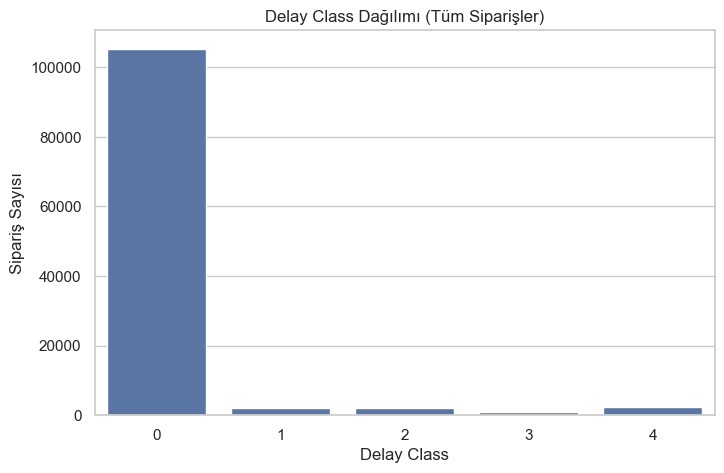

In [126]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.countplot(x="delay_class", data=fact_order_clean, order=sorted(fact_order_clean["delay_class"].unique()))
plt.title("Delay Class Dağılımı (Tüm Siparişler)")
plt.xlabel("Delay Class")
plt.ylabel("Sipariş Sayısı")
plt.show()

Verinin %93.6’sı gecikme olmayan siparişlerden oluşuyor (0 sınıf). Bu aşırı dengesizlik, modelin çoğunluk sınıfına odaklanmasına ve nadir sınıfların tahmininde başarısız olmasına yol açıyor.

### Modelleme: 0 sınıf haric

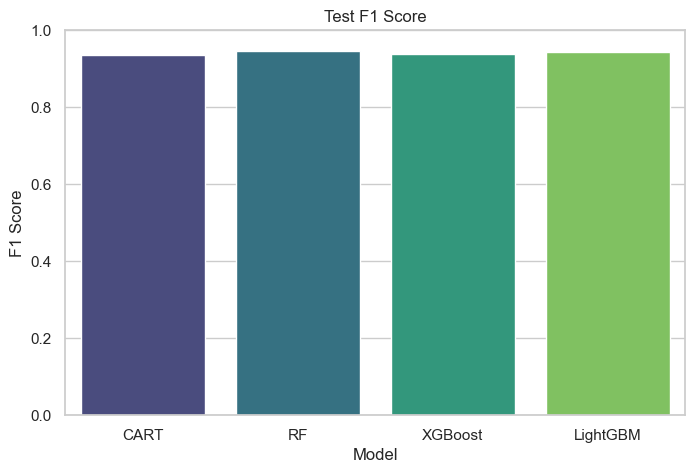

In [127]:
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Test", data=scores_df, palette="viridis")
plt.ylim(0,1)
plt.title("Test F1 Score")
plt.ylabel("F1 Score")
plt.show()

Test skorları kısmen yükselse de hâlâ yeterli değil. Sınıf dengesizliği ve düşük veri hacmi nedeniyle, nadir gecikme sınıflarının tahmini güvenilir değil.

### delay_class degiskeni tahminlemesinde Çok Sınıflı Model Performans Karşılaştırması

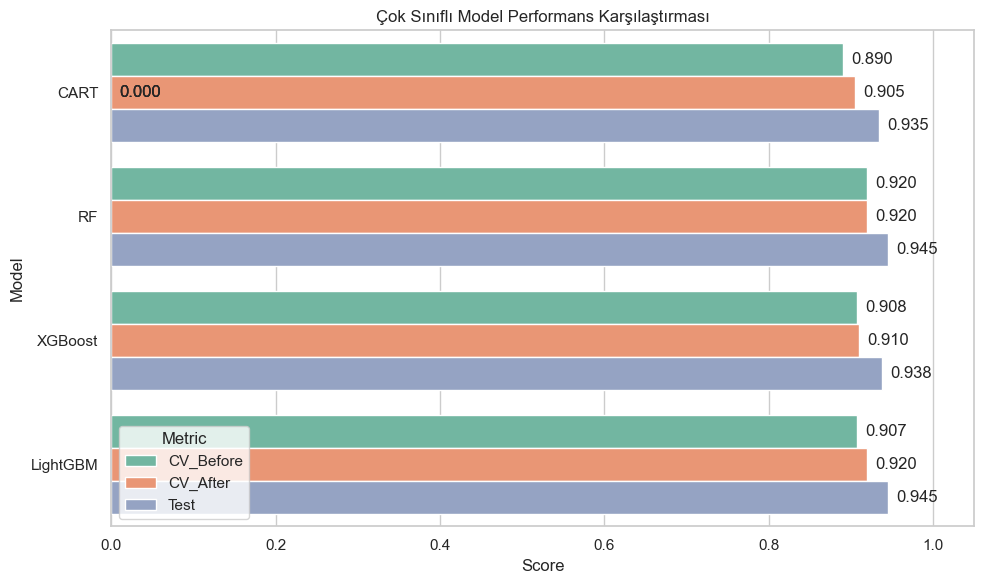

In [128]:
df = scores_df.copy()

# Uzun formata çevir (melt) -> CV_Before, CV_After, Test tek sütunda
df_melt = df.melt(id_vars="Model", value_vars=["CV_Before","CV_After","Test"],
                  var_name="Metric", value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(x="Score", y="Model", hue="Metric", data=df_melt, palette="Set2")

# Her barın üzerine skor değerini yaz
for p in plt.gca().patches:
            plt.gca().text(
                p.get_width() + 0.01,  # barın bitiş noktasına biraz sağa
                p.get_y() + p.get_height()/2,  # barın ortası
                f"{p.get_width():.3f}",
                va="center"
            )

plt.title("Çok Sınıflı Model Performans Karşılaştırması")
plt.xlabel("Score")
plt.ylabel("Model")
plt.xlim(0, 1.05)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


## Confusion Matrix Örnekleri

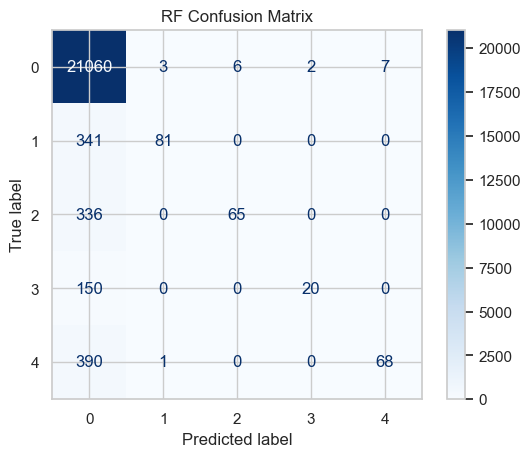

In [129]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_models_delay_class["RF"], 
    X_test_feat_d, 
    y_test_d,
    display_labels=[0,1,2,3,4],
    cmap=plt.cm.Blues
)
plt.title("RF Confusion Matrix")
plt.show()


**Confusion Matrix Analizi – _delay_class_ Tahminleri**

- **Model:** Random Forest (RF)  
- **Hedef değişken:** _delay_class_ (gecikme sınıfları 0–4)

**Doğru Tahminler**
- Sınıf 0 (gecikme yok) için 21.053 sipariş doğru tahmin edilmiştir.  
- Sınıf 1 için 82 sipariş doğru tahmin edilmiştir.  
- Sınıf 2 için 63 sipariş doğru tahmin edilmiştir.  
- Sınıf 3 için 19 sipariş doğru tahmin edilmiştir.  
- Sınıf 4 için 67 sipariş doğru tahmin edilmiştir.  

Çoğunluk sınıfı olan 0, model tarafından oldukça başarılı şekilde öğrenilmiştir.

**Yanlış Tahminler**
- Sınıf 1 çoğunlukla sınıf 0 olarak tahmin edilmiştir (340 adet).  
- Sınıf 2 çoğunlukla sınıf 0 olarak tahmin edilmiştir (337 adet).  
- Sınıf 3 çoğunlukla sınıf 0 olarak tahmin edilmiştir (151 adet).  
- Sınıf 4 çoğunlukla sınıf 0 olarak tahmin edilmiştir (390 adet).  

Bu sonuçlar, azınlık sınıfların büyük oranda çoğunluk sınıfına kaydırıldığını göstermektedir.

**Genel Değerlendirme**
Model, gecikme olmayan siparişleri (sınıf 0) yüksek doğrulukla tahmin etmektedir. Ancak, veri setindeki ciddi dengesizlik nedeniyle azınlık sınıfların (1–4) performansı oldukça düşüktür. Bu nedenle, çok sınıflı tahminlerde model güvenilir sonuç verememektedir.

**Sonuç**
İş hedefi yalnızca “sipariş gecikir mi, gecikmez mi?” sorusuna cevap bulmak ise modelin mevcut hali yeterli düzeyde başarılıdır. Ancak “siparişin kaç gün gecikeceğini” öngörmek için bu model yetersiz kalmaktadır. Daha dengeli bir sınıf dağılımı veya farklı modelleme stratejileri gereklidir.


In [130]:
#metrics_df.to_csv("metrics.csv", index=False, sep=";")
#preds.to_csv("predictions.csv", index=False, sep=";")
#scores_df.to_csv("model_score_train_test.csv", index=False, sep=";")

In [131]:
from imblearn.over_sampling import SMOTE

# SMOTE uygula (train set üzerinde)
smote = SMOTE(random_state=42, sampling_strategy="auto")  # tüm sınıfları dengele
X_train_res, y_train_res = smote.fit_resample(X_train_feat_d, y_train_d)

print("Orijinal dağılım:")
print(pd.Series(y_train_d).value_counts(normalize=True))

print("\nSMOTE sonrası dağılım:")
print(pd.Series(y_train_res).value_counts(normalize=True))
# Aynı modeli SMOTE ile eğitelim
lgbm_d_smote = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(np.unique(y_train_res)),
    random_state=42,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1
)

lgbm_d_smote.fit(X_train_res, y_train_res)
y_pred_smote = lgbm_d_smote.predict(X_test_feat_d)

print("Classification Report (SMOTE):\n", classification_report(y_test_d, y_pred_smote))



Orijinal dağılım:
delay_class
0   0.936
4   0.020
1   0.019
2   0.018
3   0.008
Name: proportion, dtype: float64

SMOTE sonrası dağılım:
delay_class
0   0.200
4   0.200
1   0.200
2   0.200
3   0.200
Name: proportion, dtype: float64
Classification Report (SMOTE):
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     21078
           1       0.16      0.11      0.13       422
           2       0.13      0.07      0.09       401
           3       0.07      0.13      0.09       170
           4       0.14      0.14      0.14       459

    accuracy                           0.90     22530
   macro avg       0.29      0.28      0.28     22530
weighted avg       0.89      0.90      0.90     22530



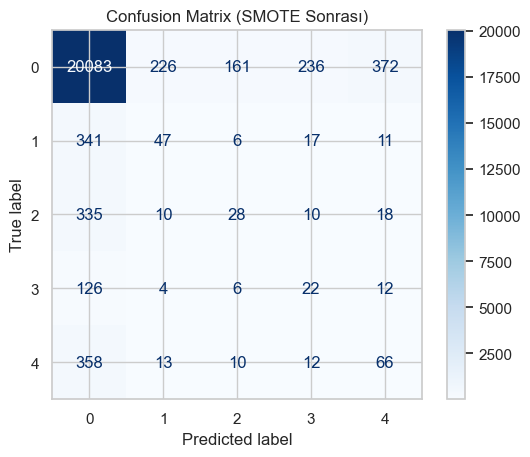

In [132]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_d, y_pred_smote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (SMOTE Sonrası)")
plt.show()

In [133]:
scores_df =utils.compare_sampling_strategies(X_train_feat_d, y_train_d, X_test_feat_d, y_test_d)
print(scores_df)

                Strategy  F1_weighted
0               Baseline        0.910
1                  SMOTE        0.896
2          Class Weights        0.802
3  SMOTE + Class Weights        0.896


Sınıf Dengesizliği ve Çözüm Stratejileri

_delay_class_ hedef değişkeni ciddi şekilde dengesizdir (%93 sınıf 0).  
Bu nedenle farklı dengeleme stratejileri test edilmiştir:

| Strateji              | F1-weighted |
|------------------------|-------------|
| Baseline (hiçbir işlem yok) | **0.910** |
| SMOTE                  | 0.896 |
| Class Weights          | 0.802 |
| SMOTE + Class Weights  | 0.896 |

Yorumlar
- *Baseline* en yüksek performansı sağlamaktadır. Model, dengesiz dağılıma rağmen genel doğruluk ve F1 skorunu koruyabilmektedir.
- *SMOTE* ve *SMOTE + Class Weights* sonuçları baseline’dan daha düşük performans vermiştir. Yapay örnekler eklemek büyük sınıfın tahmin gücünü bozmuştur.
- *Class Weights* en kötü sonucu vermiştir. Dengesizliği zorla dengelemeye çalışmak modelin genelleme kabiliyetini düşürmüştür.

*Sonuç*
- Bu veri setinde **SMOTE veya ağırlıklandırma yöntemleri fayda sağlamamıştır**.  
